# Imports

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency, ks_2samp
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load Data and Preprocessing

In [36]:
# Load dataset
df = pd.read_excel("../data/albion_dataset_2024.8.xlsx")

# Filter rows with valid diagnosis and visits
df_cleaned = df[df['DIAGNOSIS'].notna() & (df['DIAGNOSIS'] != 2) & (df['VisitNuA'] != 999)]

# Replace 0 with 1 in IADL columns
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
df_cleaned[iadl_columns] = df_cleaned[iadl_columns].replace(0, 1)

# Function to map CDR values
def map_values(val):
    mapping = {0.0: 0, 0.5: 1, 1.0: 2, 1.5: 3, 2.0: 3, 3.0: 4, 999.0: 999}
    return mapping.get(val, val)

# Apply mapping function to CDR columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
df_cleaned[cdr_columns] = df_cleaned[cdr_columns].applymap(map_values)

# Rename column (error)
if 'UODRS3e' in df_cleaned.columns:
    df_cleaned.rename(columns={'UODRS3e': 'UPDRS3e'}, inplace=True)

# Replace invalid values with valid values from other visits
def replace_invalid(group, column):
    valid_values = group[(group[column] != 999) & (~group[column].isna())][column]
    if not valid_values.empty:
        valid_value = valid_values.iloc[0]
        group[column] = group[column].replace(999, valid_value).fillna(valid_value)
    return group

# Apply replacement for MH and FH features
mh_features = [f'MH{i}' for i in range(1, 23)]
fh_features = [f'FH{i}' for i in range(1, 17)]
all_features = mh_features + fh_features
for feature in all_features:
    df_cleaned = df_cleaned.groupby('ID').apply(lambda group: replace_invalid(group, feature)).reset_index(drop=True)

# Last Observation Carried Forward for Marital Status and Living Arrangement
df_cleaned['ΜaritalC'] = df_cleaned.groupby('ID')['ΜaritalC'].fillna(method='ffill')
df_cleaned['Living_Arrangement'] = df_cleaned.groupby('ID')['Living_Arrangement'].fillna(method='ffill')

# Filter for first visit and reset index
df_cleaned = df_cleaned[df_cleaned['VisitNuA'] == 1].reset_index(drop=True)

# Select relevant columns
columns = [
    "ID", "SEX", "EDU", "AgeC", "ΜaritalC", 
    "Living_Arrangement", "WorkStat", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "CDR_TOT", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14", "UPDRS_TOT", "MMSE", "ZME", "ZEX", 
    "ZVS", "ZLA", "ZAS"
]

diagnosis_list = [
    "DIAGNOSIS"
]

hads_list = ["HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7"]

sleep_list = [
    'H1', 'H2a', 'H2b', 'H3', 'H4', 'H5',
    'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12'
]

leisure_list = [
    "E1a", "E2a", "E3a", "E4a", "E5a", "E6a", "E7a", "E8a", "E9a", "E10a",
    "E11a", "E12a", "E13a", "E14a", "E15a", "E16a", "E17a", "E18a", "E19a",
    "E20a", "E21a", "E22a", "E23a"
]

scc_list = [
    "SCC1", "SCC2", "SCC3", "SCC4", "SCC5", "SCC6", "SCC7", "SCC8", "SCC9",
    "SCC10", "SCC11", "SCC12", "SCC13", "SCC14", "SCC15"
]

anthropometrics_list = ['SPEED_1', 'SPEED_2', 'GRIP_1', 'GRIP_2', 'GRIP_3', 'WeightC', 'HeightC', 'W2', 'W3', 'W4', 'W5']

csf_list = ['CSF_AB4', 'CSF_T4', 'CSF_PHT4', 'AMYLOID_NOMINAL', 'TAU_NOMINAL', 'PHTAU_NOMINAL', 'ATN_classification']

nutrient_list = [
    "MD_total"
]

watchpat_list = [
    "Pacemaker",
    "pRDI", "pAHI", "pAHICentral", "ODI", "PERC_DeepSleep", "PERC_LightSleep",
    "PERC_REM", "REMRDI", "REMAHI", "REMAHICentral", "REMODI", "NREMRDI",
    "NREMAHI", "NREMAHICentral", "NREMODI", "PERC_CSR", "RDITotalEventsNum",
    "AHITotalEventsNum", "AHICentralTotalEventsNum", "MeanSaturation",
    "MinSaturation", "MaxSaturation", "MeanREMSaturation", "MinREMSaturation",
    "MaxREMSaturation", "MeanNREMSaturation", "MinNREMSaturation",
    "MaxNREMSaturation", "MeanofDesaturationNadirs", "TotalNumberofDesaturations",
    "SatBelow90", "SatBelowEqual88", "SatBelow88", "SatBelow85", "SatBelow80",
    "SatBelow70", "MeanPulserate", "MinPulserate", "MaxPulserate", 
    "perc_SleepInProne", "pRDIInProne", "pAHIInProne", "ODIInProne", 
    "perc_SleepInSupine", "pRDIInSupine", "pAHIInSupine", "ODIInSupine", 
    "perc_SleepInLeft", "pRDIInLeft", "pAHIInLeft", "ODIInLeft", 
    "perc_SleepInRight", "pRDIInRight", "pAHIInRight", "ODIInRight", 
    "perc_SleepInNonSupine", "pRDIInNonSupine", "pAHIInNonSupine", "ODIInNonSupine",
    "MeanSnoreDB", "SnoreThreshold", "perc_SleepOverThreshold",
     "perc_SleepOver40_A",  "perc_SleepOver50_A",
     "perc_SleepOver60_A", "perc_SleepOver70_A",
     "perc_SleepOver80_A", "SleepLatencymin", "REMpLatencymin",
    "PERC_SleepEfficiency", "NumberOfWakes"
]

all_columns = columns + diagnosis_list + hads_list + sleep_list + leisure_list + scc_list + anthropometrics_list + csf_list + nutrient_list + watchpat_list

df_cleaned = df_cleaned[all_columns]

# Replace specific values in columns (error)
df_cleaned['EDU'] = df_cleaned['EDU'].replace(999, 0)
df_cleaned['E7a'] = df_cleaned['E7a'].replace(44, 4)

# Replace values in leisure and sleep features
filtered_sleep_list = [f"H{i}" for i in range(1, 13) if i not in [2]]

for feature in leisure_list:
    df_cleaned[feature] = df_cleaned[feature].replace(9, 99)
for feature in filtered_sleep_list:
    df_cleaned[feature] = df_cleaned[feature].replace(9, 99)

# Replace values in SCC features (error)
scc_replacements = {
    'SCC4': {3: 1},
    'SCC11': {10: 1},
    'SCC12': {2: 1, 14: 1},
    'SCC15': {9: 1}
}
for column, replacements in scc_replacements.items():
    df_cleaned[column] = df_cleaned[column].replace(replacements)

# Replace 999 with NaN
df_cleaned.replace(999, np.nan, inplace=True)

# Drop columns with excessive missing values
missing_percentage = df_cleaned.isnull().mean() * 100
columns_to_keep = missing_percentage[missing_percentage <= 30].index
df_cleaned = df_cleaned[columns_to_keep]

# Remove rows with excessive missing values per group (ID + VisitNuA)
total_columns = df_cleaned.drop(columns=["ID", "VisitNuA"], errors="ignore").shape[1]
thresh_value = 0.3 * total_columns

group_missing = df_cleaned.groupby(['ID']).apply(lambda x: x.isnull().sum().sum())
to_drop = group_missing[group_missing > thresh_value].index
df_cleaned = df_cleaned[~df_cleaned.set_index(['ID']).index.isin(to_drop)].reset_index(drop=True)

# Group by 'ID' and sum missing values across the features in 'mh_med_fh'
mh_med_fh = [
    "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", "MH8", "MH9", "MH10", "MH11", "MH12", 
    "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", "MH20", "MH21", "MH22", "SMOKING", 
    "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", "MED7", "MED8", "MED9", "MED10", 
    "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", "MED18", "MED19", "MED20", 
    "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", 
    "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", "FH16"
]

missing_values_per_id = df_cleaned.groupby('ID')[mh_med_fh].apply(lambda x: x.isnull().sum().sum())

# Calculate the threshold for missing values (30% of the number of features)
thresh_mh_med_fh = 0.3 * len(mh_med_fh)

# Identify rows where the total missing values exceed the threshold
rows_to_drop = missing_values_per_id[missing_values_per_id > thresh_mh_med_fh].index
df_cleaned = df_cleaned[~df_cleaned['ID'].isin(rows_to_drop)]

# Handle specific corrections (error)
df_cleaned.loc[df_cleaned['HADS_D4'] == 11, 'HADS_D4'] = 1
df_cleaned.loc[df_cleaned['HeightC'] < 120, 'HeightC'] *= 100

# Drop unnecessary columns
drop_columns = ['Pacemaker', 'SatBelow88', 'W2', 'W3', 'W4']
df_cleaned.drop(columns=[col for col in drop_columns if col in df_cleaned.columns], inplace=True)

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_94034/260146114.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[iadl_columns] = df_cleaned[iadl_columns].replace(0, 1)
/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_94034/260146114.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned[cdr_columns] = df_cleaned[cdr_columns].applymap(map_values)
/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_94034/260146114.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

# Train and Test Split

The two code blocks below are commented out. These are part of our train and test split approach. To run the code below, we first need to obtain the helper files from each data preparation pipeline, for every visit. We have done this, and gathered the IDs that belong to the train and test set. These sets will be used in the remainder of the data preparation pipeline. 

In [150]:
# df_cleaned[['ID', 'DIAGNOSIS']].to_csv('../data/firstvisit_traintestsplit_helper.csv', index=False)

In [151]:
# # Load the CSV files for all visits
# first_visit = pd.read_csv("../data/firstvisit_traintestsplit_helper.csv")
# second_visit = pd.read_csv("../data/secondvisit_traintestsplit_helper.csv")
# third_visit = pd.read_csv("../data/thirdvisit_traintestsplit_helper.csv")  # Add third visit

# # Add a column indicating the visit
# first_visit['Visit'] = 'First'
# second_visit['Visit'] = 'Second'
# third_visit['Visit'] = 'Third'

# # Combine all datasets
# combined_visits = pd.concat([first_visit, second_visit, third_visit], ignore_index=True)

# # Calculate overall distribution of DIAGNOSIS
# print("Overall DIAGNOSIS distribution:")
# print(combined_visits['DIAGNOSIS'].value_counts(normalize=True))

# # Step 1: Use the first (or most frequent) `DIAGNOSIS` for each patient
# id_diagnosis = combined_visits.groupby('ID')['DIAGNOSIS'].agg(lambda x: x.mode()[0]).reset_index()

# # Step 2: Prepare for stratified splitting
# ids = id_diagnosis['ID'].values
# diagnoses = id_diagnosis['DIAGNOSIS'].values

# # Step 3: Stratified split based on the chosen `DIAGNOSIS`
# stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# for train_index, test_index in stratified_split.split(ids, diagnoses):
#     train_ids = ids[train_index]
#     test_ids = ids[test_index]

# # Step 4: Assign all visits of a patient to the respective set
# train_df_all = combined_visits[combined_visits['ID'].isin(train_ids)]
# test_df_all = combined_visits[combined_visits['ID'].isin(test_ids)]

# # Step 5: Verify overall distribution of DIAGNOSIS in train and test sets
# print("\nTrain DIAGNOSIS distribution (overall):")
# print(train_df_all['DIAGNOSIS'].value_counts(normalize=True))
# print("\nTest DIAGNOSIS distribution (overall):")
# print(test_df_all['DIAGNOSIS'].value_counts(normalize=True))

# # Step 6: Verify per-visit distribution
# print("\nPer-visit Train DIAGNOSIS distribution:")
# print(train_df_all.groupby('Visit')['DIAGNOSIS'].value_counts(normalize=True))

# print("\nPer-visit Test DIAGNOSIS distribution:")
# print(test_df_all.groupby('Visit')['DIAGNOSIS'].value_counts(normalize=True))



Overall DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.696145
1.0    0.303855
Name: proportion, dtype: float64

Train DIAGNOSIS distribution (overall):
DIAGNOSIS
0.0    0.690341
1.0    0.309659
Name: proportion, dtype: float64

Test DIAGNOSIS distribution (overall):
DIAGNOSIS
0.0    0.719101
1.0    0.280899
Name: proportion, dtype: float64

Per-visit Train DIAGNOSIS distribution:
Visit   DIAGNOSIS
First   0.0          0.624309
        1.0          0.375691
Second  0.0          0.734694
        1.0          0.265306
Third   0.0          0.794521
        1.0          0.205479
Name: proportion, dtype: float64

Per-visit Test DIAGNOSIS distribution:
Visit   DIAGNOSIS
First   0.0          0.645833
        1.0          0.354167
Second  0.0          0.782609
        1.0          0.217391
Third   0.0          0.833333
        1.0          0.166667
Name: proportion, dtype: float64


In [154]:
# Train and test IDs from previous step
train_ids = [8409, 7737, 7333, 6761, 6385, 7851, 6389, 8537, 6961, 7267, 8430,
       8456, 8494, 7879, 7126, 8016, 6105, 6762, 6130, 6060, 7150, 6402,
       8514, 6949, 7690, 6162, 6253, 8244, 6053, 6869, 8177, 6519, 7889,
       8408, 8219, 6153, 6284, 6269, 7555, 6466, 6322, 8545, 6486, 6520,
       6615, 6669, 8491, 8096, 6172, 6072, 6610, 6609, 6661, 7823, 6446,
       6087, 8280, 7653, 7433, 5936, 7982, 5564, 8263, 7731, 5508, 6906,
       6697, 5902, 6979, 6498, 6051, 8457, 7481, 6256, 6533, 7712, 6369,
       6683, 7019, 6784, 4393, 8470, 6604, 6306, 6212, 7188, 6287, 7376,
       6444, 6709, 8115, 6634, 7902, 6653, 7532, 8330, 8348, 7241, 5992,
       6058, 6313, 6622, 6074, 6394, 6731, 6878, 8035, 6337, 6276, 6393,
       7075, 6617, 8351, 6970, 6879, 8528, 8040, 8258, 8519, 6371, 6090,
       6608, 7142, 8118, 6093, 7813, 6435, 8154, 6312, 6478, 6525, 7281,
       6195, 5954, 6317, 7811, 6210, 7160, 8058, 6626, 6042, 6480, 6440,
       5419, 8262, 7151, 5369, 8081, 6712, 7634, 7945, 6627, 6410, 8385,
       7084, 8554, 6569, 8477, 6171, 8547, 8090, 6675, 6113, 6549, 8490,
       5455, 7104, 7235, 7051, 6876, 6268, 8259, 8026, 6155, 8564, 8233,
       7200, 8123, 6524, 6531, 6529, 6127, 7412, 6750, 8024, 6969, 8266,
       6333, 6375]
test_ids = [6568, 6490, 6991, 7063, 7826, 6779, 6999, 8097, 6589, 6548, 6208,
       8114, 7076, 7039, 7965, 6621, 7073, 7068, 6721, 6050, 8059, 6690,
       7193, 7619, 6521, 8400, 7315, 6377, 6693, 8212, 6164, 7323, 8373,
       6199, 8489, 6600, 6103, 6987, 6413, 6564, 5111, 6416, 7912, 8575,
       8471, 7800, 6226, 8502]

# Assign rows to train or test set based on IDs
train_df = df_cleaned[df_cleaned['ID'].isin(train_ids)].copy()
test_df = df_cleaned[df_cleaned['ID'].isin(test_ids)].copy()

# Reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Verify no overlap
overlapping_ids = set(train_df['ID']).intersection(set(test_df['ID']))
if overlapping_ids:
    print(f"Overlapping IDs found: {overlapping_ids}")
else:
    print("No overlapping IDs. Train and test sets are correctly split!")

# Verify distribution
print("\nTrain DIAGNOSIS distribution:")
print(train_df['DIAGNOSIS'].value_counts(normalize=True))
print("\nTest DIAGNOSIS distribution:")
print(test_df['DIAGNOSIS'].value_counts(normalize=True))

No overlapping IDs. Train and test sets are correctly split!

Train DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.624309
1.0    0.375691
Name: proportion, dtype: float64

Test DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.645833
1.0    0.354167
Name: proportion, dtype: float64


In [156]:
# Save as baseline datasets
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()
original_stats_train = train_df.describe()
original_stats_test = test_df.describe()

# MICE Implementation

In [161]:
def perform_imputation_and_analysis(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Replace special missing values in the target column for training and test sets
    for df_encoded in [train_df_encoded, test_df_encoded]:
        if target_column.startswith('IADL'):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        elif target_column.startswith(('CSF_AB4', 'CSF_T4', 'CSF_PHT4')):
            df_encoded[target_column].replace(-1000, np.nan, inplace=True)
        elif target_column.startswith('SCC'):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        elif target_column.startswith(('E1a',  'E2a',  'E3a',  'E4a',  'E5a',  'E6a',  'E7a',  'E8a',  'E9a',  'E10a',  'E11a',  'E12a',  'E13a',  'E14a',  'E15a',  'E16a',  'E17a',  'E18a',  'E19a',  'E20a',  'E21a',  'E22a',  'E23a')):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        elif target_column.startswith(('H1',  'H2a',  'H2b',  'H3',  'H4',  'H5',  'H6',  'H7',  'H8',  'H9',  'H10',  'H11',  'H12')):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        else:
            print(f"No special replacements for {target_column}, continuing...")

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1).round()

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [162]:
def perform_imputation_and_analysis_unrounded(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1)

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [163]:
def chi_square_test(feature, target):
    data = df_cleaned[[feature, target]].replace(999, np.nan).dropna()
    data = df_cleaned[[feature, target]].replace(99, np.nan).dropna()
    contingency_table = pd.crosstab(data[feature], data[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p, dof, ex

In [164]:
def process_feature(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


In [165]:
def process_feature_unrounded(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis_unrounded(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


# Imputation

In [167]:
# List of target columns to impute
target_columns = ["Living_Arrangement","WorkStat", "ΜaritalC", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8" , "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14", "HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7", 
    "H1", "E7a", "E16a", "E18a", "E20a", "SCC2", "SCC3", "SCC4", "SCC7", "SCC10", "ATN_classification", "PHTAU_NOMINAL", ]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]

    # Optionally: Save or log the results if needed
    print(f"Finished processing {feature}\n")


Significant Correlations with Living_Arrangement (|correlation| > 0.1):
SEX        -0.213677
AgeC       -0.117726
ΜaritalC   -0.431773
MH2        -0.152306
MH9        -0.122915
MH14       -0.120233
MH22       -0.183665
MED5       -0.105967
MED7       -0.109508
MED8       -0.120785
MED13      -0.229414
MED21      -0.209463
FH6        -0.133132
NPI4        0.128084
NPI9        0.103390
NPI11       0.116235
NPI_TOT     0.143252
CDR1       -0.138572
CDR2       -0.169727
CDR3       -0.217882
CDR4       -0.142559
CDR_TOT    -0.186464
IADL4       0.114361
IADL5       0.154118
IADL6      -0.122626
IADL8      -0.135619
IADL_TOT   -0.175763
UPDRS12    -0.180542
HADS_D2    -0.107232
HADS_A4     0.157931
H7         -0.107037
E4a         0.162320
E7a        -0.112627
E8a        -0.123638
E13a       -0.163591
E15a       -0.113727
E17a        0.228872
E19a        0.219295
E23a       -0.106953
SCC5       -0.128593
GRIP_1      0.275058
GRIP_2      0.247847
GRIP_3      0.242437
HeightC     0.163920
CSF_

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL1 in training set:
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL1 in test set:
43    1.0
dtype: float64
Finished processing IADL1

Significant Correlations with IADL2 (|correlation| > 0.1):
AgeC         0.198747
ΜaritalC     0.114317
MH3          0.190807
MH6          0.374565
MH9          0.122061
MH10         0.158760
MH19         0.173197
MH21         0.107701
MED1         0.208122
MED3         0.173197
MED4         0.175699
MED7         0.160095
MED10        0.146599
MED11        0.129470
MED12        0.122061
NPI11        0.190007
CDR1         0.165944
CDR2         0.453301
CDR3         0.215450
CDR4         0.422154
CDR5         0.421796
CDR6         0.815716
CDR_TOT      0.410583
IADL1        0.892541
IADL3        0.260268
IADL4        0.260891
IADL5        0.213600
IADL6        0.886770
IADL7        0.840676
IADL8        0.505008
IADL_TOT     0.595585
HACH5        0.137319
HACH_TOT     0.106035
UPDRS4b      0.512103
UP

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL2 in training set:
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL2 in test set:
43    1.0
dtype: float64
Finished processing IADL2

Significant Correlations with IADL3 (|correlation| > 0.1):
ID           0.110681
SEX         -0.435430
AgeC         0.210542
ΜaritalC    -0.134742
WorkStat     0.175765
MH3          0.130050
MH6          0.305778
MH7          0.189466
MH8          0.180781
MH17         0.211119
MH19         0.293568
MH20         0.130050
MH22        -0.113228
MED1         0.129430
MED2         0.130518
MED7         0.196918
MED9         0.185949
MED11        0.257717
MED12        0.134614
NPI7         0.326732
NPI9         0.140750
CDR1         0.226342
CDR4         0.120189
CDR5         0.122724
CDR6         0.223751
CDR_TOT      0.163225
IADL1        0.298623
IADL2        0.260268
IADL4        0.830756
IADL5        0.840875
IADL6        0.230795
IADL7        0.248553
IADL_TOT    -0.398321
HACH5        0.240370
HA

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL3 in training set:
36     1.0
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL3 in test set:
43    1.0
dtype: float64
Finished processing IADL3

Significant Correlations with IADL4 (|correlation| > 0.1):
SEX                  -0.435307
AgeC                  0.234502
ΜaritalC             -0.134334
Living_Arrangement    0.114361
WorkStat              0.214714
MH3                   0.130024
MH6                   0.305769
MH7                   0.135272
MH8                   0.181037
MH17                  0.211119
MH19                  0.293550
MH20                  0.130024
MH22                 -0.113293
MED1                  0.129391
MED2                  0.130507
MED7                  0.239942
MED11                 0.257958
MED23                 0.154269
NPI7                  0.326732
NPI9                  0.140750
NPI_TOT               0.110077
CDR1                  0.226612
CDR4                  0.120848
CDR5                  0.12

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL4 in training set:
36     1.0
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL4 in test set:
43    1.0
dtype: float64
Finished processing IADL4

Significant Correlations with IADL5 (|correlation| > 0.1):
SEX                  -0.528681
AgeC                  0.218485
ΜaritalC             -0.163684
Living_Arrangement    0.154118
WorkStat              0.159420
MH4                   0.177400
MH6                   0.252003
MH7                   0.171282
MH8                   0.178291
MH17                  0.177400
MH19                  0.235375
MH22                 -0.136381
MED2                  0.102698
MED7                  0.150285
MED9                  0.126278
MED11                 0.236647
MED23                 0.116308
FH9                  -0.111030
FH14                 -0.136039
NPI7                  0.282038
NPI9                  0.111096
CDR1                  0.197925
CDR4                  0.140553
CDR6                  0.18

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL5 in training set:
31     1.0
32     1.0
36     1.0
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL5 in test set:
43    1.0
dtype: float64
Finished processing IADL5

Significant Correlations with IADL6 (|correlation| > 0.1):
AgeC                  0.167278
ΜaritalC              0.178688
Living_Arrangement   -0.122626
MH6                   0.449034
MH9                   0.108240
MED1                  0.256509
MED4                  0.119990
MED7                  0.141967
MED11                 0.114810
MED12                 0.108240
NPI5                  0.113235
CDR1                  0.351353
CDR2                  0.648081
CDR3                  0.487190
CDR4                  0.608664
CDR5                  0.812908
CDR6                  0.574003
CDR_TOT               0.710331
IADL1                 0.858766
IADL2                 0.886770
IADL3                 0.230795
IADL4                 0.231347
IADL5                 0.189408
IADL

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL6 in training set:
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL6 in test set:
43    1.0
dtype: float64
Finished processing IADL6

Significant Correlations with IADL7 (|correlation| > 0.1):
SEX         -0.150837
AgeC         0.202054
MH3          0.147580
MH6          0.397218
MH9          0.145622
MH10         0.121800
MH19         0.133430
ALCOHOL      0.185641
MED1         0.224179
MED3         0.133430
MED7         0.154715
MED10        0.111978
MED11        0.152633
MED12        0.145622
NPI5         0.113080
NPI11        0.189919
NPI_TOT      0.102697
CDR2         0.255936
CDR3         0.196356
CDR4         0.168809
CDR5         0.237120
CDR6         0.705048
CDR_TOT      0.221189
IADL1        0.822123
IADL2        0.840676
IADL3        0.248553
IADL4        0.248546
IADL5        0.204957
IADL6        0.840553
IADL8        0.535027
IADL_TOT     0.560073
HACH5        0.160128
HACH_TOT     0.126440
UPDRS4b      0.402832
UP

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL7 in training set:
32     1.0
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL7 in test set:
43    1.0
dtype: float64
Finished processing IADL7

Significant Correlations with IADL8 (|correlation| > 0.1):
AgeC                  0.121608
ΜaritalC              0.112974
Living_Arrangement   -0.135619
MH1                   0.107260
MH3                   0.107260
MH5                   0.123230
MH6                   0.315385
MED1                  0.270385
MED6                  0.123230
MED23                 0.123230
MED24                 0.326114
MED25                 0.164970
CDR1                  0.297047
CDR2                  0.321702
CDR3                  0.632670
CDR4                  0.457006
CDR5                  0.459628
CDR_TOT               0.523318
IADL1                 0.568082
IADL2                 0.505008
IADL6                 0.682570
IADL7                 0.535027
IADL_TOT              0.526995
HACH4                 0.22

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL8 in training set:
73     1.0
101    1.0
115    1.0
145    1.0
dtype: float64
Imputed Values for IADL8 in test set:
43    1.0
dtype: float64
Finished processing IADL8

Significant Correlations with HACH1 (|correlation| > 0.1):
Series([], Name: HACH1, dtype: float64)

Chi-Squared Test Results for HACH1:
No significant correlations for HACH1. Using all columns for imputation.
No special replacements for HACH1, continuing...
No special replacements for HACH1, continuing...
Imputed Values for HACH1 in training set:
73     0.0
101    0.0
115    0.0
145    0.0
dtype: float64
Imputed Values for HACH1 in test set:
43    0.0
dtype: float64
Finished processing HACH1

Significant Correlations with HACH2 (|correlation| > 0.1):
Series([], Name: HACH2, dtype: float64)

Chi-Squared Test Results for HACH2:
No significant correlations for HACH2. Using all columns for imputation.
No special replacements for HACH2, continuing...
No special replacements for HACH2, continuing...
Impu

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H1 in training set:
85    2.0
dtype: float64
Imputed Values for H1 in test set:
24    2.0
dtype: float64
Finished processing H1

Significant Correlations with E7a (|correlation| > 0.1):
SEX                   0.103158
ΜaritalC              0.112825
Living_Arrangement   -0.112627
MH2                   0.151304
MH8                  -0.102197
MH14                  0.569756
MH22                  0.104309
MED4                 -0.104494
MED11                -0.116490
MED13                 0.154440
MED21                 0.311056
MED22                 0.279873
CDR4                  0.129396
HACH5                -0.106416
HACH_TOT             -0.109676
DIAGNOSIS            -0.113795
HADS_A2               0.137896
HADS_A6               0.197604
H4                    0.146625
E1a                   0.359498
E3a                   0.358595
E5a                   0.133629
E8a                   0.551595
E9a                   0.561507
E12a                  0.792343
E13a                

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E7a in training set:
76    3.0
dtype: float64
Imputed Values for E7a in test set:
Series([], dtype: float64)
Finished processing E7a

Significant Correlations with E16a (|correlation| > 0.1):
MH14           0.701380
MH22           0.148996
MED1           0.193626
MED21          0.399097
MED22          0.348690
FH14           0.150186
H3            -0.100787
E1a            0.484721
E3a            0.487140
E7a            0.381732
E13a           0.480020
E14a           0.332391
SCC6           0.174988
HeightC       -0.116912
TAU_NOMINAL    0.101637
Name: E16a, dtype: float64

Chi-Squared Test Results for E16a:
MH14: Chi2: 0.7284139100932996, p-value: 0.9477792328753232
MH22: Chi2: 2.846912428882463, p-value: 0.5837622382262874
MED1: Chi2: 1.1143977026086815, p-value: 0.8919811738110572
MED21: Chi2: 1.2999667895991993, p-value: 0.8613811662690674
MED22: Chi2: 2.9530293652431063, p-value: 0.5657163466010942
FH14: Chi2: 5.130553254099766, p-value: 0.2741623085650107
H3: Ch

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E16a in training set:
Series([], dtype: float64)
Imputed Values for E16a in test set:
10    2.0
dtype: float64
Finished processing E16a

Significant Correlations with E18a (|correlation| > 0.1):
ID        -0.218067
MH1        0.119013
MH10       0.102342
SMOKING    0.178334
MED4      -0.106088
MED18      0.106647
MED26      0.370206
FH6        0.138502
NPI9       0.162212
CDR3       0.303209
HADS_A1    0.136481
HADS_A3    0.160717
HADS_A4    0.105929
H4        -0.107328
H12       -0.111427
E1a        0.239823
E2a        0.237956
E3a        0.265750
E4a       -0.128556
E5a        0.124416
E14a       0.151768
E15a       0.205254
E19a      -0.130984
E20a       0.241448
E21a       0.429432
E22a       0.232688
SCC4      -0.106036
SCC12      0.136798
CSF_AB4    0.142421
Name: E18a, dtype: float64

Chi-Squared Test Results for E18a:
ID: Chi2: 1105.0, p-value: 0.45198496483011225
MH1: Chi2: 1.4480302551647635, p-value: 0.9189880650322153
MH10: Chi2: 3.525122686644085, p-valu

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E18a in training set:
118    3.0
dtype: float64
Imputed Values for E18a in test set:
Series([], dtype: float64)
Finished processing E18a

Significant Correlations with E20a (|correlation| > 0.1):
ID         -0.133179
ΜaritalC    0.114209
MH9         0.122527
MH10        0.246748
SMOKING     0.165477
MED12       0.125884
MED18       0.249420
MED25       0.197079
MED26       0.702173
NPI9        0.365984
CDR4        0.195910
HADS_A3     0.125627
HADS_A5     0.106253
HADS_D5     0.193022
HADS_A6     0.103605
H1          0.129195
H10         0.122374
E6a         0.203597
E7a         0.400173
E8a         0.696298
E9a         0.671727
E11a        0.172670
E12a        0.506521
E13a        0.481986
E14a        0.343600
E15a        0.410754
E18a        0.241448
E21a        0.567148
E22a        0.149401
E23a        0.703855
SPEED_2    -0.111471
Name: E20a, dtype: float64

Chi-Squared Test Results for E20a:
ID: Chi2: 900.0000000000001, p-value: 0.45616725967800104
ΜaritalC: Chi

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E20a in training set:
118    3.0
120    3.0
dtype: float64
Imputed Values for E20a in test set:
Series([], dtype: float64)
Finished processing E20a

Significant Correlations with SCC2 (|correlation| > 0.1):
ID       0.101196
MH7      0.202503
MED4     0.110057
MED5     0.195467
MED9     0.230971
MED16    0.997840
H4       0.143825
H8      -0.110994
H11     -0.124355
H12      0.125458
SCC11    0.138256
Name: SCC2, dtype: float64

Chi-Squared Test Results for SCC2:
ID: Chi2: 226.0, p-value: 0.46871800973042976
MH7: Chi2: 0.04453232244375853, p-value: 0.832866336433844
MED4: Chi2: 4.304432806011586, p-value: 0.038013169226783855
MED5: Chi2: 0.4277708416809305, p-value: 0.5130847942917243
MED9: Chi2: 0.0, p-value: 1.0
MED16: Chi2: 0.0, p-value: 1.0
H4: Chi2: 11.655812243952221, p-value: 0.03982075052656072
H8: Chi2: 7.147269786664619, p-value: 0.41370908892531727
H11: Chi2: 9.607315567896228, p-value: 0.29367544522122224
H12: Chi2: 15.767710884753148, p-value: 0.01505657

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC2 in training set:
68    0.0
dtype: float64
Imputed Values for SCC2 in test set:
Series([], dtype: float64)
Finished processing SCC2

Significant Correlations with SCC3 (|correlation| > 0.1):
MH5                  -0.106662
MH12                 -0.114437
MH17                  0.123560
MH19                 -0.121843
ALCOHOL              -0.125983
MED1                 -0.104246
MED3                 -0.123185
MED21                 0.115908
CDR1                 -0.103365
HACH_TOT             -0.129783
MMSE                  0.110850
ZME                   0.193462
ZEX                   0.153081
ZAS                   0.180475
DIAGNOSIS            -0.114747
HADS_A1              -0.200803
HADS_D1               0.159218
HADS_A3              -0.150913
HADS_D3              -0.132970
HADS_A4              -0.158281
HADS_D4              -0.213585
HADS_A5              -0.118460
HADS_D5              -0.153408
HADS_A6              -0.145433
HADS_D6              -0.183786
HADS_A7    

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC3 in training set:
56    2.0
58    2.0
60    2.0
61    7.0
dtype: float64
Imputed Values for SCC3 in test set:
Series([], dtype: float64)
Finished processing SCC3

Significant Correlations with SCC4 (|correlation| > 0.1):
MH2                   0.102240
MH12                 -0.100238
MH17                  0.141785
MH19                 -0.109414
ALCOHOL              -0.110368
MED3                 -0.107997
MED4                 -0.100173
MED22                 0.103873
FH9                  -0.120611
CDR1                 -0.144197
CDR4                 -0.125439
CDR_TOT              -0.121500
MMSE                  0.101577
ZME                   0.167751
ZEX                   0.148500
ZAS                   0.182387
DIAGNOSIS            -0.112684
HADS_A1              -0.249561
HADS_D1               0.185410
HADS_A2              -0.153928
HADS_A3              -0.232314
HADS_D3              -0.193438
HADS_A4              -0.173104
HADS_D4              -0.251712
HADS_A5     

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC4 in training set:
44    0.0
56    0.0
58    1.0
61    0.0
dtype: float64
Imputed Values for SCC4 in test set:
Series([], dtype: float64)
Finished processing SCC4

Significant Correlations with SCC7 (|correlation| > 0.1):
MH20        0.377499
MH21        0.144889
MED3        0.369676
MED4        0.106130
MED7        0.134407
MED18       0.343399
IADL_TOT   -0.135382
HADS_A5     0.176836
H2a         0.144976
H3         -0.105498
H10         0.104297
E17a        0.237454
E19a        0.138278
SCC11       0.135139
GRIP_1      0.211159
GRIP_2      0.215354
GRIP_3      0.219623
WeightC     0.151986
HeightC     0.184903
Name: SCC7, dtype: float64

Chi-Squared Test Results for SCC7:
MH20: Chi2: 0.458009987764596, p-value: 0.498555479462205
MH21: Chi2: 2.735304383167719, p-value: 0.09815279843812343
MED3: Chi2: 0.0, p-value: 1.0
MED4: Chi2: 1.3746999957637334, p-value: 0.2410059979508278
MED7: Chi2: 0.26960374616716887, p-value: 0.6035977065971597
MED18: Chi2: 0.2202715239

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC7 in training set:
98    0.0
dtype: float64
Imputed Values for SCC7 in test set:
Series([], dtype: float64)
Finished processing SCC7

Significant Correlations with SCC10 (|correlation| > 0.1):
SEX        0.112011
MH2       -0.136096
MH4       -0.105703
MH8       -0.130858
MH17      -0.105703
MH20       0.142236
MH21       0.139320
SMOKING   -0.134366
MED4       0.130025
MED6       0.119523
MED11     -0.120281
MED13     -0.125139
MED23      0.119523
NPI5       0.156309
CDR5       0.114384
IADL3      0.140492
IADL4      0.140630
IADL5      0.101015
IADL8      0.125968
UPDRS1    -0.112434
UPDRS11   -0.112434
UPDRS14   -0.112434
ZEX       -0.114308
ZAS       -0.165640
HADS_A1    0.131593
HADS_A3    0.195730
HADS_D3    0.146964
HADS_A5    0.168158
HADS_D5    0.155467
HADS_A6    0.310522
HADS_A7    0.177910
H4         0.209413
H7        -0.124167
H8        -0.175466
H9        -0.177030
H12        0.132577
E14a       0.106988
SCC1       0.272166
SCC3      -0.196353
SCC4 

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97140/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC10 in training set:
73    1.0
dtype: float64
Imputed Values for SCC10 in test set:
Series([], dtype: float64)
Finished processing SCC10

Significant Correlations with ATN_classification (|correlation| > 0.1):
SEX               -0.103133
EDU               -0.165208
AgeC               0.200631
WorkStat           0.146373
MH3               -0.124899
MH6                0.125874
MH10               0.105041
MH21              -0.104150
MED1               0.124260
MED2               0.125382
MED6              -0.152894
MED8              -0.117760
MED11             -0.101559
MED18             -0.120047
MED21             -0.117760
FH6                0.129937
NPI7              -0.103090
CDR1               0.219418
CDR5              -0.146170
UPDRS1             0.149257
UPDRS11            0.149257
UPDRS14            0.149257
MMSE              -0.245662
ZME               -0.434153
ZEX               -0.293672
ZLA               -0.258637
ZAS               -0.213522
DIAGNOSIS    

In [170]:
# List of target columns to impute
target_columns = ["MMSE", "ZME", "ZEX", 
    "ZVS", "ZLA", "ZAS", "SPEED_1", "SPEED_2", "GRIP_1", "GRIP_2", "GRIP_3", "WeightC", "HeightC"]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature_unrounded(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]

    # Optionally: Save or log the results if needed
    print(f"Finished processing {feature}\n")


Significant Correlations with MMSE (|correlation| > 0.1):
SEX                   0.127920
EDU                   0.106890
AgeC                 -0.288048
ΜaritalC             -0.184913
WorkStat             -0.251575
MH6                  -0.266421
MH7                  -0.186701
MH8                  -0.168509
MH10                 -0.153018
MH13                 -0.127897
MH22                  0.118534
MED1                 -0.329683
MED7                 -0.134084
MED9                 -0.149959
MED10                -0.297604
MED11                -0.161776
MED21                 0.104748
MED23                -0.210139
MED25                -0.144942
FH8                   0.135828
NPI9                 -0.152199
CDR1                 -0.536448
CDR2                 -0.367690
CDR3                 -0.195678
CDR4                 -0.282000
CDR5                 -0.318929
CDR_TOT              -0.462594
IADL1                -0.189321
IADL2                -0.218840
IADL3                -0.172481
IADL4       

# Post-Imputation Data Refinement

In [185]:
# Function to map CDR values back
def map_values(val):
    mapping = {
        0.0: 0,
        1: 0.5,
        2: 1,
        3: 2,
        4: 3,
        999.0: 999
    }
    return mapping.get(val, val)

# Define lists of columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
npi_columns = [f'NPI{i}' for i in range(1, 13)]
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
hach_columns = [f'HACH{i}' for i in range(1, 9)]
updrs_columns = [
    "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", "UPDRS3d", "UPDRS3e",
    "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e",
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b",
    "UPDRS10", "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14"
]

# Apply mapping function to CDR columns in train_df and test_df
for col in cdr_columns:
    train_df[col] = train_df[col].apply(map_values)
    test_df[col] = test_df[col].apply(map_values)

# Calculate total scores for each dataset
score_columns = {
    'CDR_TOT': cdr_columns,
    'NPI_TOT': npi_columns,
    'IADL_TOT': iadl_columns,
    'HACH_TOT': hach_columns,
    'UPDRS_TOT': updrs_columns
}

for score_col, columns in score_columns.items():
    if score_col == 'IADL_TOT':
        train_df[score_col] = train_df[columns].replace(99, np.nan).sum(axis=1)
        test_df[score_col] = test_df[columns].replace(99, np.nan).sum(axis=1)
    else:
        train_df[score_col] = train_df[columns].sum(axis=1)
        test_df[score_col] = test_df[columns].sum(axis=1)

# Save the refined datasets to CSV
train_df.to_csv('../data/train_df_imputed_1stvisit.csv', index=False)
test_df.to_csv('../data/test_df_imputed_1stvisit.csv', index=False)


# Data Comparison: Pre- and Post-Imputation

In [171]:
new_stats_train = train_df.describe()

In [172]:
new_stats_test = test_df.describe()

In [187]:
original_stats_test

ID        SEX        EDU       AgeC   ΜaritalC  \
count    48.000000  48.000000  48.000000  48.000000  47.000000   
mean   7108.166667   1.729167  13.541667  64.812500   1.297872   
std     824.399287   0.449093   4.292291   9.685823   0.749344   
min    5111.000000   1.000000   0.000000  40.000000   0.000000   
25%    6541.250000   1.000000  12.000000  58.000000   1.000000   
50%    6995.000000   2.000000  14.000000  67.000000   1.000000   
75%    7847.500000   2.000000  16.000000  73.250000   1.500000   
max    8575.000000   2.000000  21.000000  80.000000   3.000000   

       Living_Arrangement   WorkStat   MH1        MH2        MH3   MH4  \
count        4.500000e+01  46.000000  48.0  48.000000  48.000000  48.0   
mean         2.227757e+08   2.391304   0.0   0.291667   0.041667   0.0   
std          1.494425e+09   0.954015   0.0   0.459340   0.201941   0.0   
min          0.000000e+00   1.000000   0.0   0.000000   0.000000   0.0   
25%          1.000000e+00   1.000000   0.0   0.000000   0.000000   0.0   
50%          1.000000e+00   3.000000   0.0   0.000000   0.000000   0.0   
75%          1.000000e+00   3.000000   0.0   1.000000   0.000000   0.0   
max          1.002491e+10   4.000000   0.0   1.000000   1.000000   0.0   

             MH5        MH6        MH7        MH8        MH9       MH10  MH11  \
count  48.000000  48.000000  48.000000  48.000000  48.000000  48.000000  48.0   
mean    0.020833   0.020833   0.062500   0.395833   0.416667   0.041667   0.0   
std     0.144338   0.144338   0.244623   0.494204   0.498224   0.201941   0.0   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
75%     0.000000   0.000000   0.000000   1.000000   1.000000   0.000000   0.0   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   0.0   

            MH12  MH13       MH14  MH15  MH16  MH17       MH18       MH19  \
count  48.000000  48.0  48.000000  48.0  48.0  48.0  48.000000  48.000000   
mean    0.041667   0.0   0.020833   0.0   0.0   0.0   0.020833   0.083333   
std     0.201941   0.0   0.144338   0.0   0.0   0.0   0.144338   0.279310   
min     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
25%     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
50%     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
75%     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
max     1.000000   0.0   1.000000   0.0   0.0   0.0   1.000000   1.000000   

            MH20       MH21       MH22    SMOKING    ALCOHOL       MED1  MED2  \
count  48.000000  48.000000  48.000000  48.000000  48.000000  48.000000  48.0   
mean    0.062500   0.229167   0.125000   0.541667   0.104167   0.041667   0.0   
std     0.244623   0.424744   0.334219   0.824062   0.424744   0.201941   0.0   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
75%     0.000000   0.000000   0.000000   1.000000   0.000000   0.000000   0.0   
max     1.000000   1.000000   1.000000   2.000000   2.000000   1.000000   0.0   

            MED3       MED4       MED5       MED6       MED7  MED8       MED9  \
count  48.000000  48.000000  48.000000  48.000000  48.000000  48.0  48.000000   
mean    0.020833   0.395833   0.125000   0.041667   0.145833   0.0   0.062500   
std     0.144338   0.494204   0.334219   0.201941   0.356674   0.0   0.244623   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
75%     0.000000   1.000000   0.0

In [188]:
original_stats_train

ID         SEX         EDU        AgeC    ΜaritalC  \
count   181.000000  181.000000  181.000000  181.000000  174.000000   
mean   7085.790055    1.596685   14.237569   64.701657    1.298851   
std     886.867314    0.491924    5.536136    9.742772    0.791792   
min    4393.000000    1.000000    0.000000   41.000000    0.000000   
25%    6389.000000    1.000000   12.000000   58.000000    1.000000   
50%    6878.000000    2.000000   15.000000   65.000000    1.000000   
75%    7982.000000    2.000000   16.000000   73.000000    1.750000   
max    8564.000000    2.000000   67.000000   87.000000    3.000000   

       Living_Arrangement    WorkStat         MH1         MH2         MH3  \
count          174.000000  175.000000  181.000000  181.000000  181.000000   
mean             0.787356    2.337143    0.033149    0.204420    0.033149   
std              0.499319    0.944155    0.179523    0.404396    0.179523   
min              0.000000    1.000000    0.000000    0.000000    0.000000   
25%              0.250000    1.000000    0.000000    0.000000    0.000000   
50%              1.000000    3.000000    0.000000    0.000000    0.000000   
75%              1.000000    3.000000    0.000000    0.000000    0.000000   
max              2.000000    4.000000    1.000000    1.000000    1.000000   

              MH4         MH5         MH6         MH7         MH8         MH9  \
count  181.000000  181.000000  181.000000  181.000000  181.000000  181.000000   
mean     0.005525    0.027624    0.022099    0.121547    0.364641    0.425414   
std      0.074329    0.164349    0.147415    0.327668    0.482664    0.495777   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             MH10   MH11        MH12        MH13        MH14   MH15  \
count  181.000000  181.0  181.000000  181.000000  181.000000  181.0   
mean     0.044199    0.0    0.033149    0.033149    0.005525    0.0   
std      0.206107    0.0    0.179523    0.179523    0.074329    0.0   
min      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
25%      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
50%      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
75%      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
max      1.000000    0.0    1.000000    1.000000    1.000000    0.0   

             MH16        MH17        MH18        MH19        MH20        MH21  \
count  181.000000  181.000000  181.000000  181.000000  181.000000  181.000000   
mean     0.011050    0.005525    0.038674    0.038674    0.038674    0.232044   
std      0.104825    0.074329    0.193352    0.193352    0.193352    0.423308   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             MH22     SMOKING     ALCOHOL        MED1        MED2        MED3  \
count  181.000000  181.000000  181.000000  181.000000  181.000000  181.000000   
mean     0.088398    0.701657    0.060773    0.060773    0.011050    0.038674   
std      0.284660    0.849475    0.301215    0.239577    0.104825    0.193352   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    2.0

In [189]:
new_stats_test

ID        SEX        EDU       AgeC   ΜaritalC  \
count    48.000000  48.000000  48.000000  48.000000  48.000000   
mean   7108.166667   1.729167  13.541667  64.812500   1.291667   
std     824.399287   0.449093   4.292291   9.685823   0.742576   
min    5111.000000   1.000000   0.000000  40.000000   0.000000   
25%    6541.250000   1.000000  12.000000  58.000000   1.000000   
50%    6995.000000   2.000000  14.000000  67.000000   1.000000   
75%    7847.500000   2.000000  16.000000  73.250000   1.250000   
max    8575.000000   2.000000  21.000000  80.000000   3.000000   

       Living_Arrangement   WorkStat   MH1        MH2        MH3   MH4  \
count        4.800000e+01  48.000000  48.0  48.000000  48.000000  48.0   
mean         2.088522e+08   2.375000   0.0   0.291667   0.041667   0.0   
std          1.446971e+09   0.959277   0.0   0.459340   0.201941   0.0   
min          0.000000e+00   1.000000   0.0   0.000000   0.000000   0.0   
25%          7.500000e-01   1.000000   0.0   0.000000   0.000000   0.0   
50%          1.000000e+00   3.000000   0.0   0.000000   0.000000   0.0   
75%          1.000000e+00   3.000000   0.0   1.000000   0.000000   0.0   
max          1.002491e+10   4.000000   0.0   1.000000   1.000000   0.0   

             MH5        MH6        MH7        MH8        MH9       MH10  MH11  \
count  48.000000  48.000000  48.000000  48.000000  48.000000  48.000000  48.0   
mean    0.020833   0.020833   0.062500   0.395833   0.416667   0.041667   0.0   
std     0.144338   0.144338   0.244623   0.494204   0.498224   0.201941   0.0   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
75%     0.000000   0.000000   0.000000   1.000000   1.000000   0.000000   0.0   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   0.0   

            MH12  MH13       MH14  MH15  MH16  MH17       MH18       MH19  \
count  48.000000  48.0  48.000000  48.0  48.0  48.0  48.000000  48.000000   
mean    0.041667   0.0   0.020833   0.0   0.0   0.0   0.020833   0.083333   
std     0.201941   0.0   0.144338   0.0   0.0   0.0   0.144338   0.279310   
min     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
25%     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
50%     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
75%     0.000000   0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   
max     1.000000   0.0   1.000000   0.0   0.0   0.0   1.000000   1.000000   

            MH20       MH21       MH22    SMOKING    ALCOHOL       MED1  MED2  \
count  48.000000  48.000000  48.000000  48.000000  48.000000  48.000000  48.0   
mean    0.062500   0.229167   0.125000   0.541667   0.104167   0.041667   0.0   
std     0.244623   0.424744   0.334219   0.824062   0.424744   0.201941   0.0   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   
75%     0.000000   0.000000   0.000000   1.000000   0.000000   0.000000   0.0   
max     1.000000   1.000000   1.000000   2.000000   2.000000   1.000000   0.0   

            MED3       MED4       MED5       MED6       MED7  MED8       MED9  \
count  48.000000  48.000000  48.000000  48.000000  48.000000  48.0  48.000000   
mean    0.020833   0.395833   0.125000   0.041667   0.145833   0.0   0.062500   
std     0.144338   0.494204   0.334219   0.201941   0.356674   0.0   0.244623   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
75%     0.000000   1.000000   0.0

In [190]:
new_stats_train

ID         SEX         EDU        AgeC    ΜaritalC  \
count   181.000000  181.000000  181.000000  181.000000  181.000000   
mean   7085.790055    1.596685   14.237569   64.701657    1.298343   
std     886.867314    0.491924    5.536136    9.742772    0.788421   
min    4393.000000    1.000000    0.000000   41.000000    0.000000   
25%    6389.000000    1.000000   12.000000   58.000000    1.000000   
50%    6878.000000    2.000000   15.000000   65.000000    1.000000   
75%    7982.000000    2.000000   16.000000   73.000000    2.000000   
max    8564.000000    2.000000   67.000000   87.000000    3.000000   

       Living_Arrangement    WorkStat         MH1         MH2         MH3  \
count          181.000000  181.000000  181.000000  181.000000  181.000000   
mean             0.790055    2.320442    0.033149    0.204420    0.033149   
std              0.494537    0.935160    0.179523    0.404396    0.179523   
min              0.000000    1.000000    0.000000    0.000000    0.000000   
25%              1.000000    1.000000    0.000000    0.000000    0.000000   
50%              1.000000    3.000000    0.000000    0.000000    0.000000   
75%              1.000000    3.000000    0.000000    0.000000    0.000000   
max              2.000000    4.000000    1.000000    1.000000    1.000000   

              MH4         MH5         MH6         MH7         MH8         MH9  \
count  181.000000  181.000000  181.000000  181.000000  181.000000  181.000000   
mean     0.005525    0.027624    0.022099    0.121547    0.364641    0.425414   
std      0.074329    0.164349    0.147415    0.327668    0.482664    0.495777   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             MH10   MH11        MH12        MH13        MH14   MH15  \
count  181.000000  181.0  181.000000  181.000000  181.000000  181.0   
mean     0.044199    0.0    0.033149    0.033149    0.005525    0.0   
std      0.206107    0.0    0.179523    0.179523    0.074329    0.0   
min      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
25%      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
50%      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
75%      0.000000    0.0    0.000000    0.000000    0.000000    0.0   
max      1.000000    0.0    1.000000    1.000000    1.000000    0.0   

             MH16        MH17        MH18        MH19        MH20        MH21  \
count  181.000000  181.000000  181.000000  181.000000  181.000000  181.000000   
mean     0.011050    0.005525    0.038674    0.038674    0.038674    0.232044   
std      0.104825    0.074329    0.193352    0.193352    0.193352    0.423308   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             MH22     SMOKING     ALCOHOL        MED1        MED2        MED3  \
count  181.000000  181.000000  181.000000  181.000000  181.000000  181.000000   
mean     0.088398    0.701657    0.060773    0.060773    0.011050    0.038674   
std      0.284660    0.849475    0.301215    0.239577    0.104825    0.193352   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    2.0

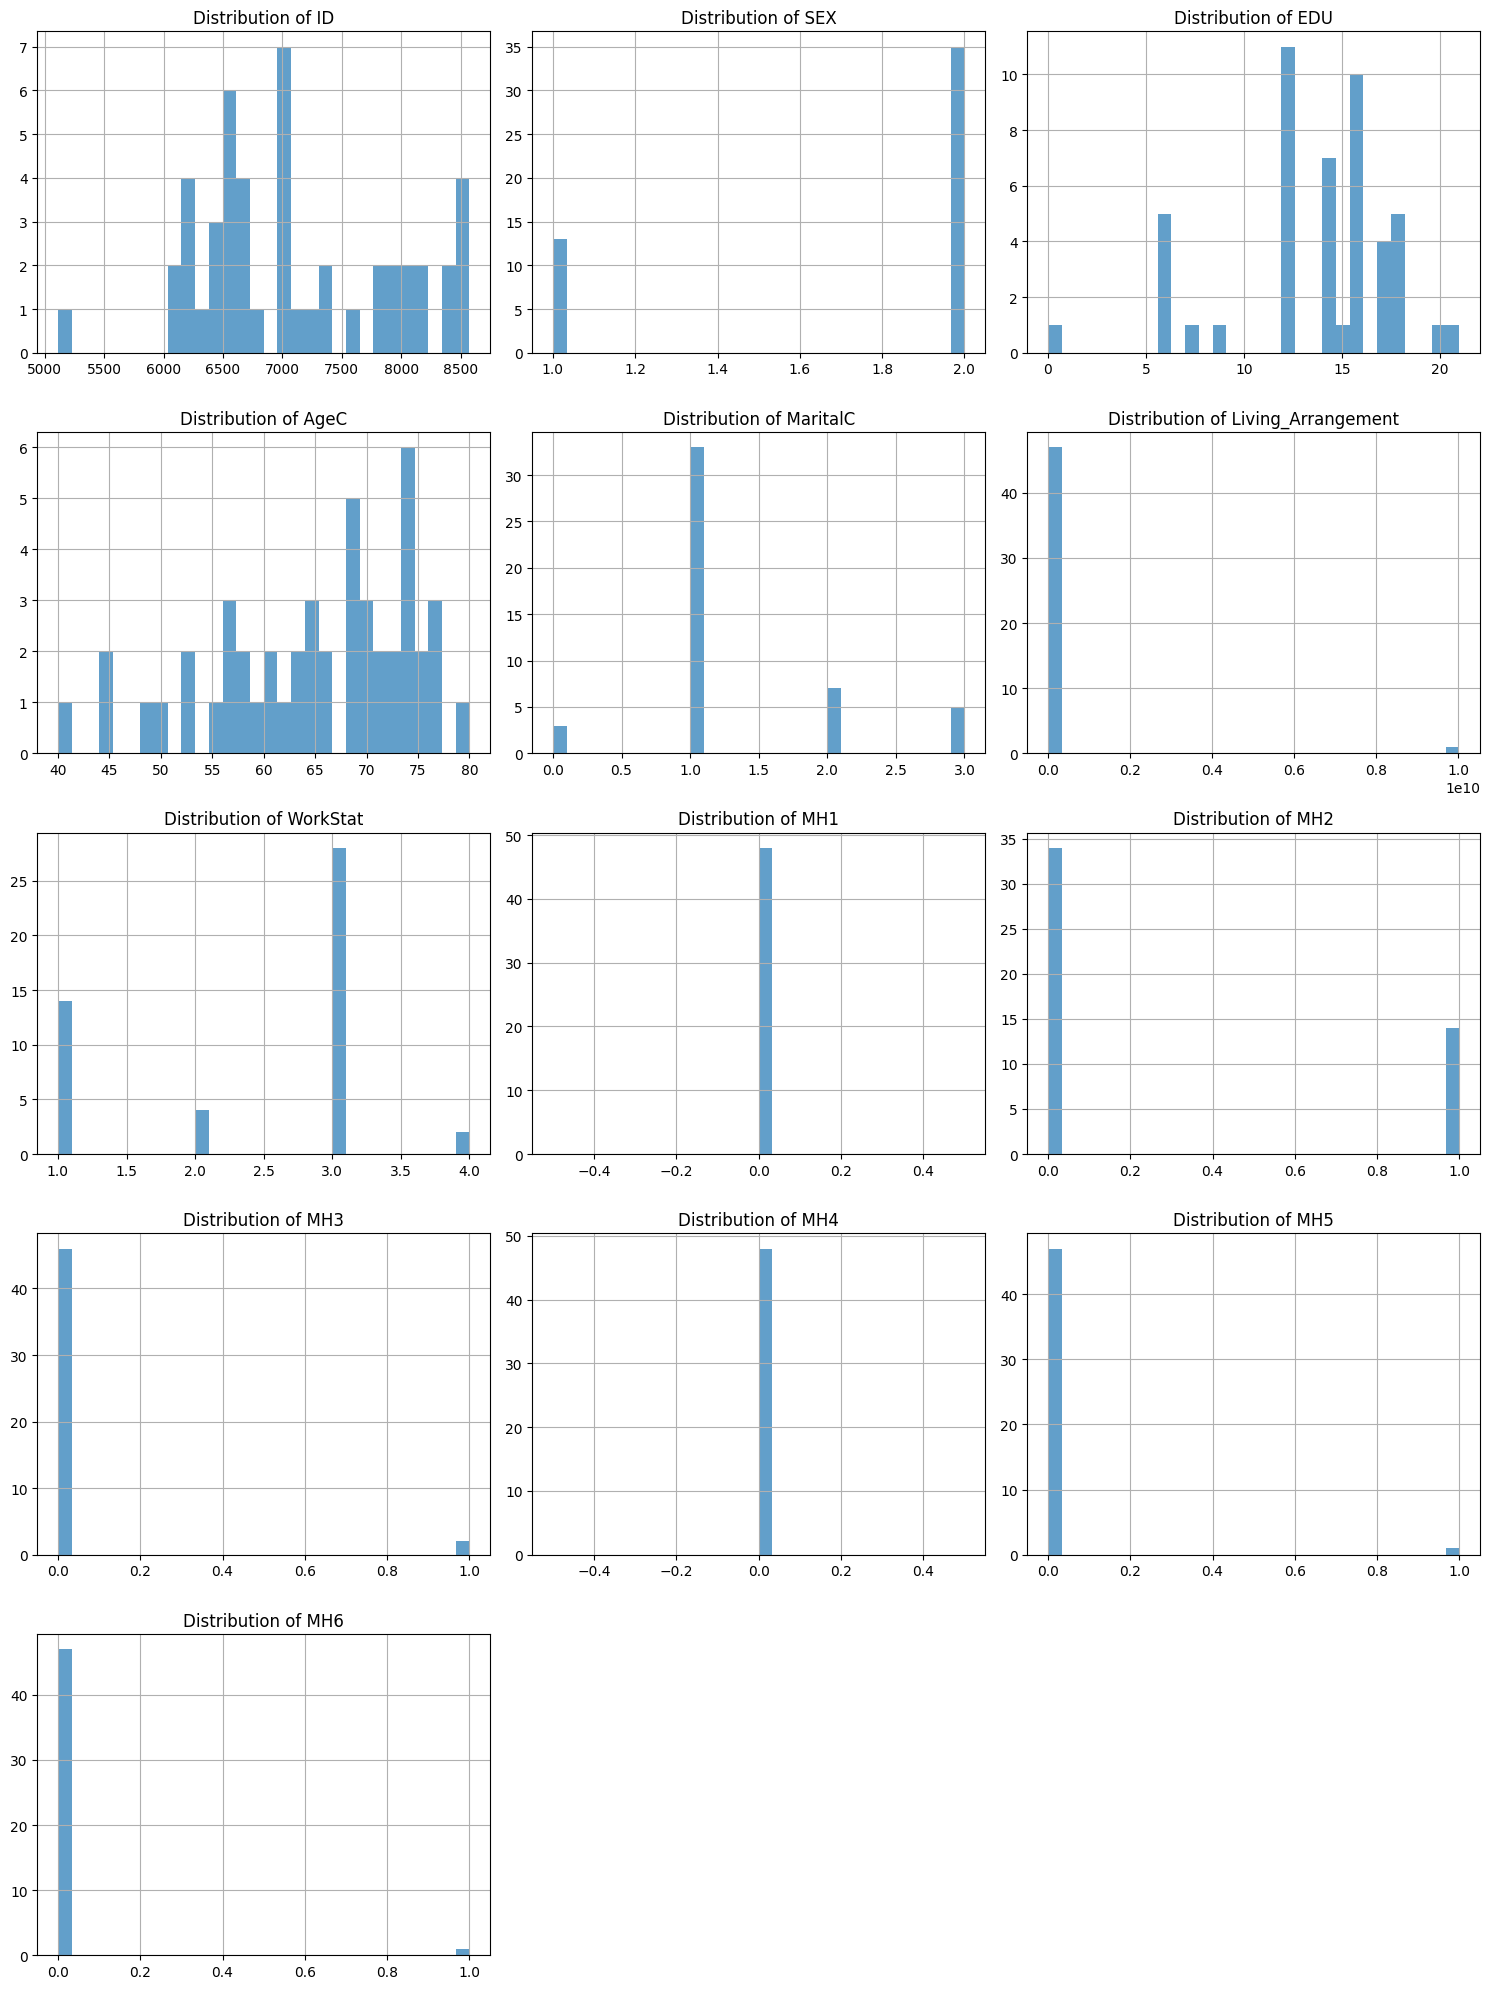

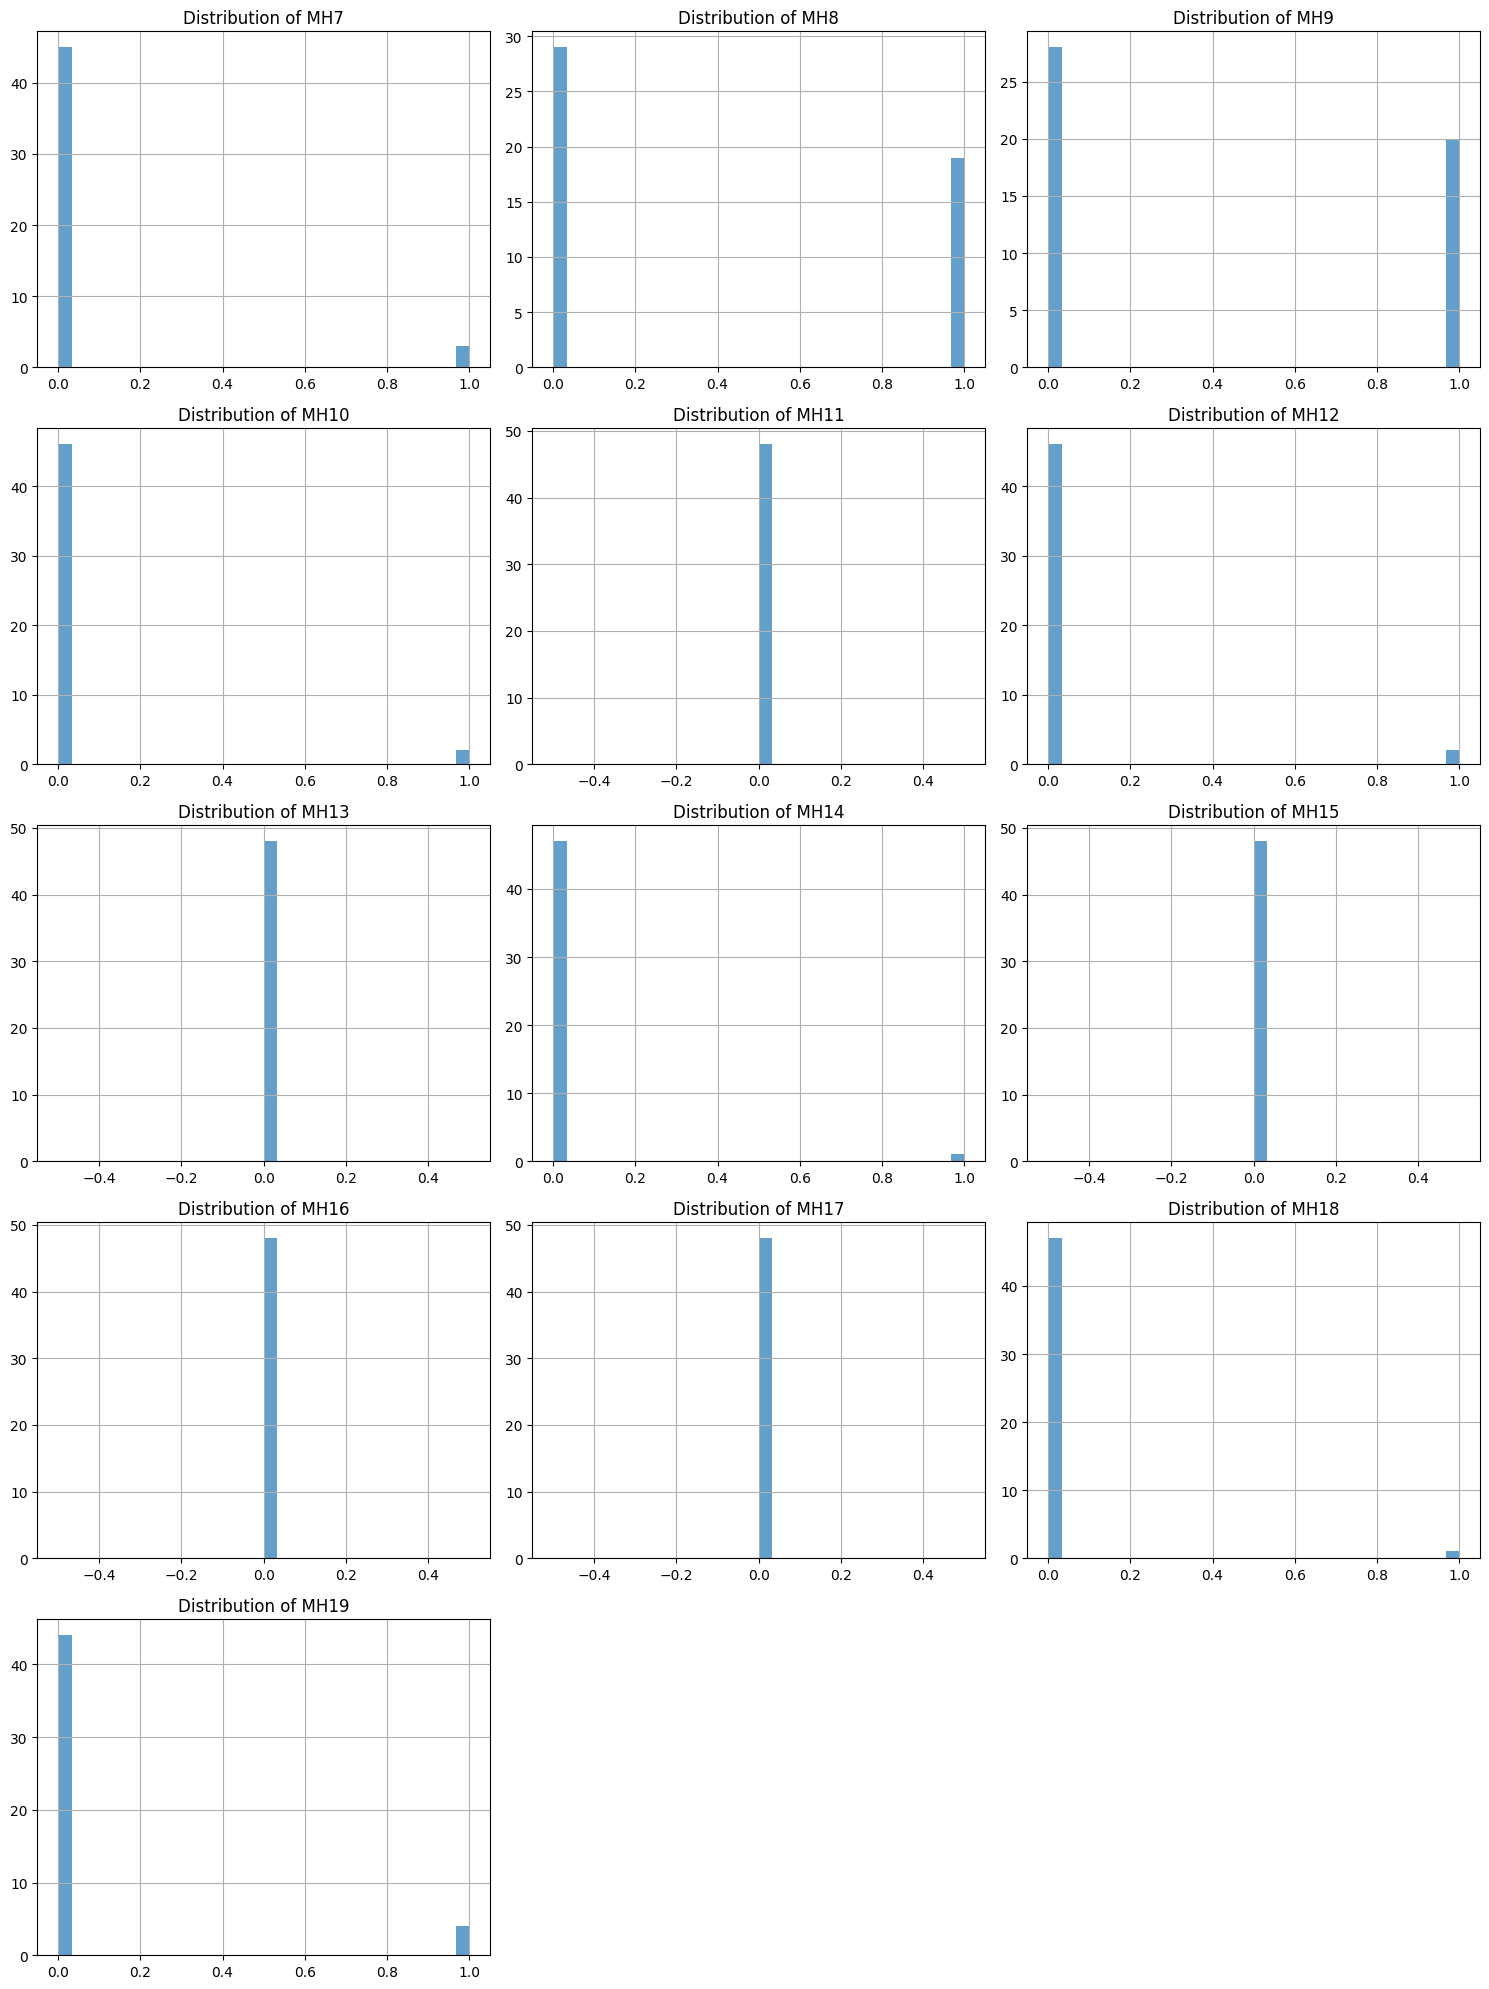

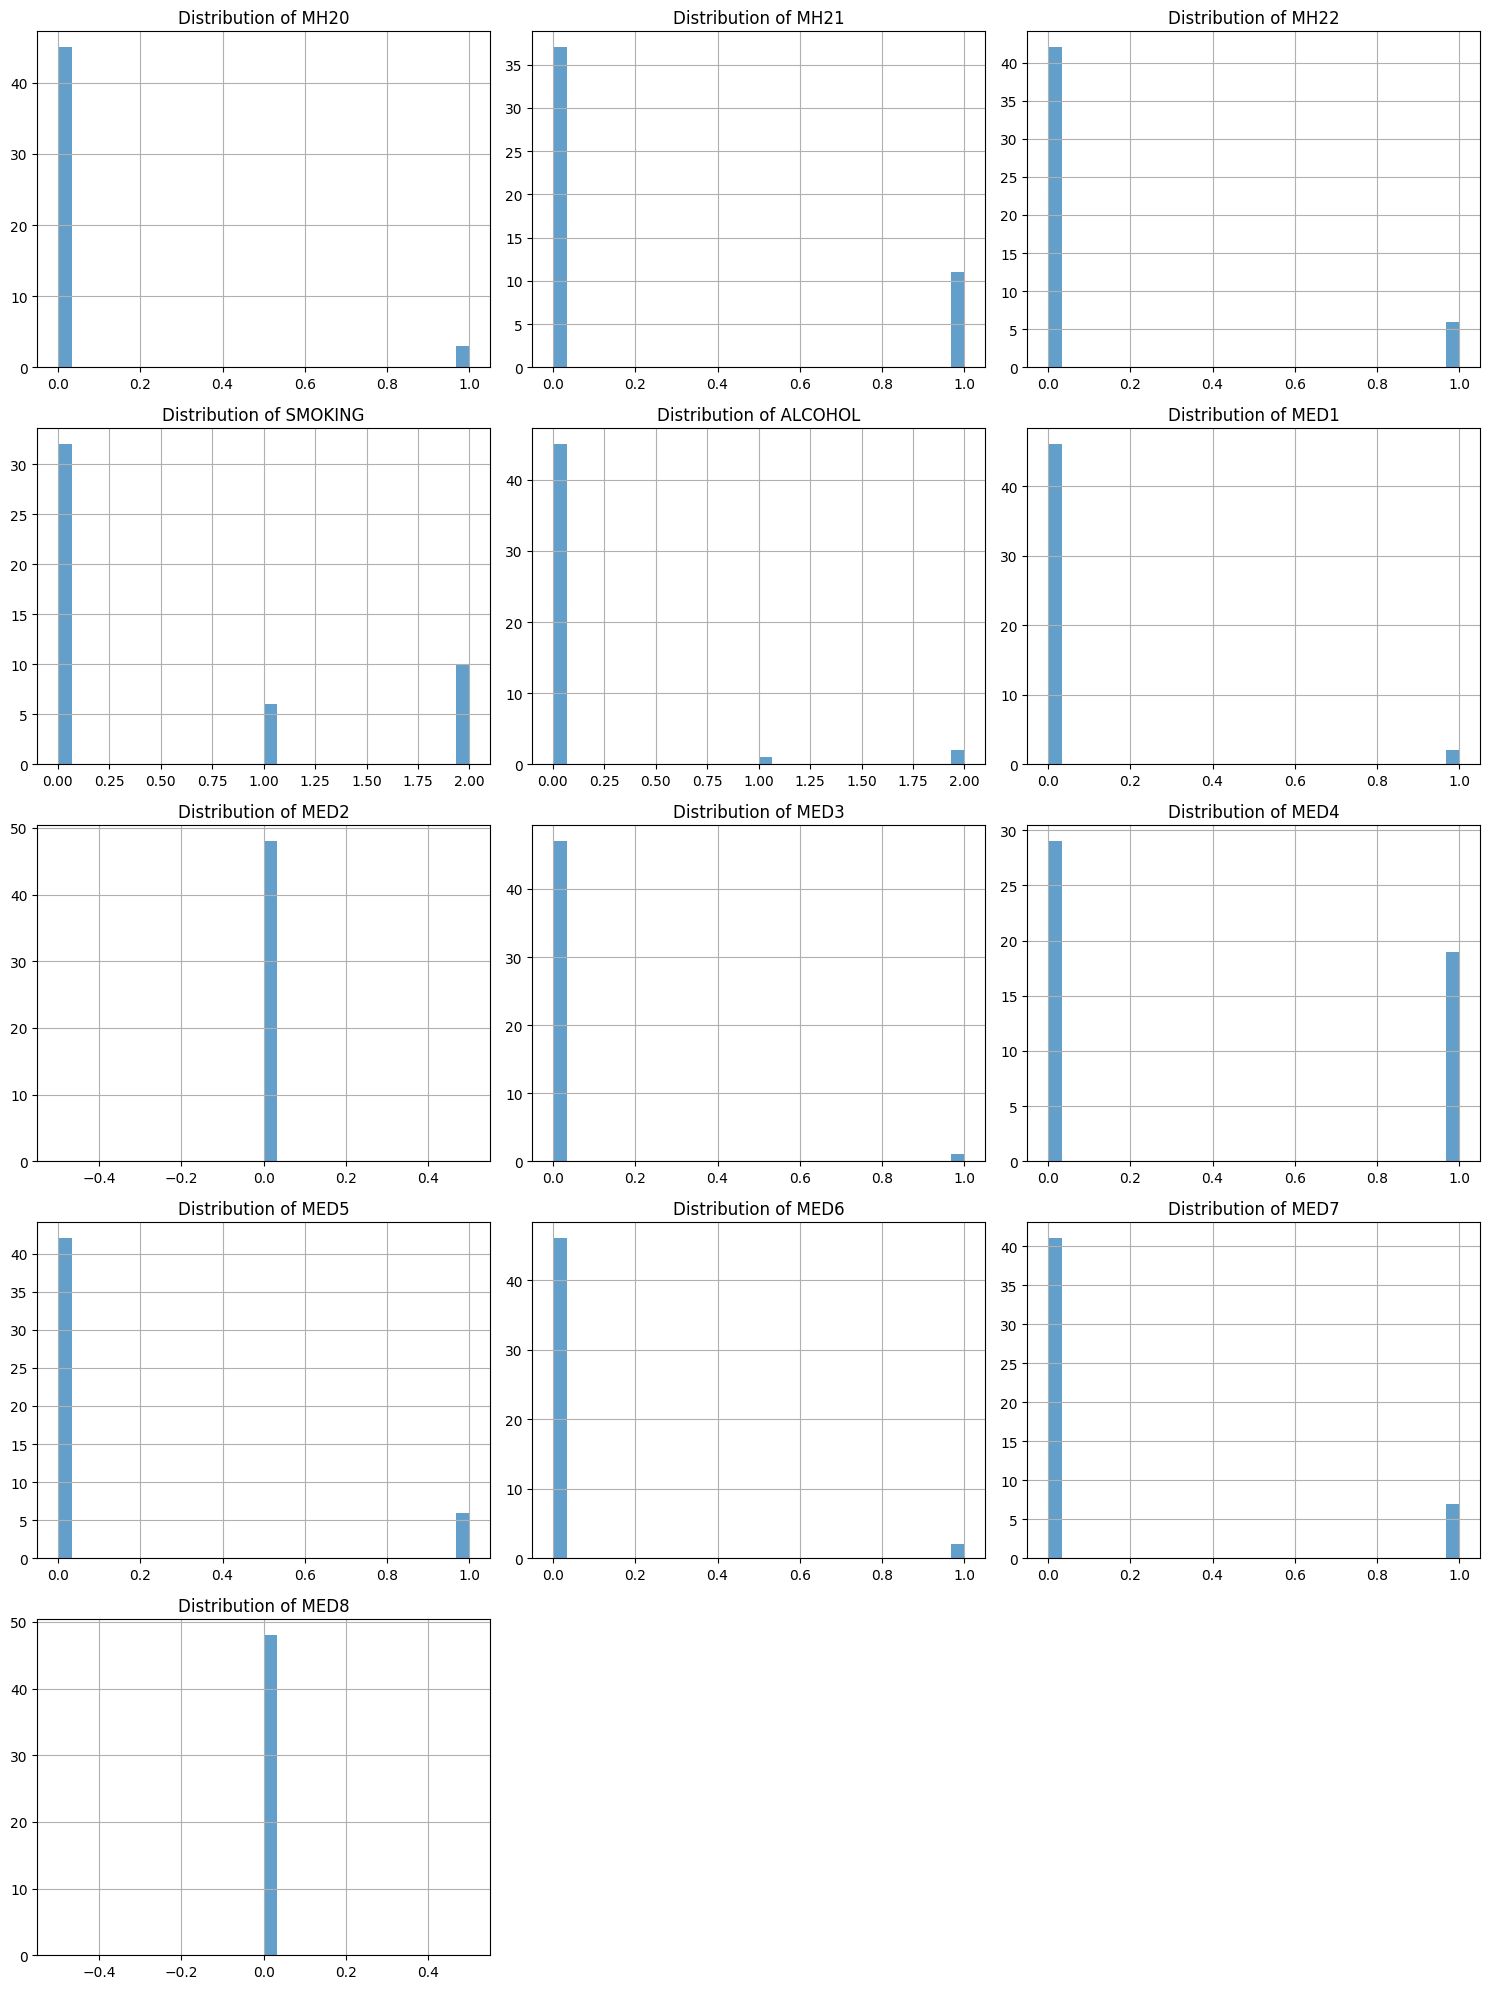

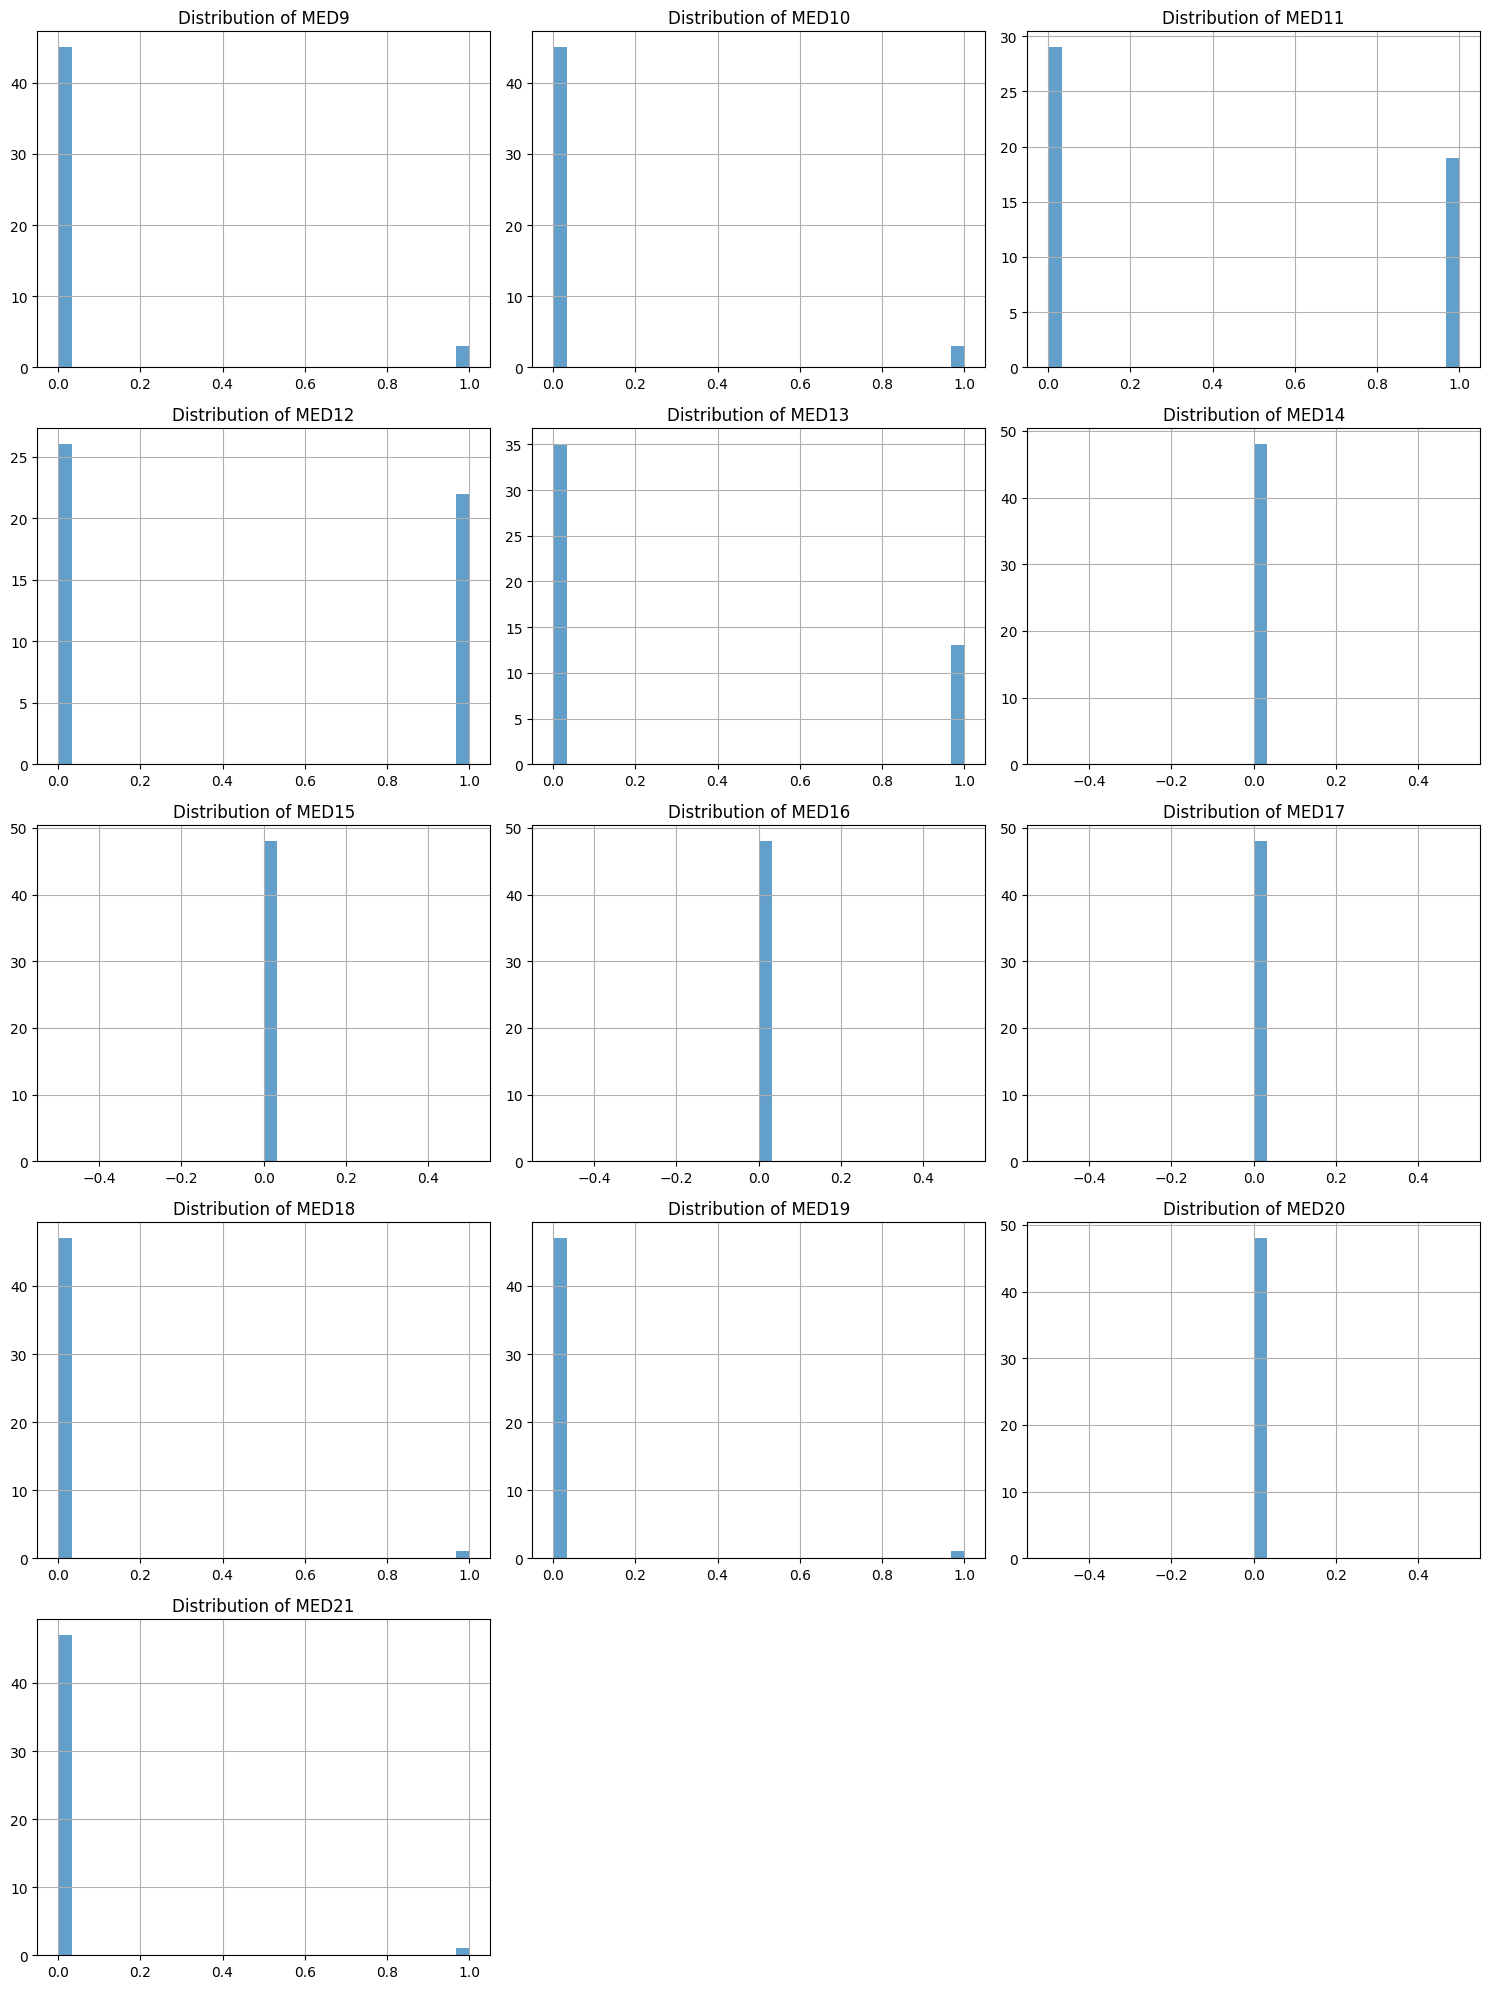

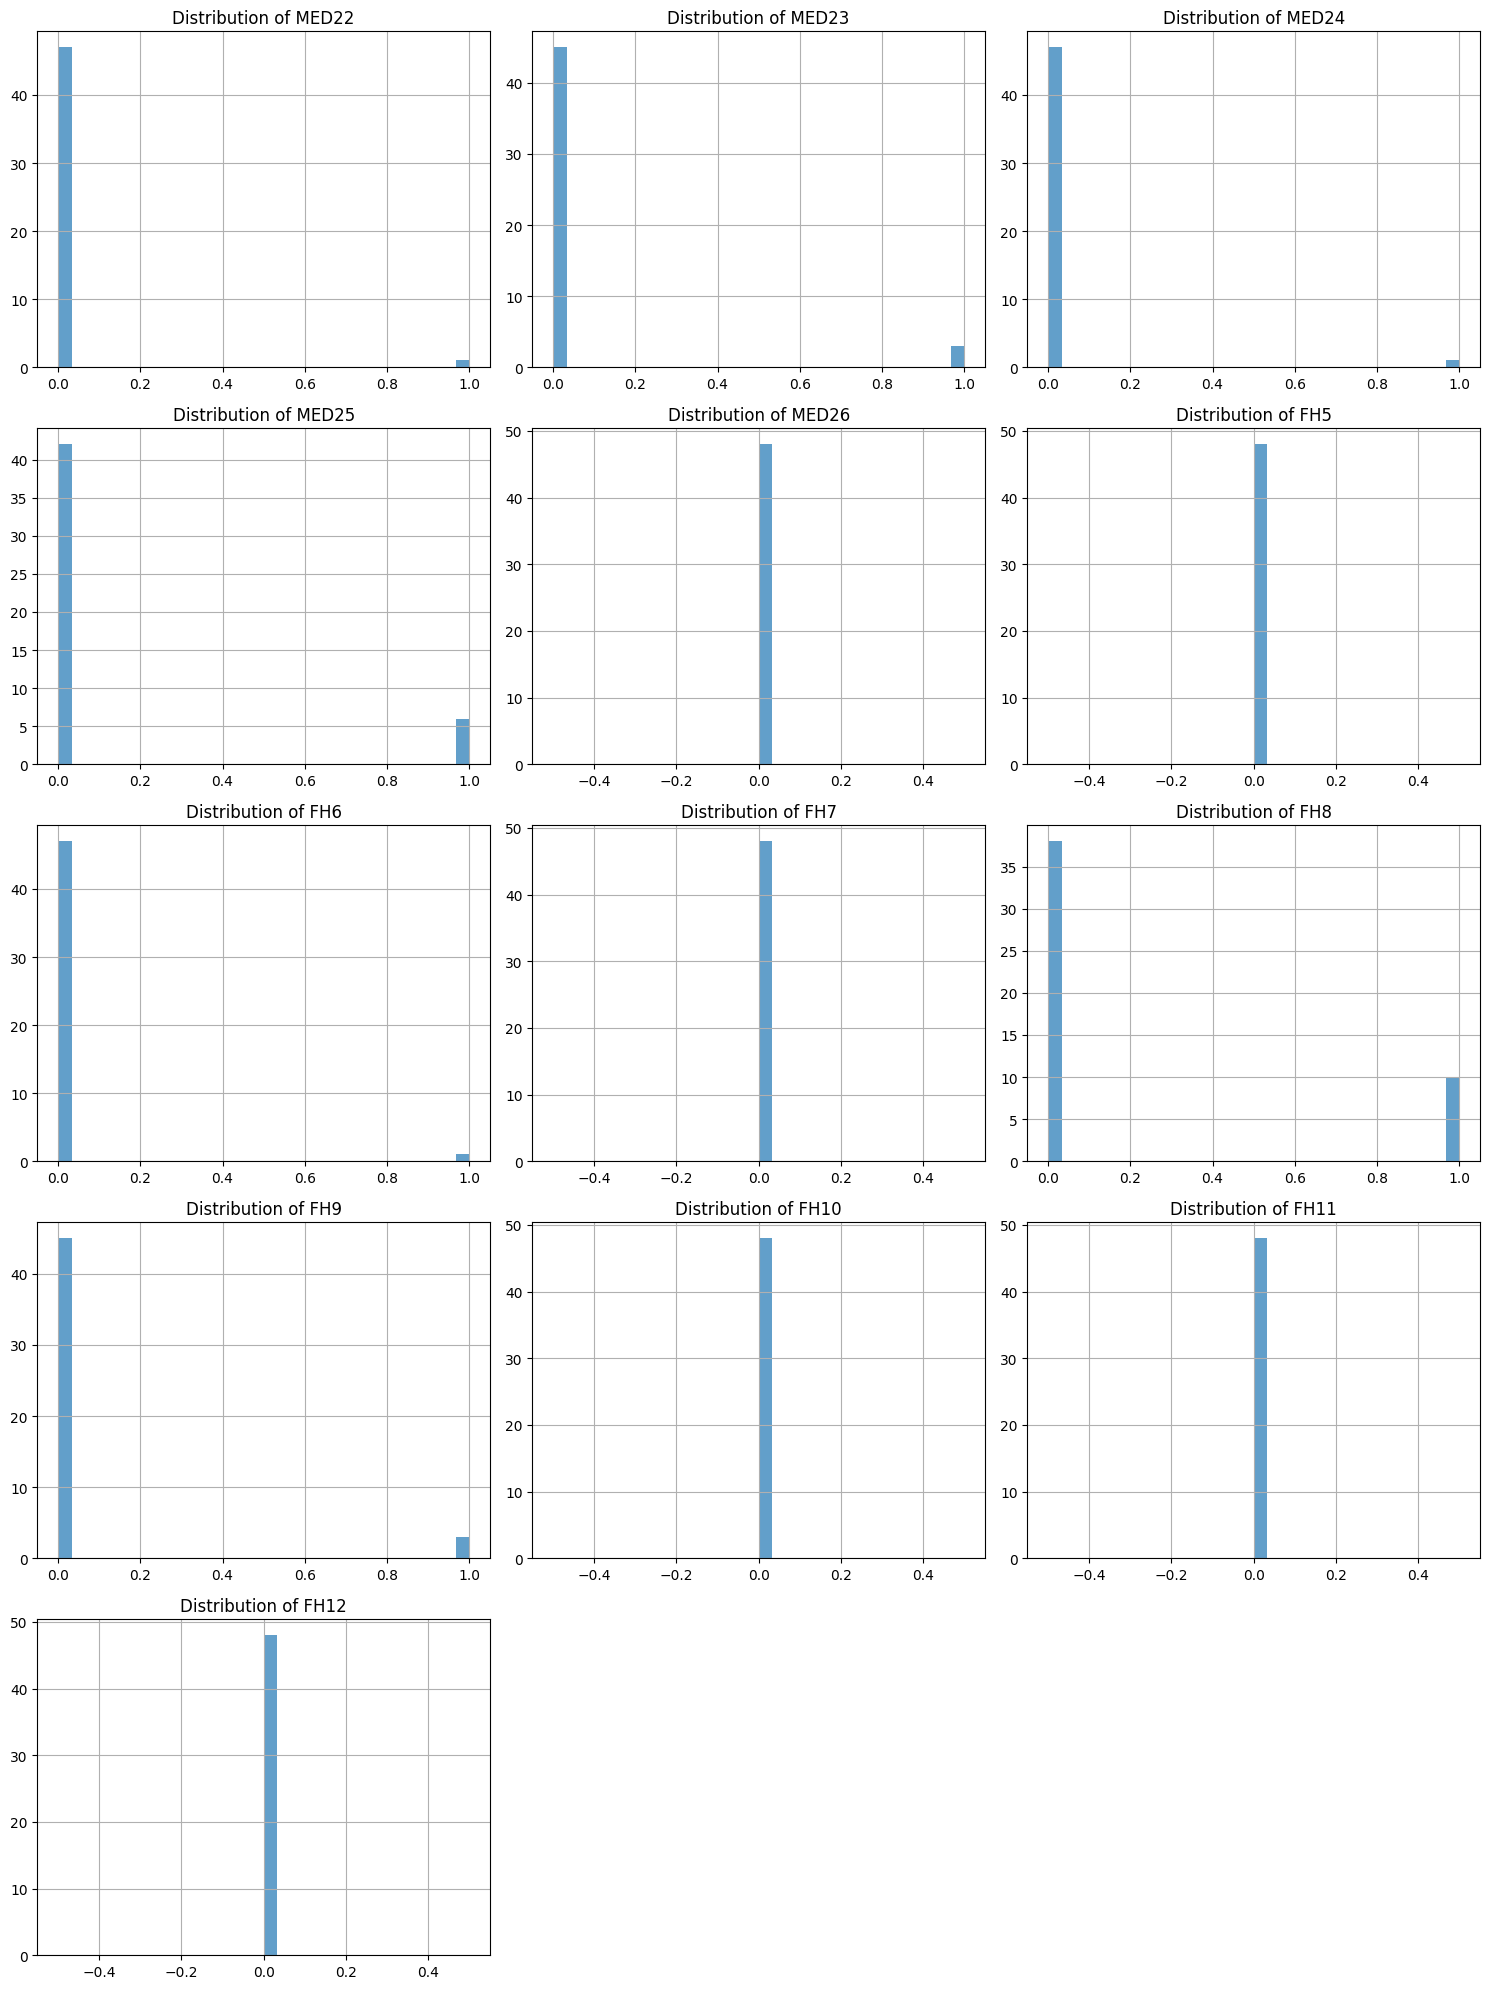

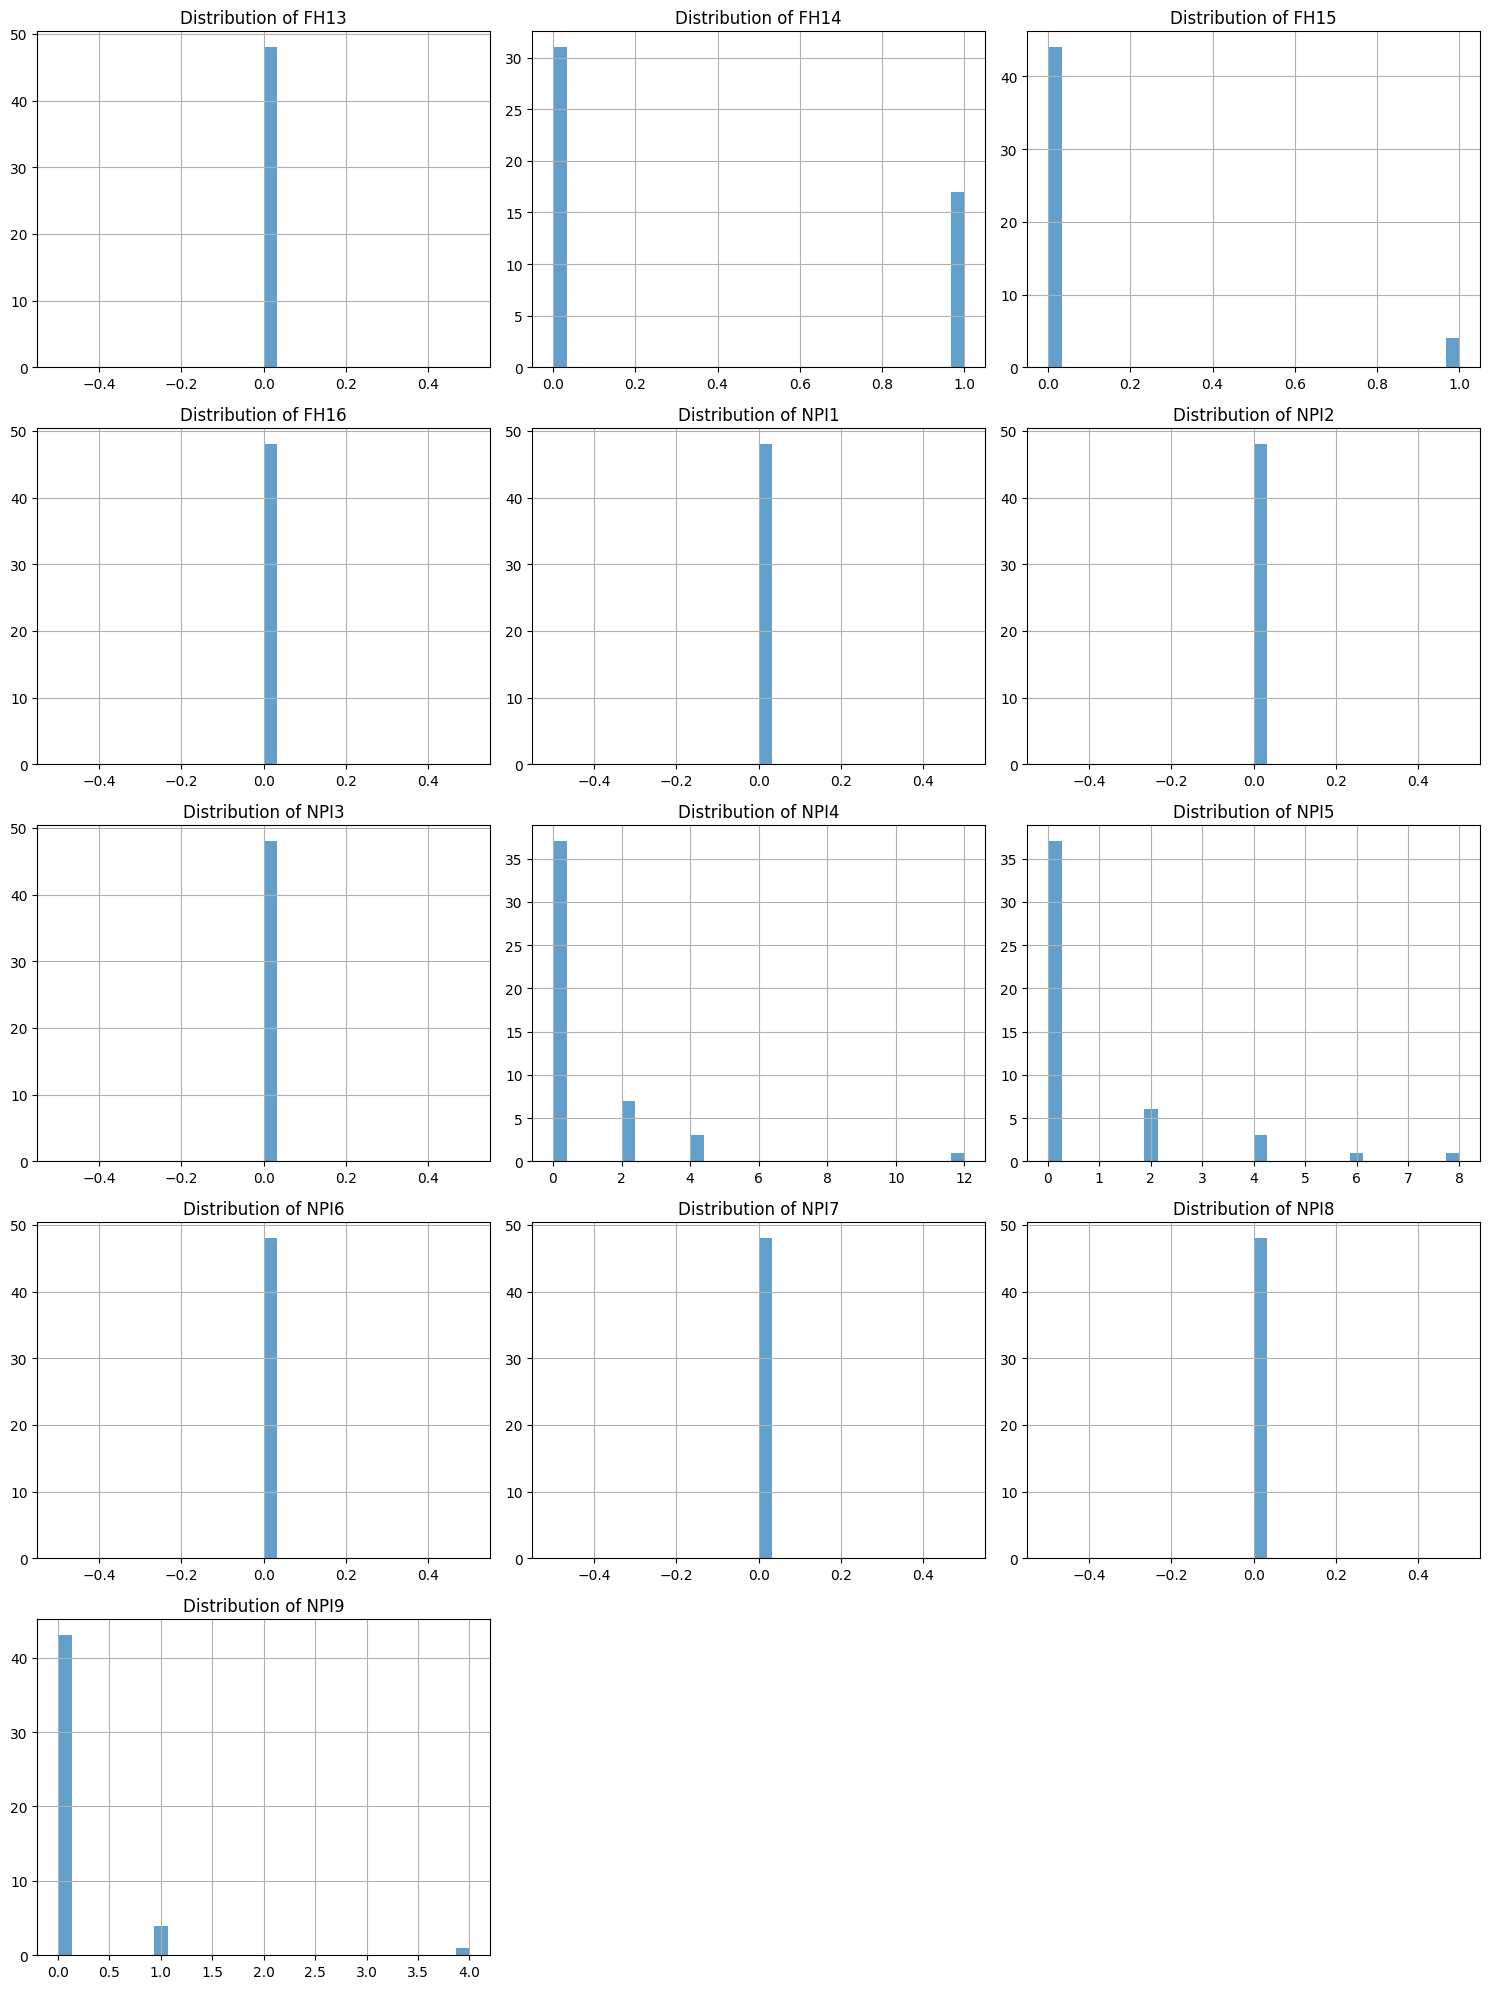

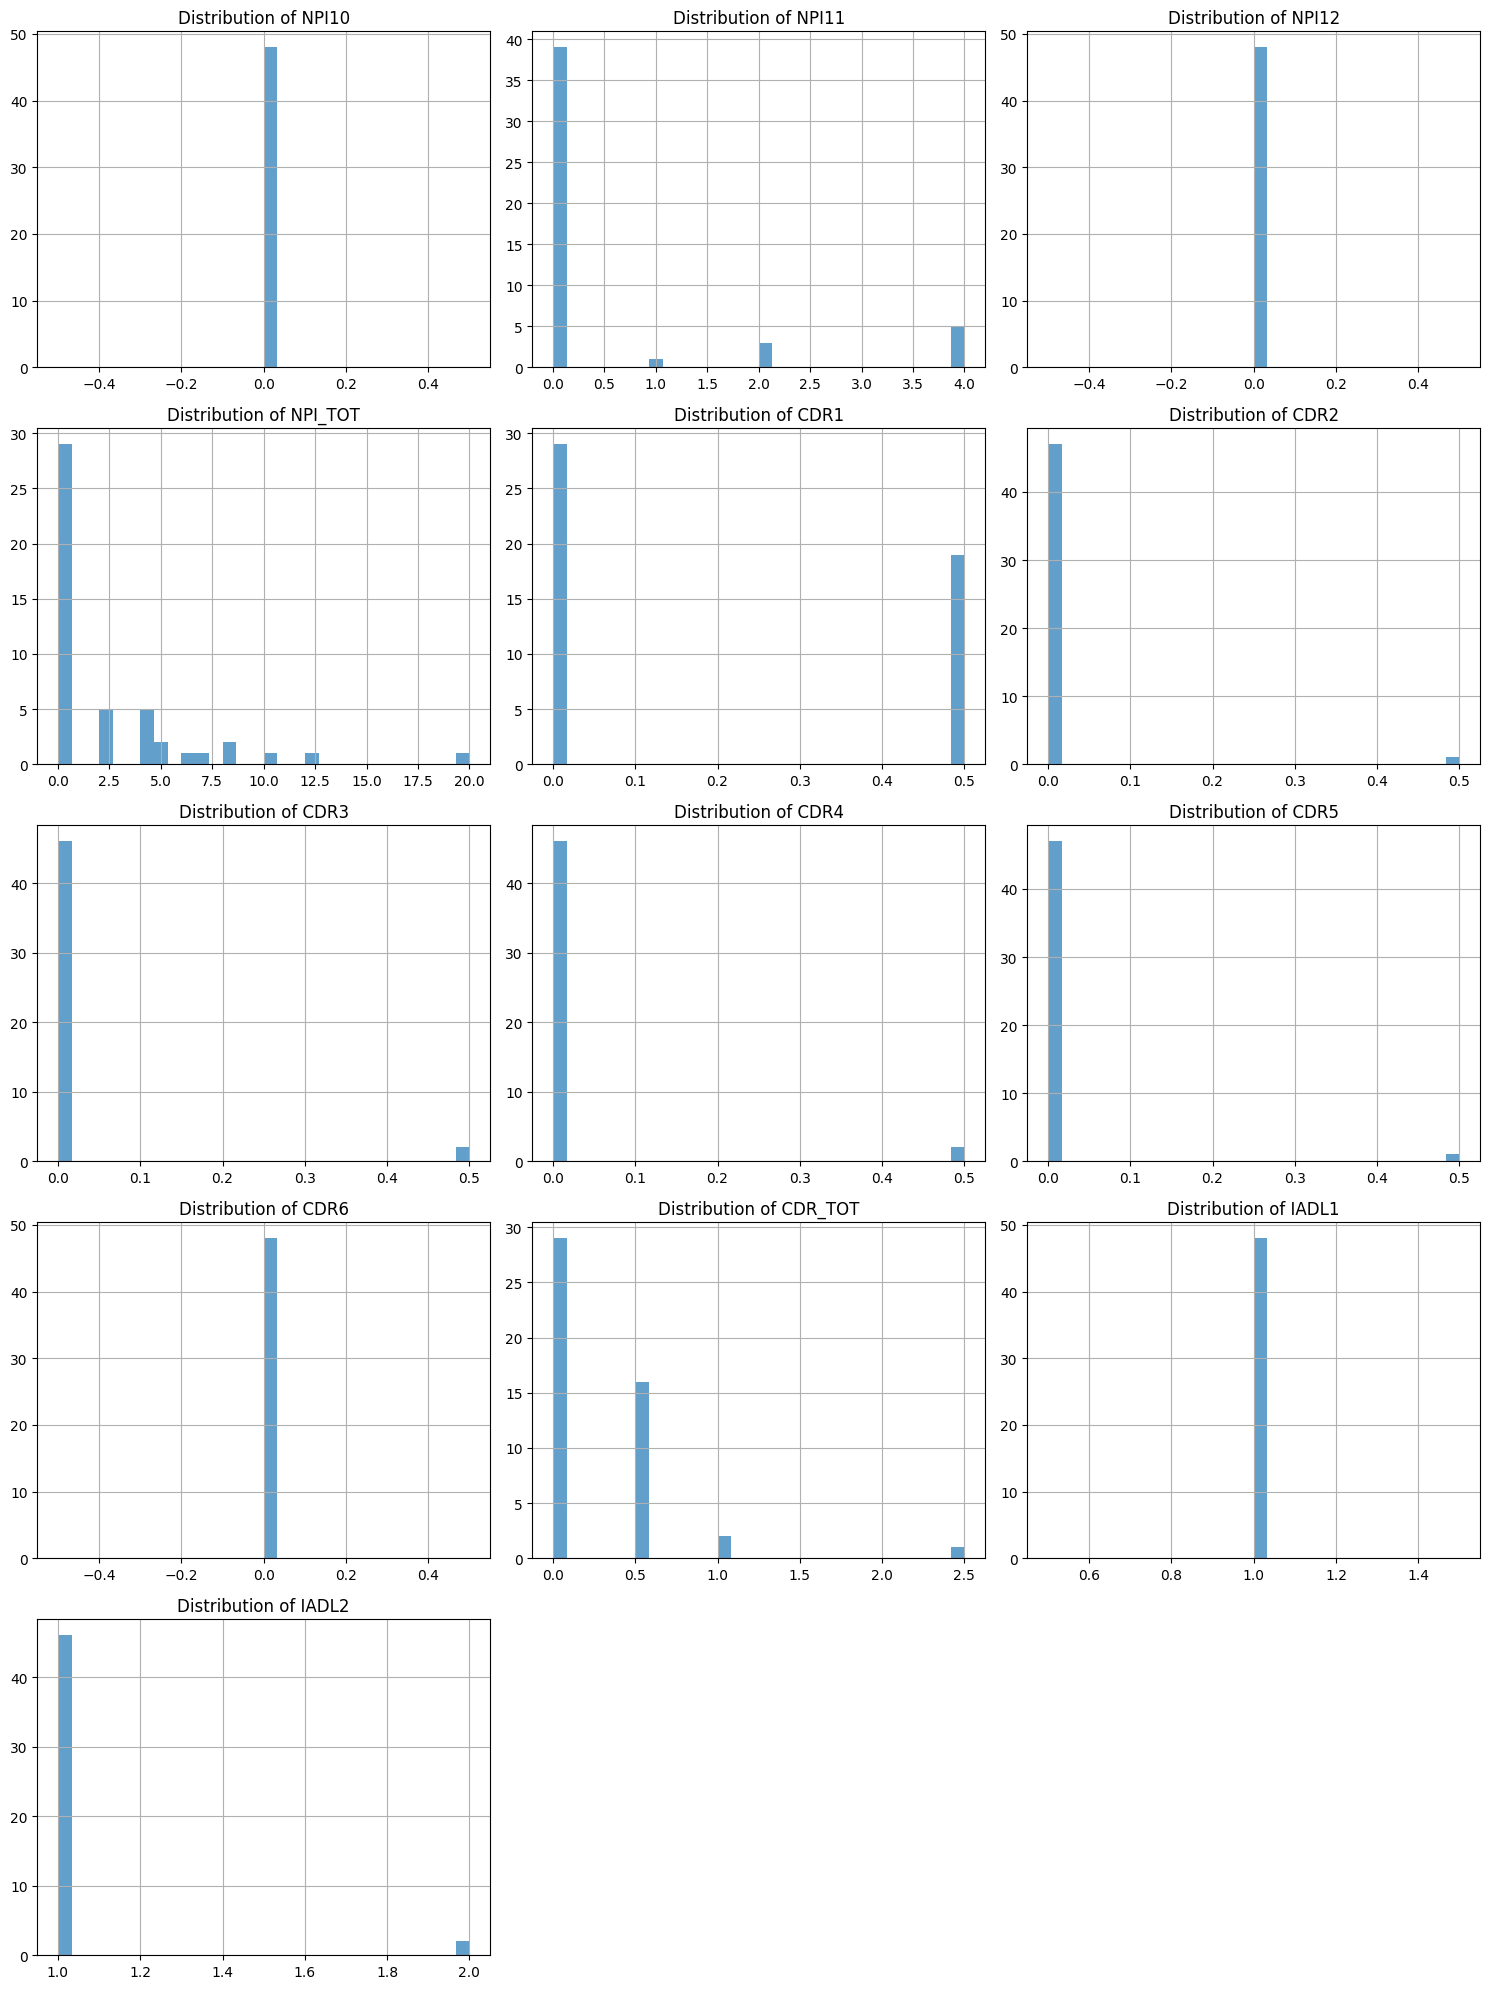

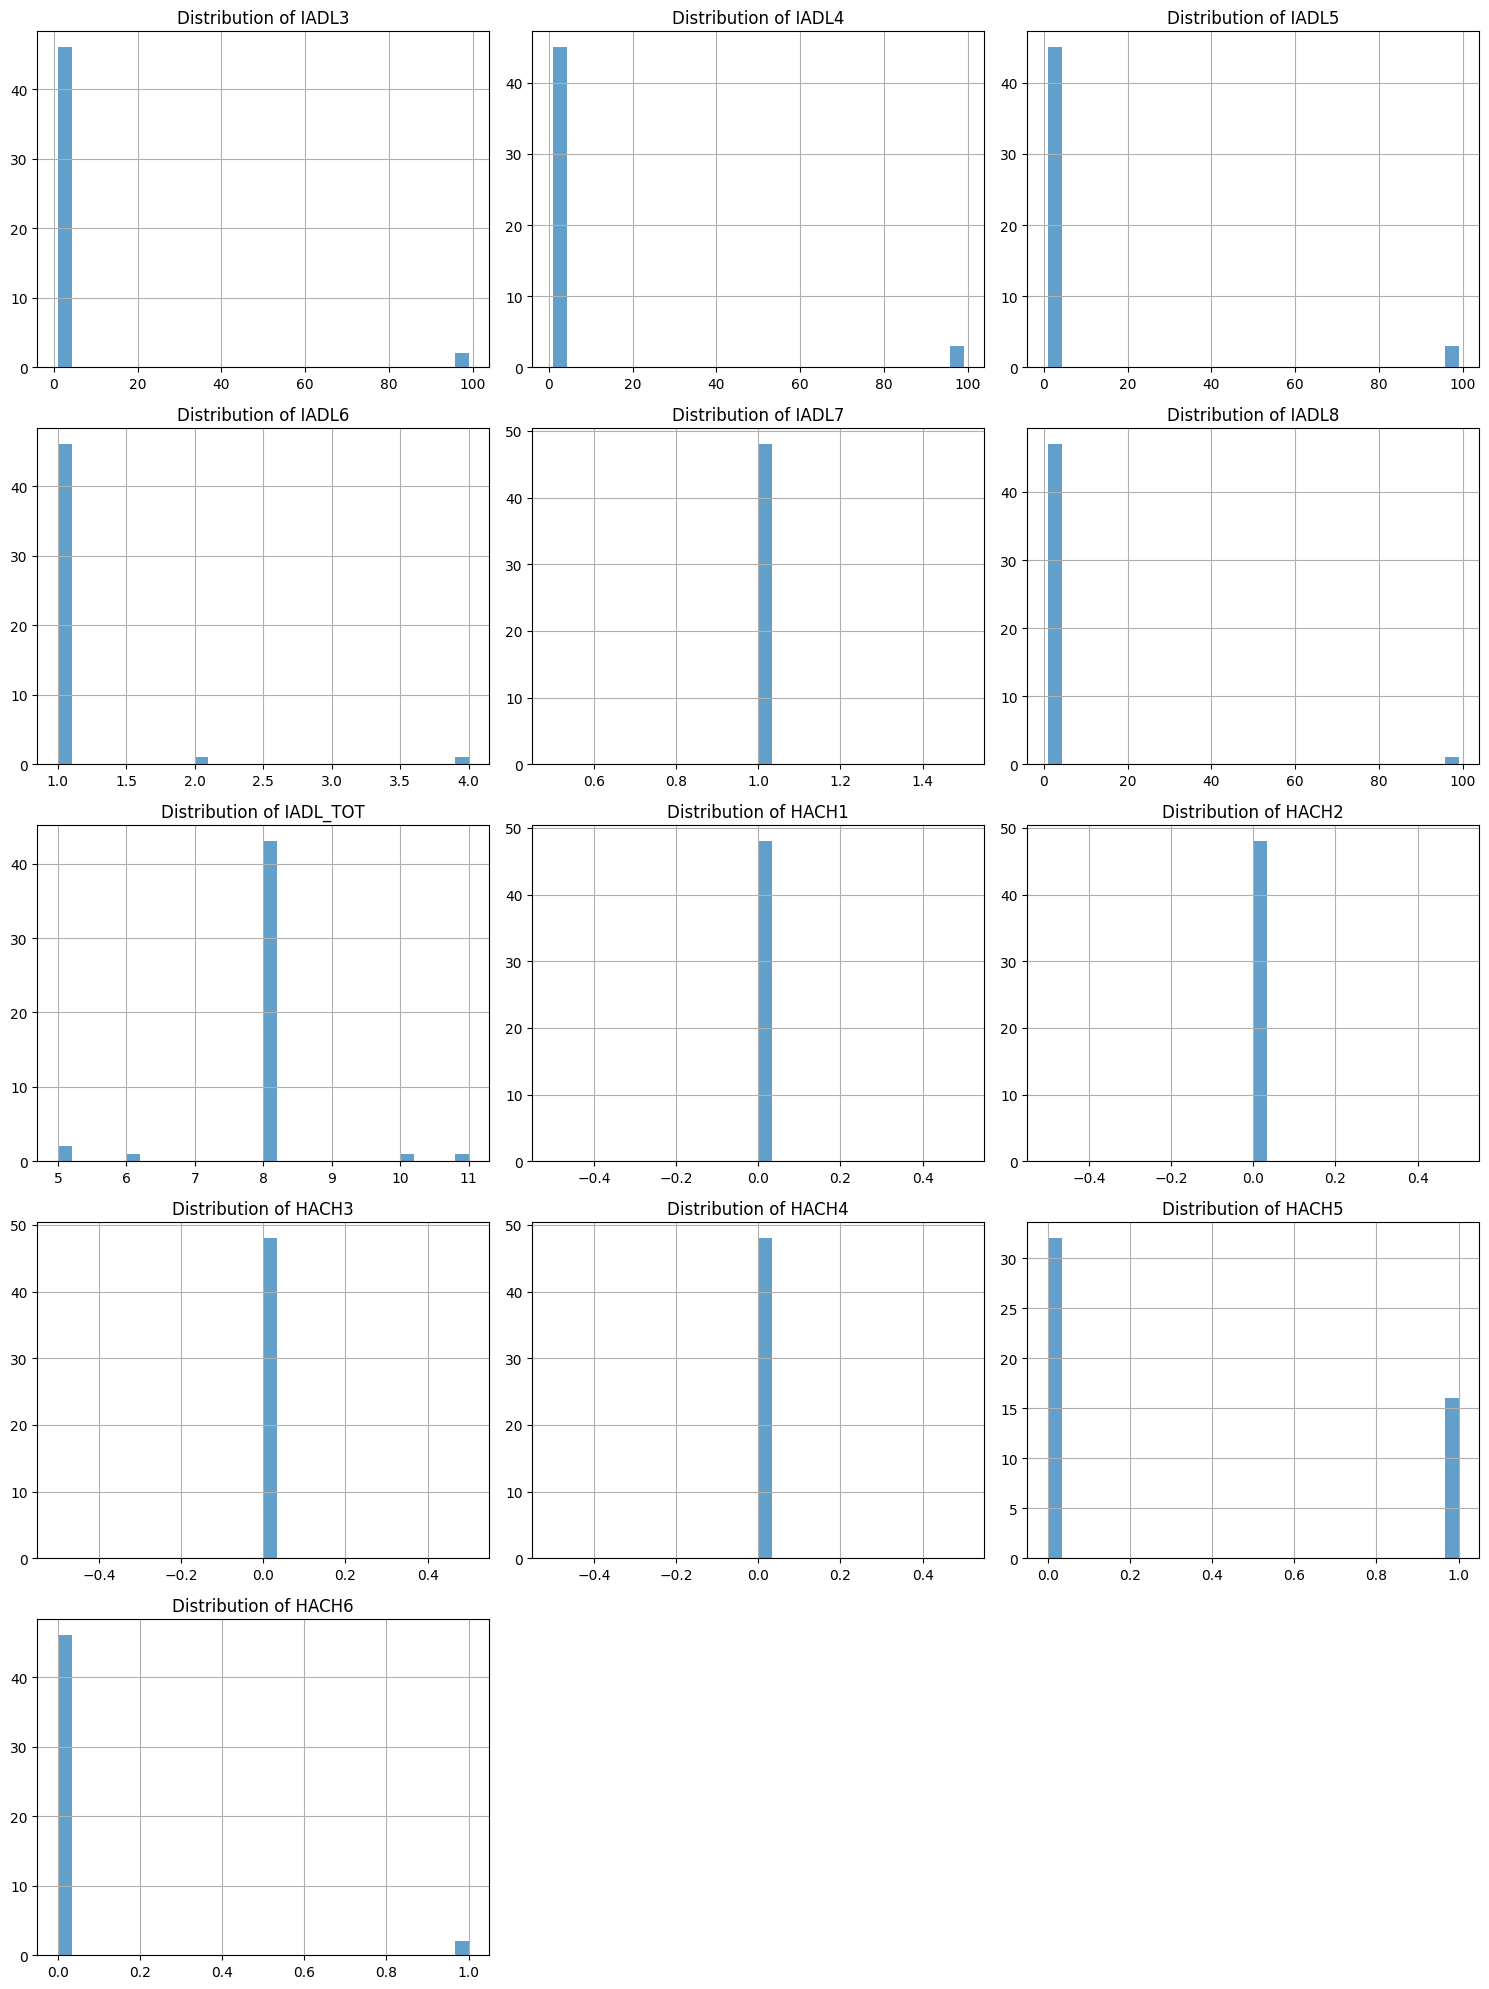

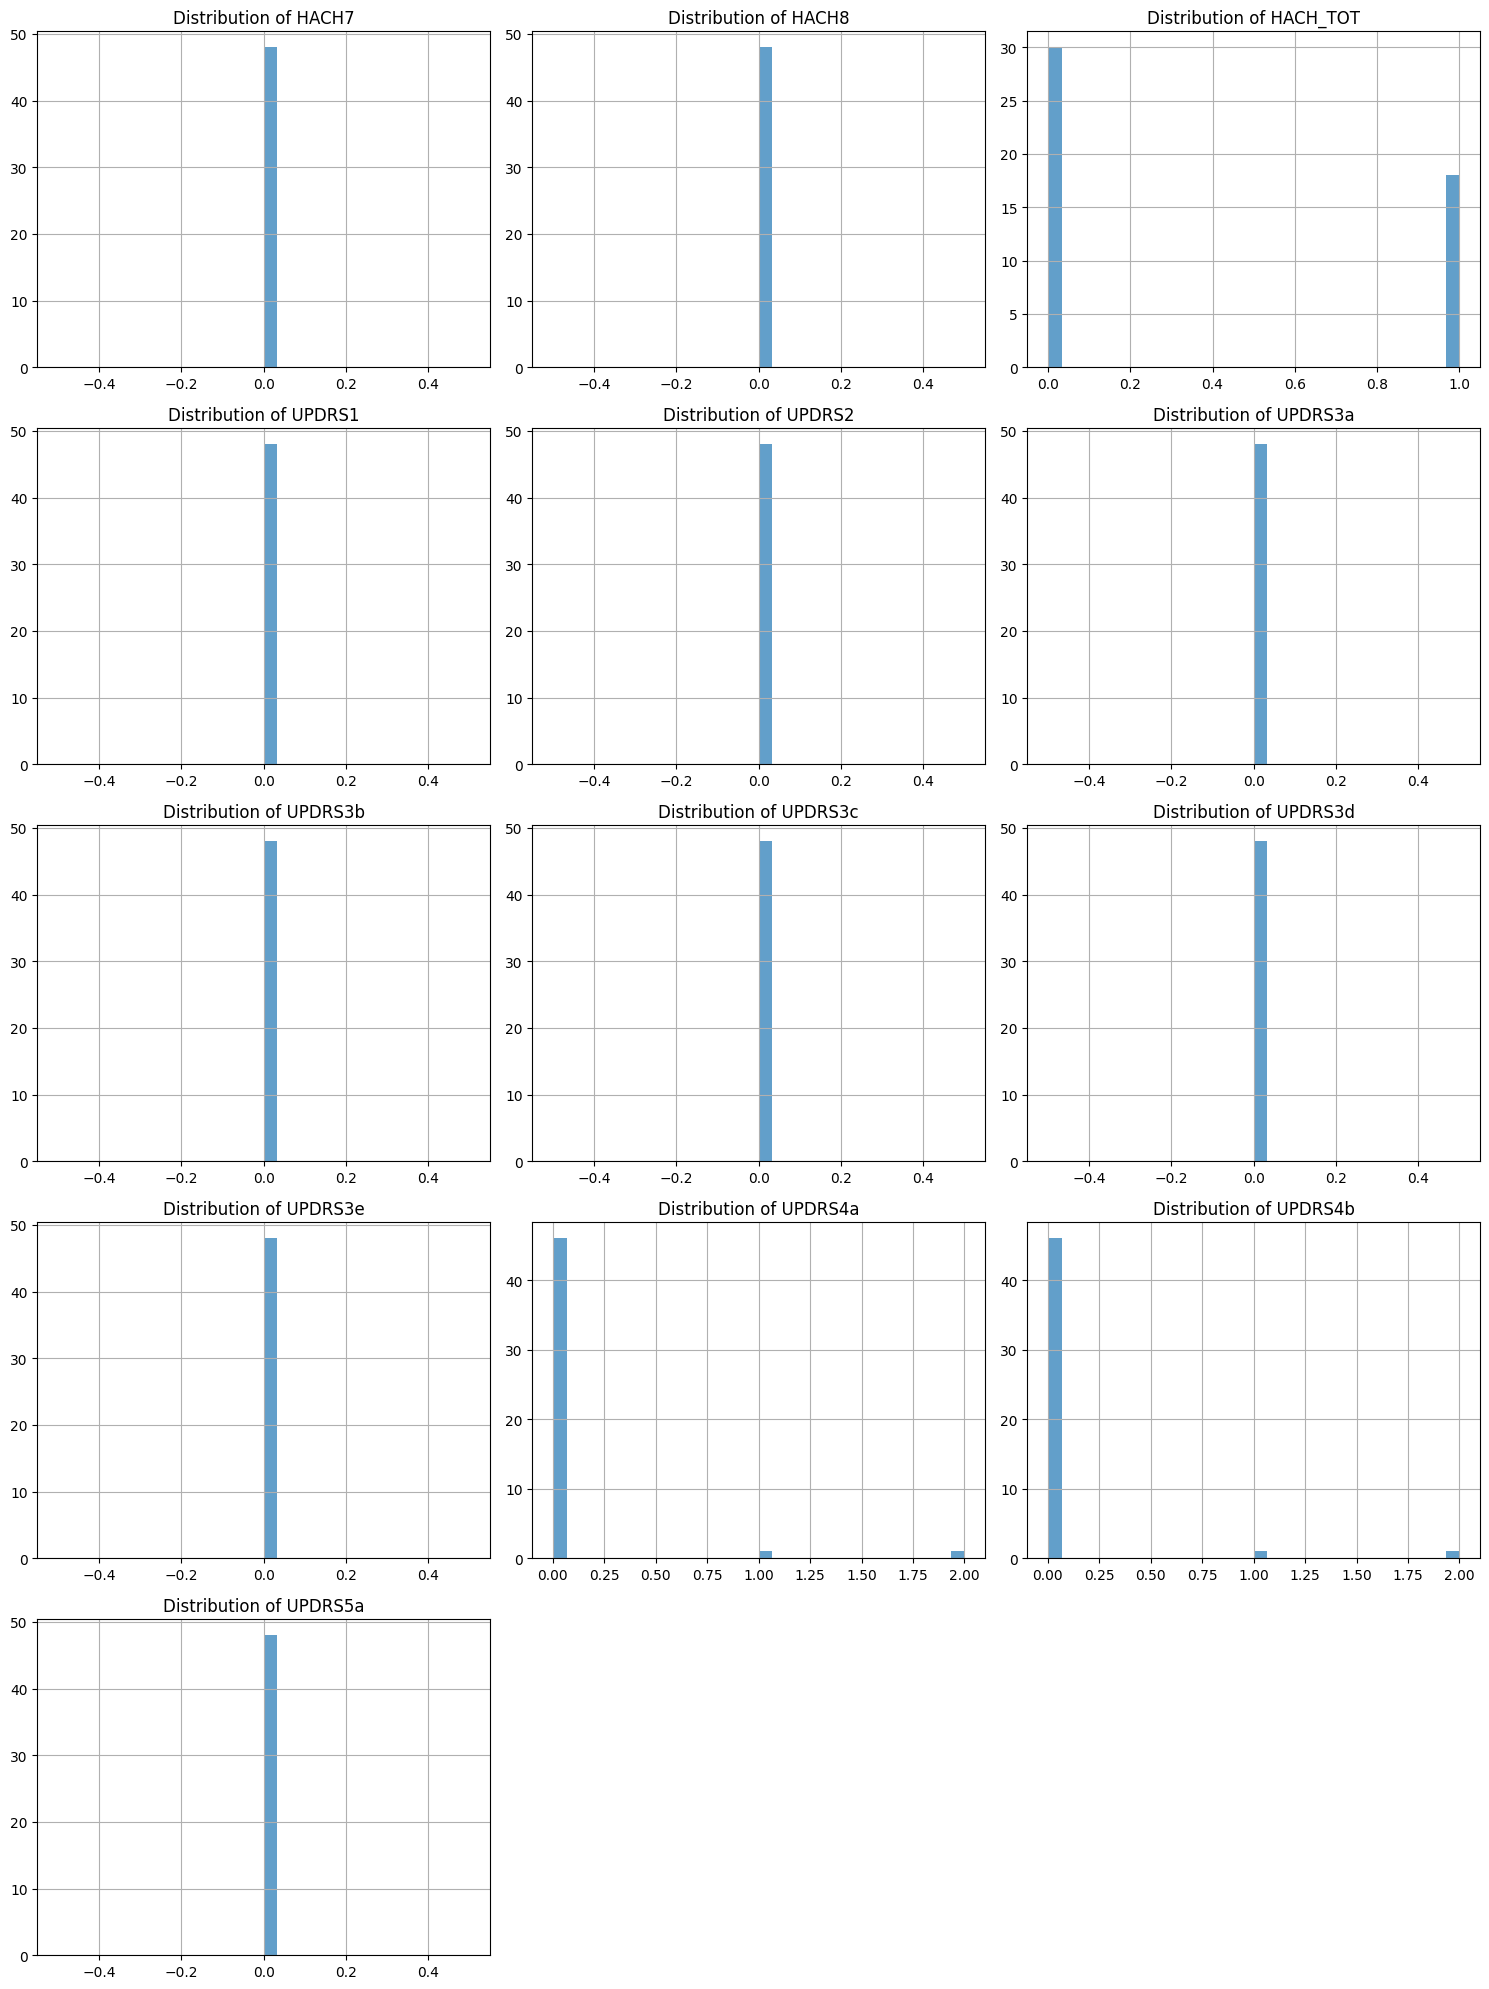

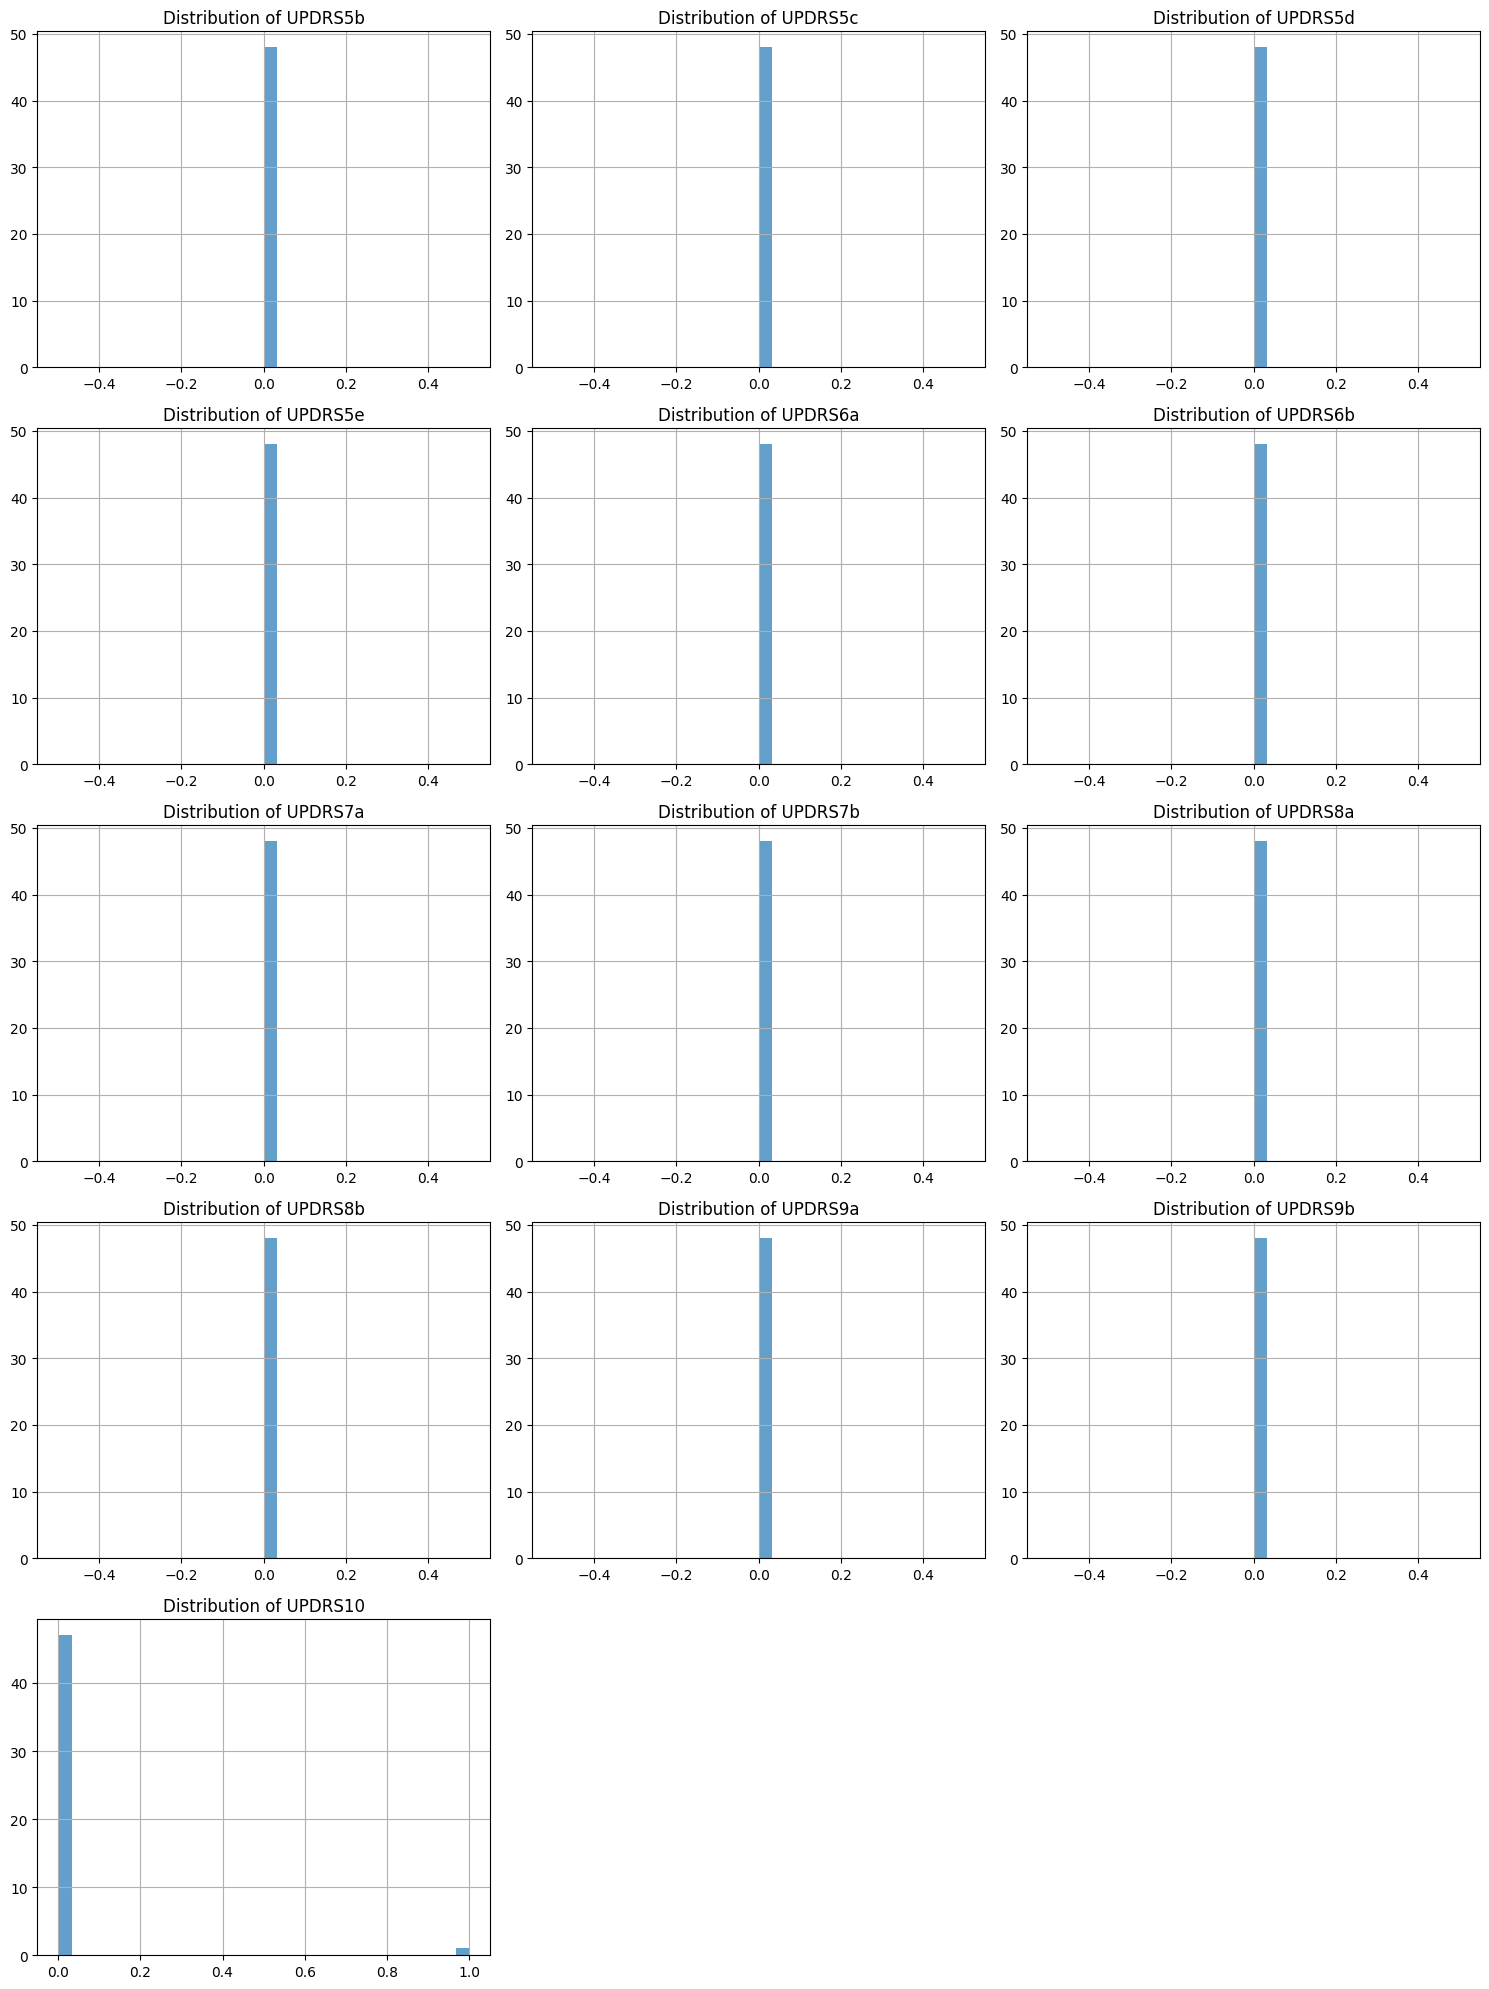

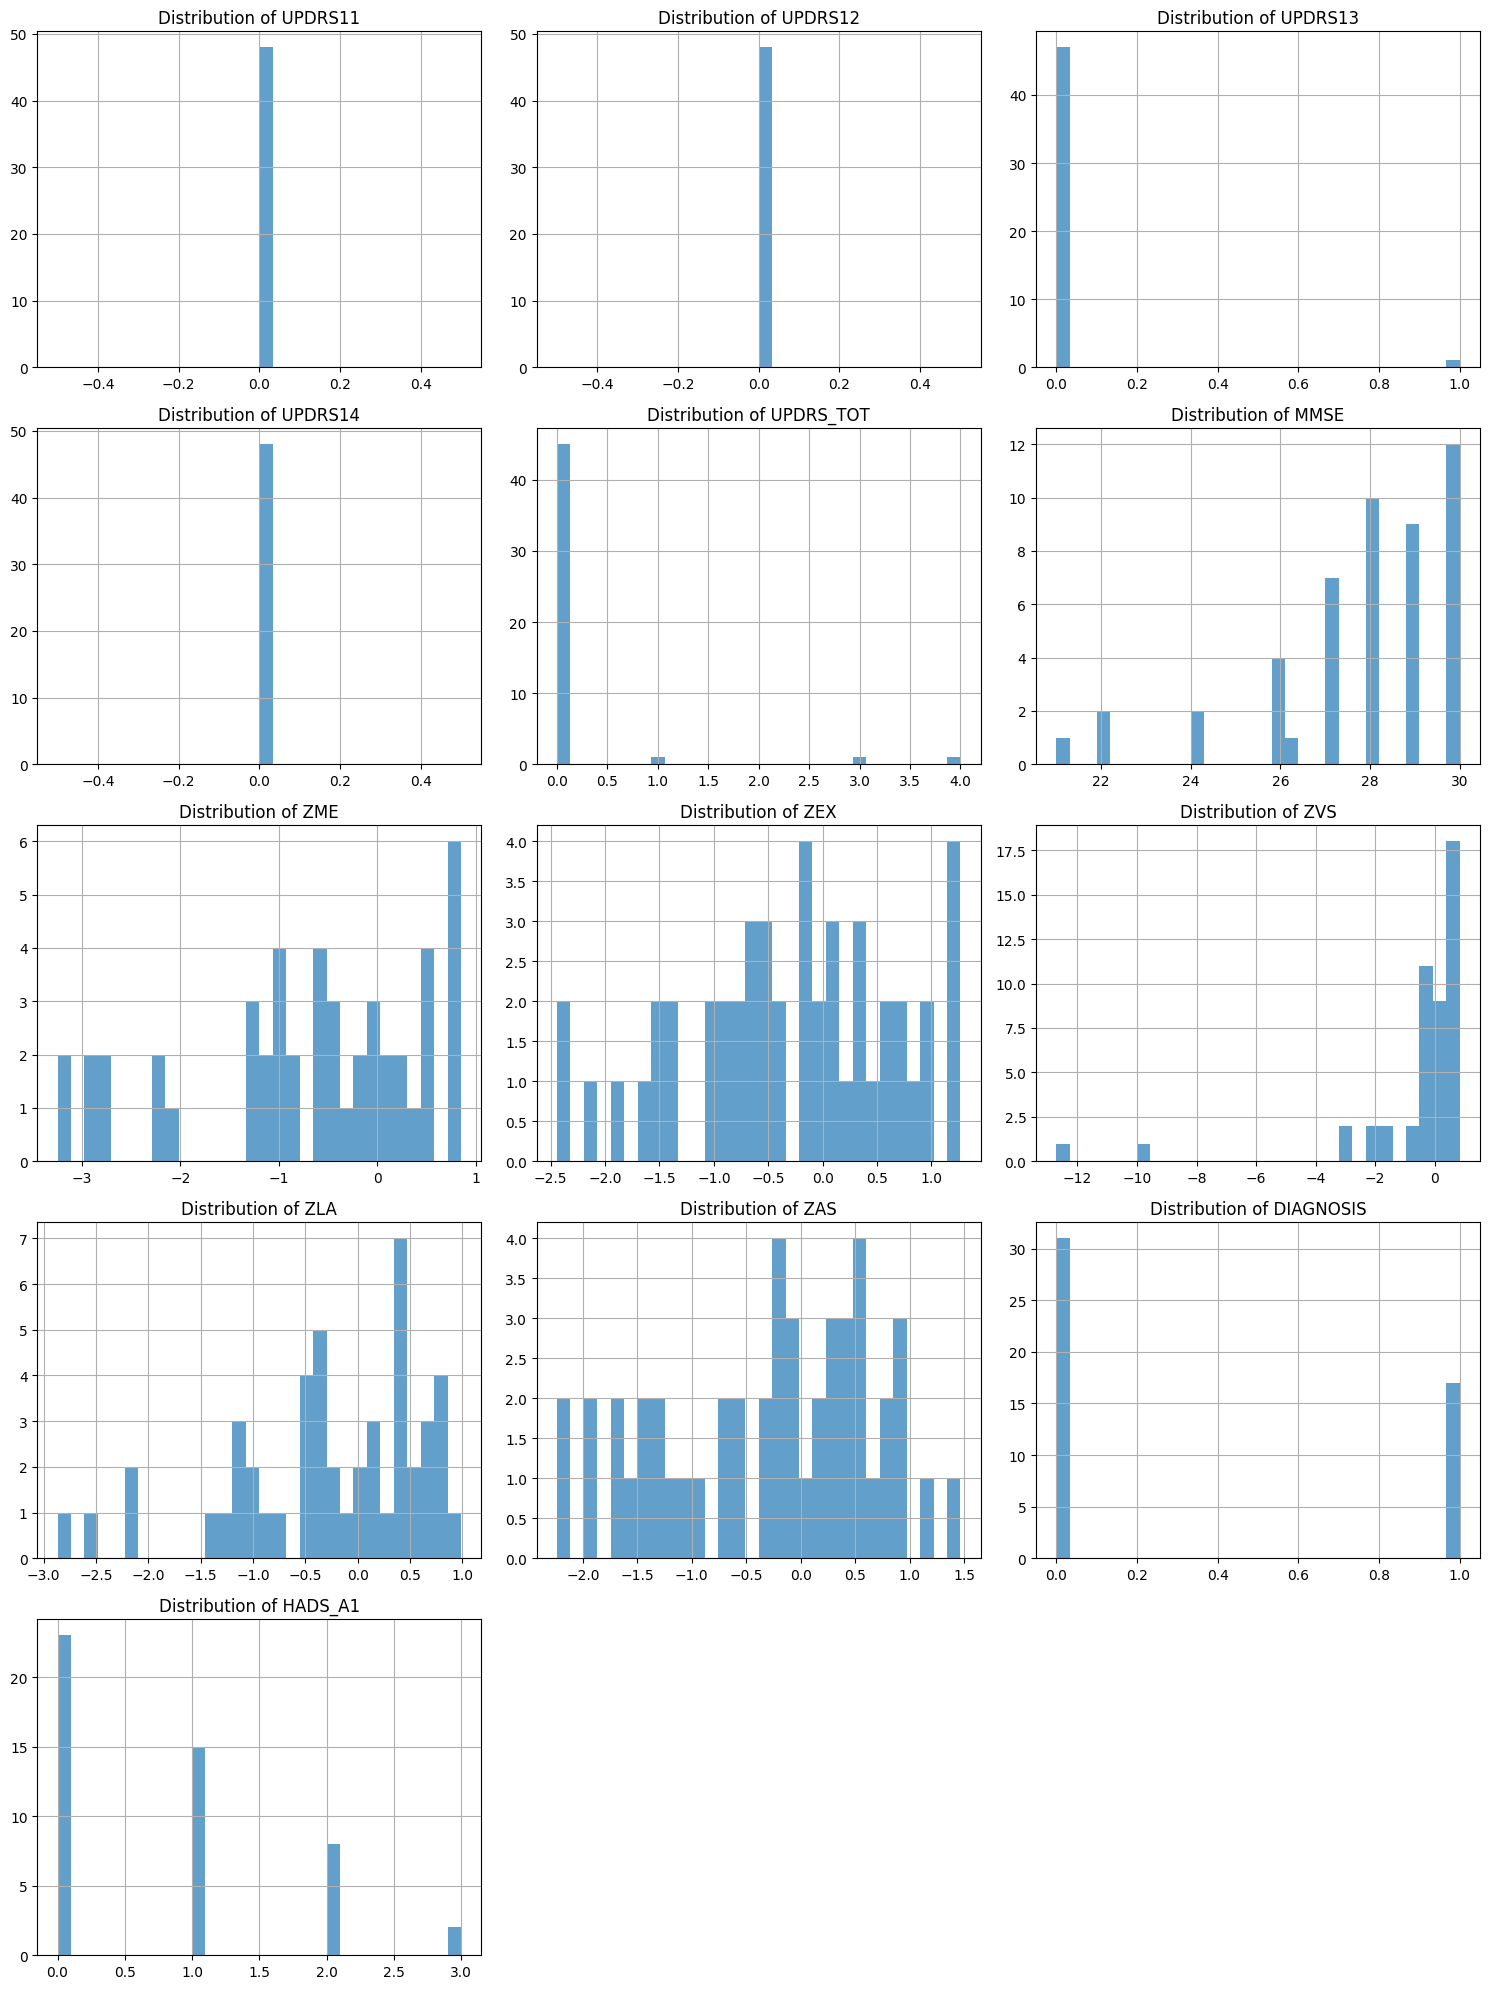

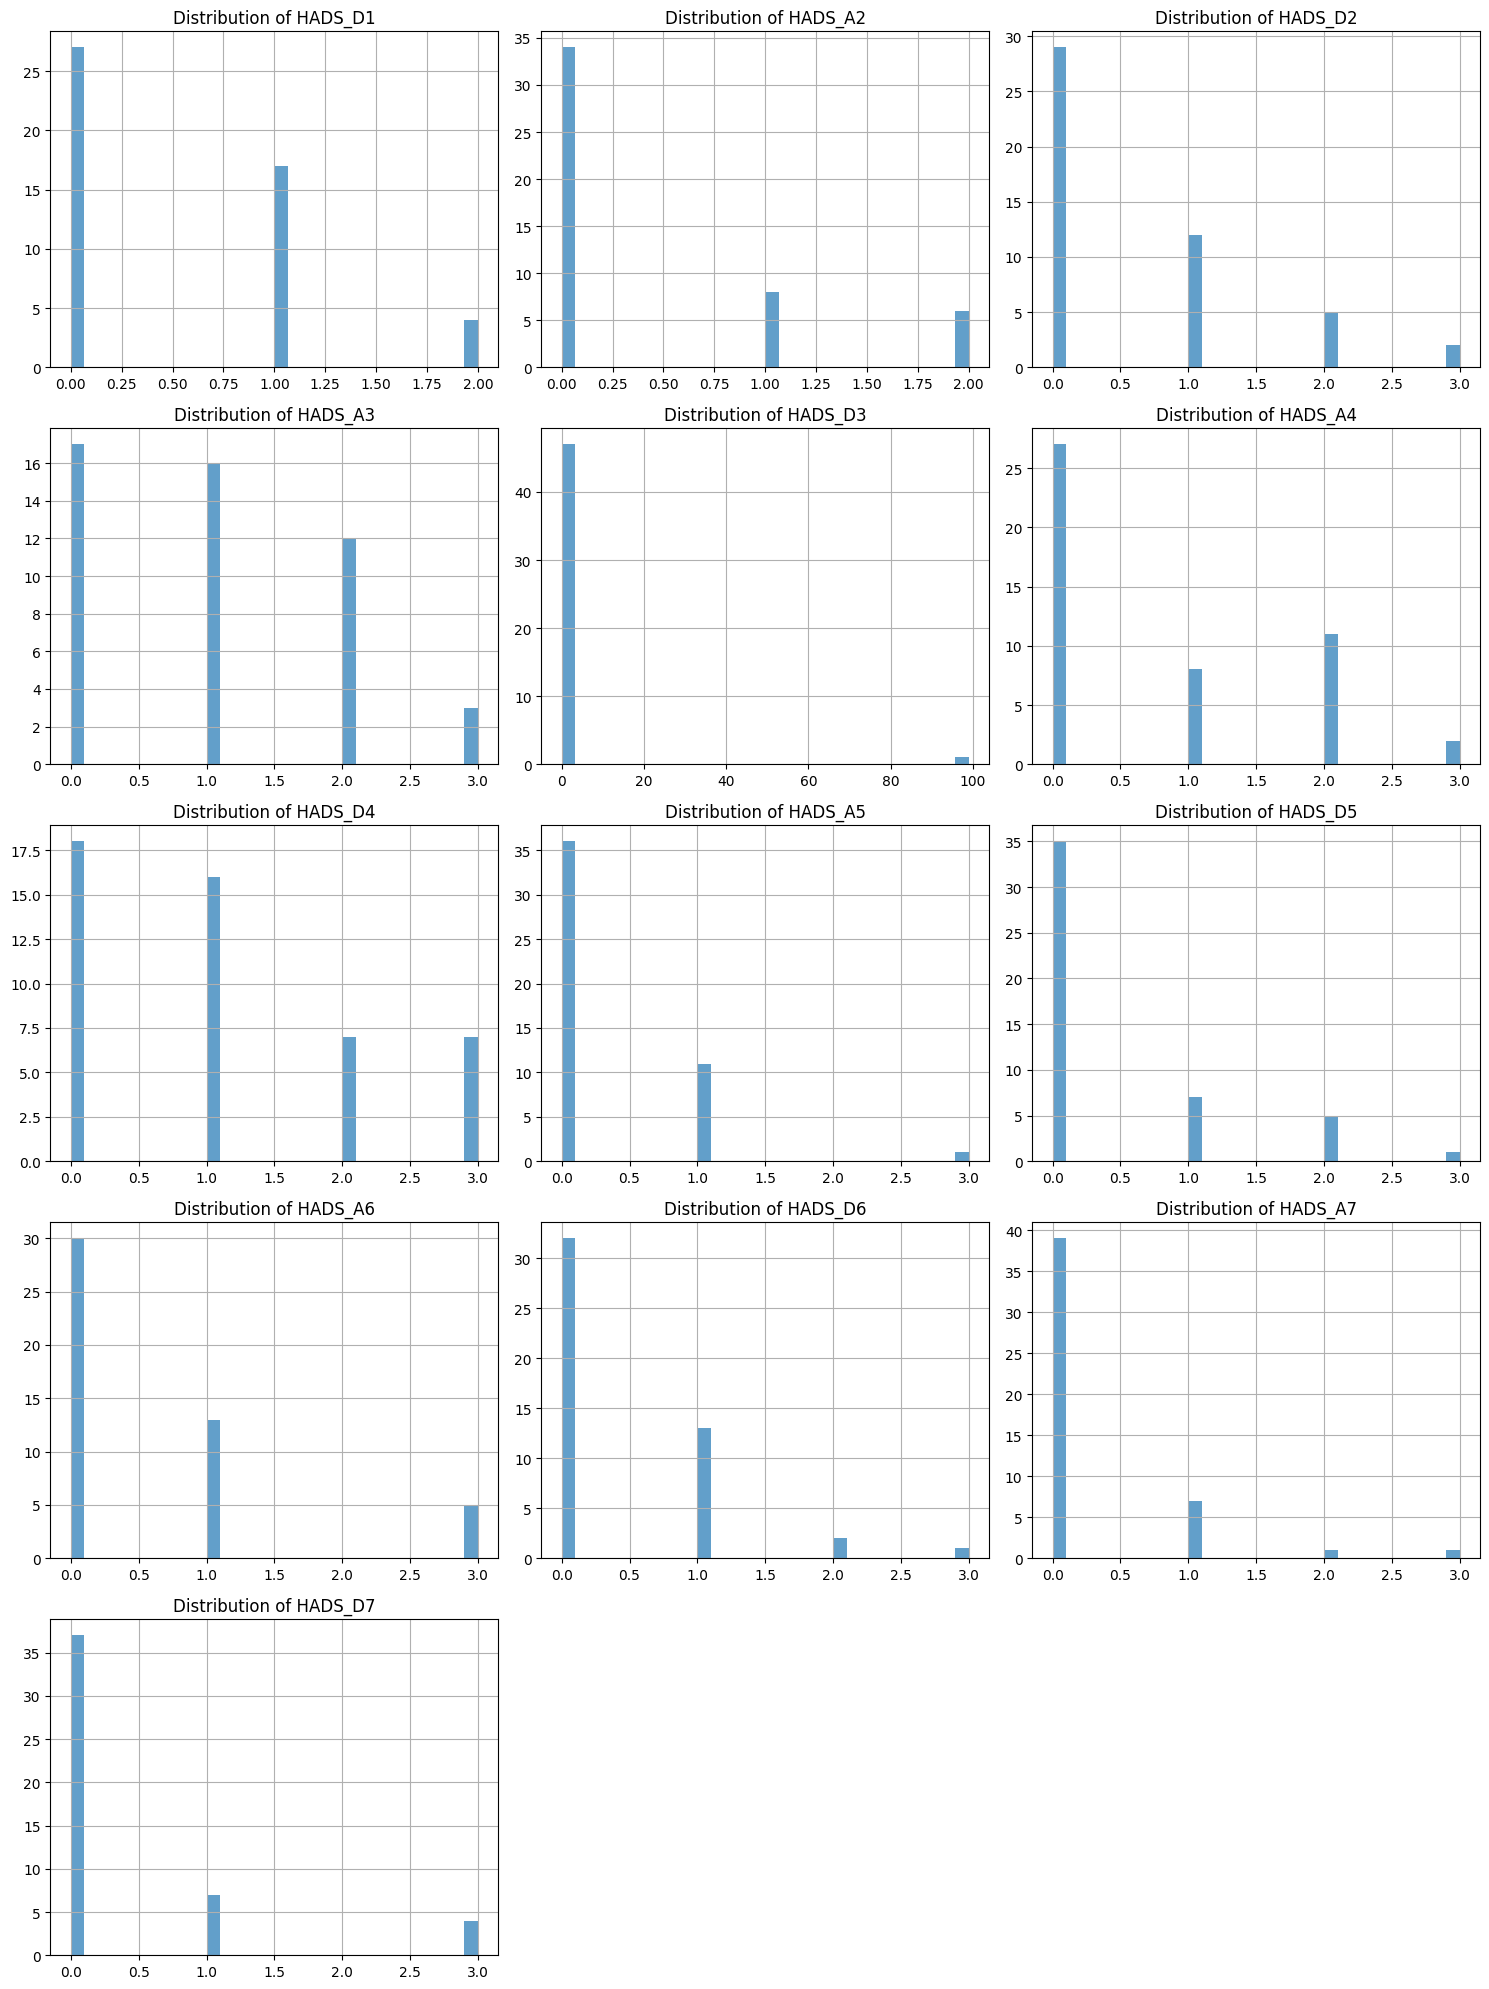

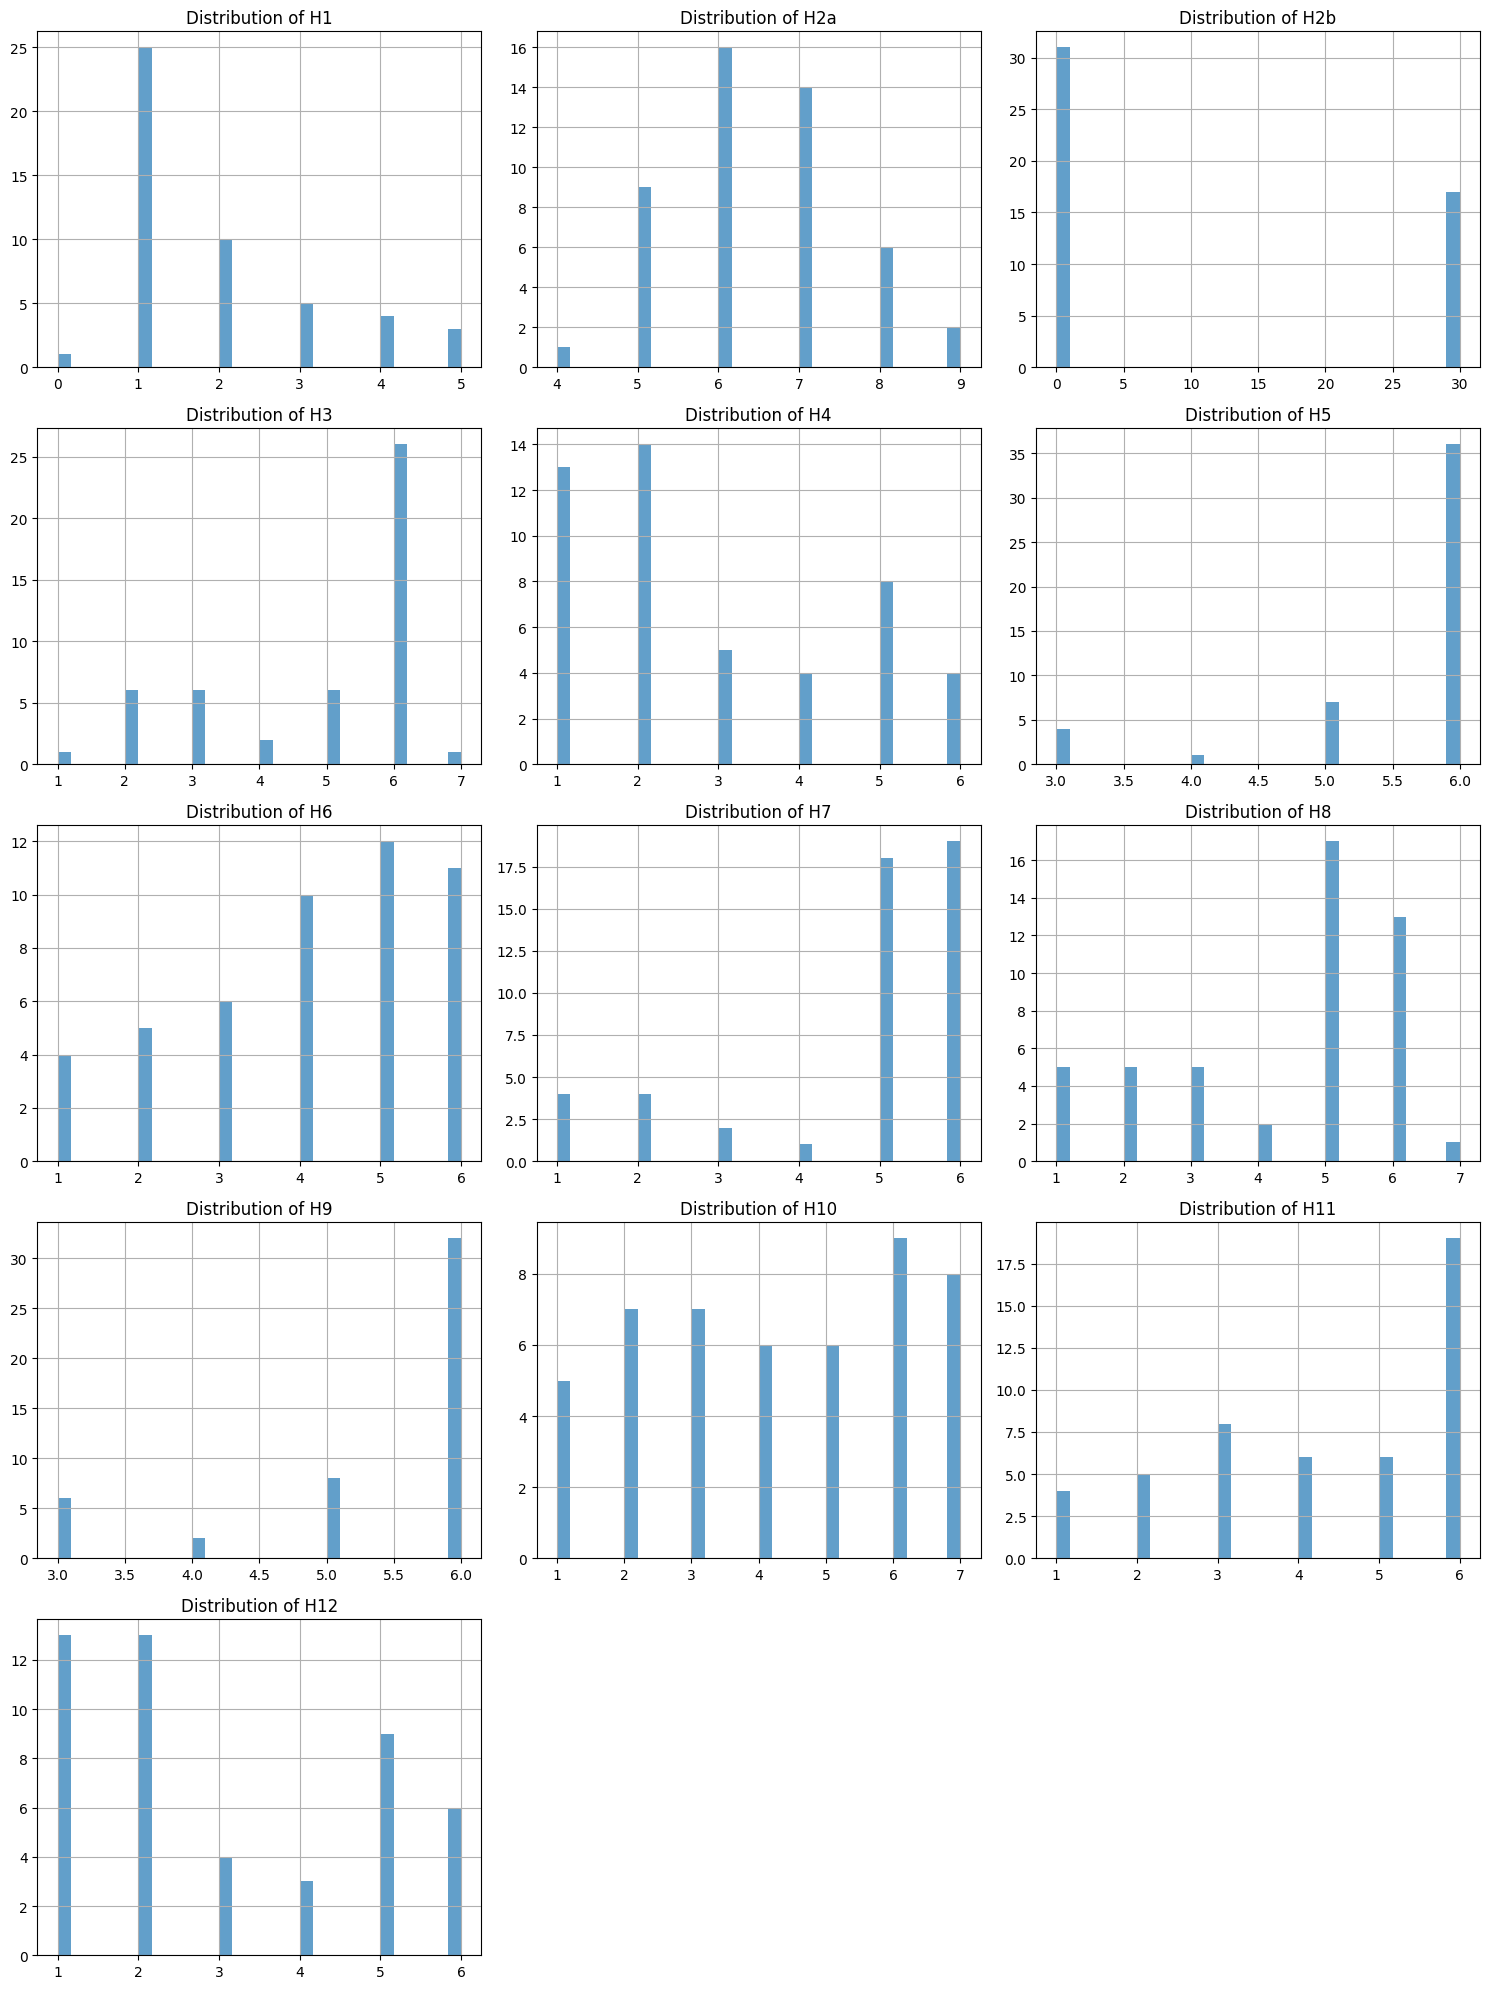

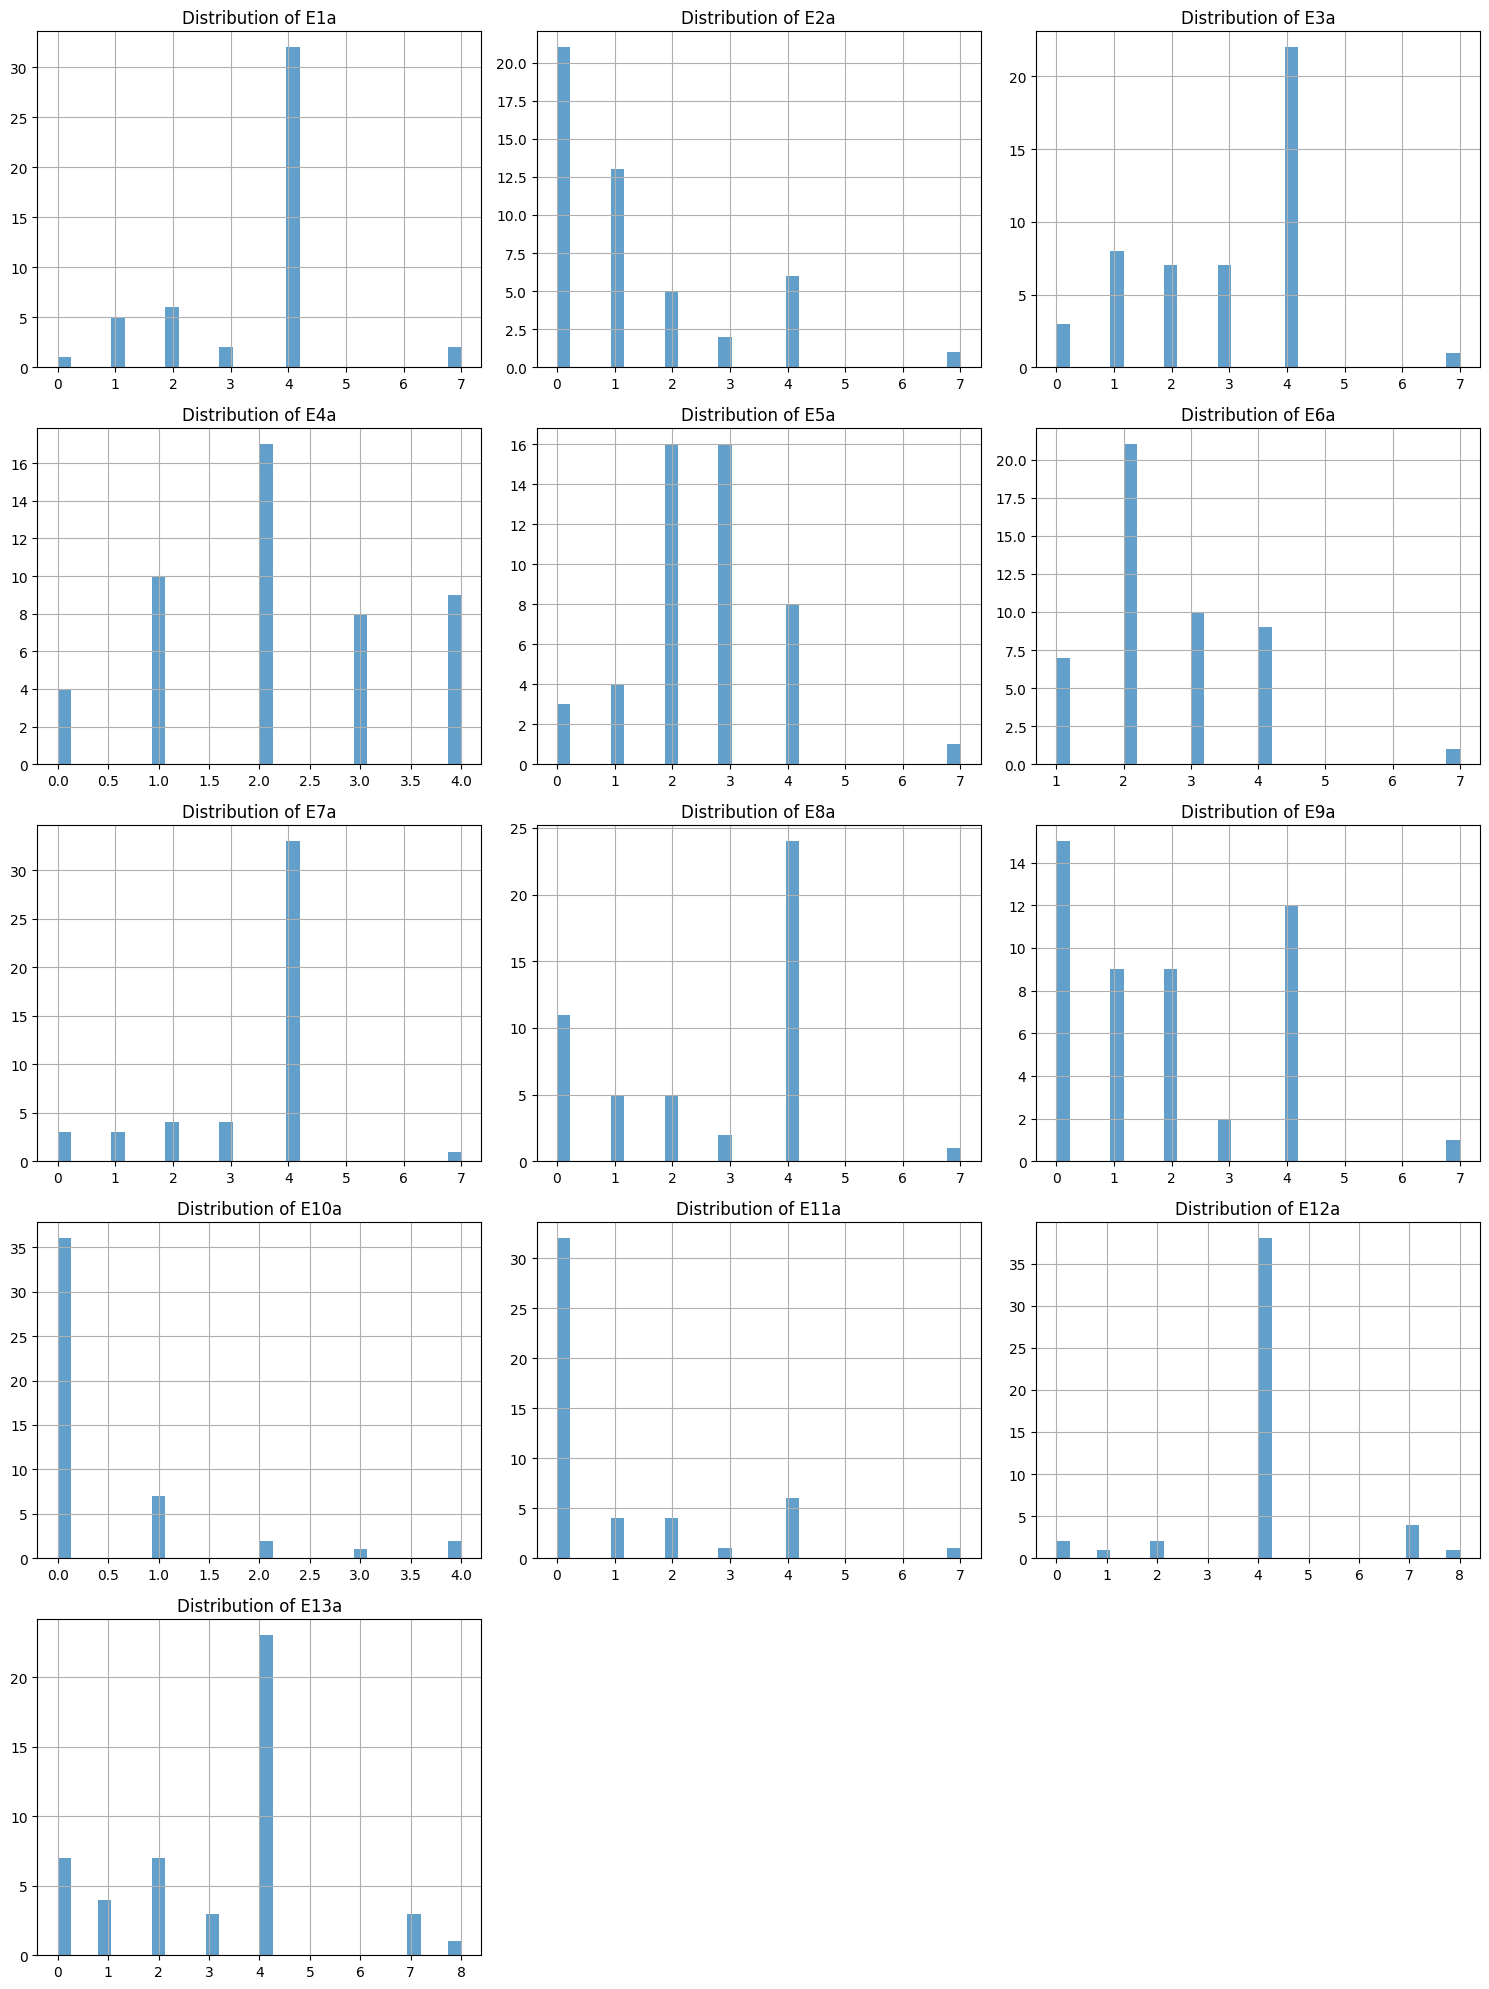

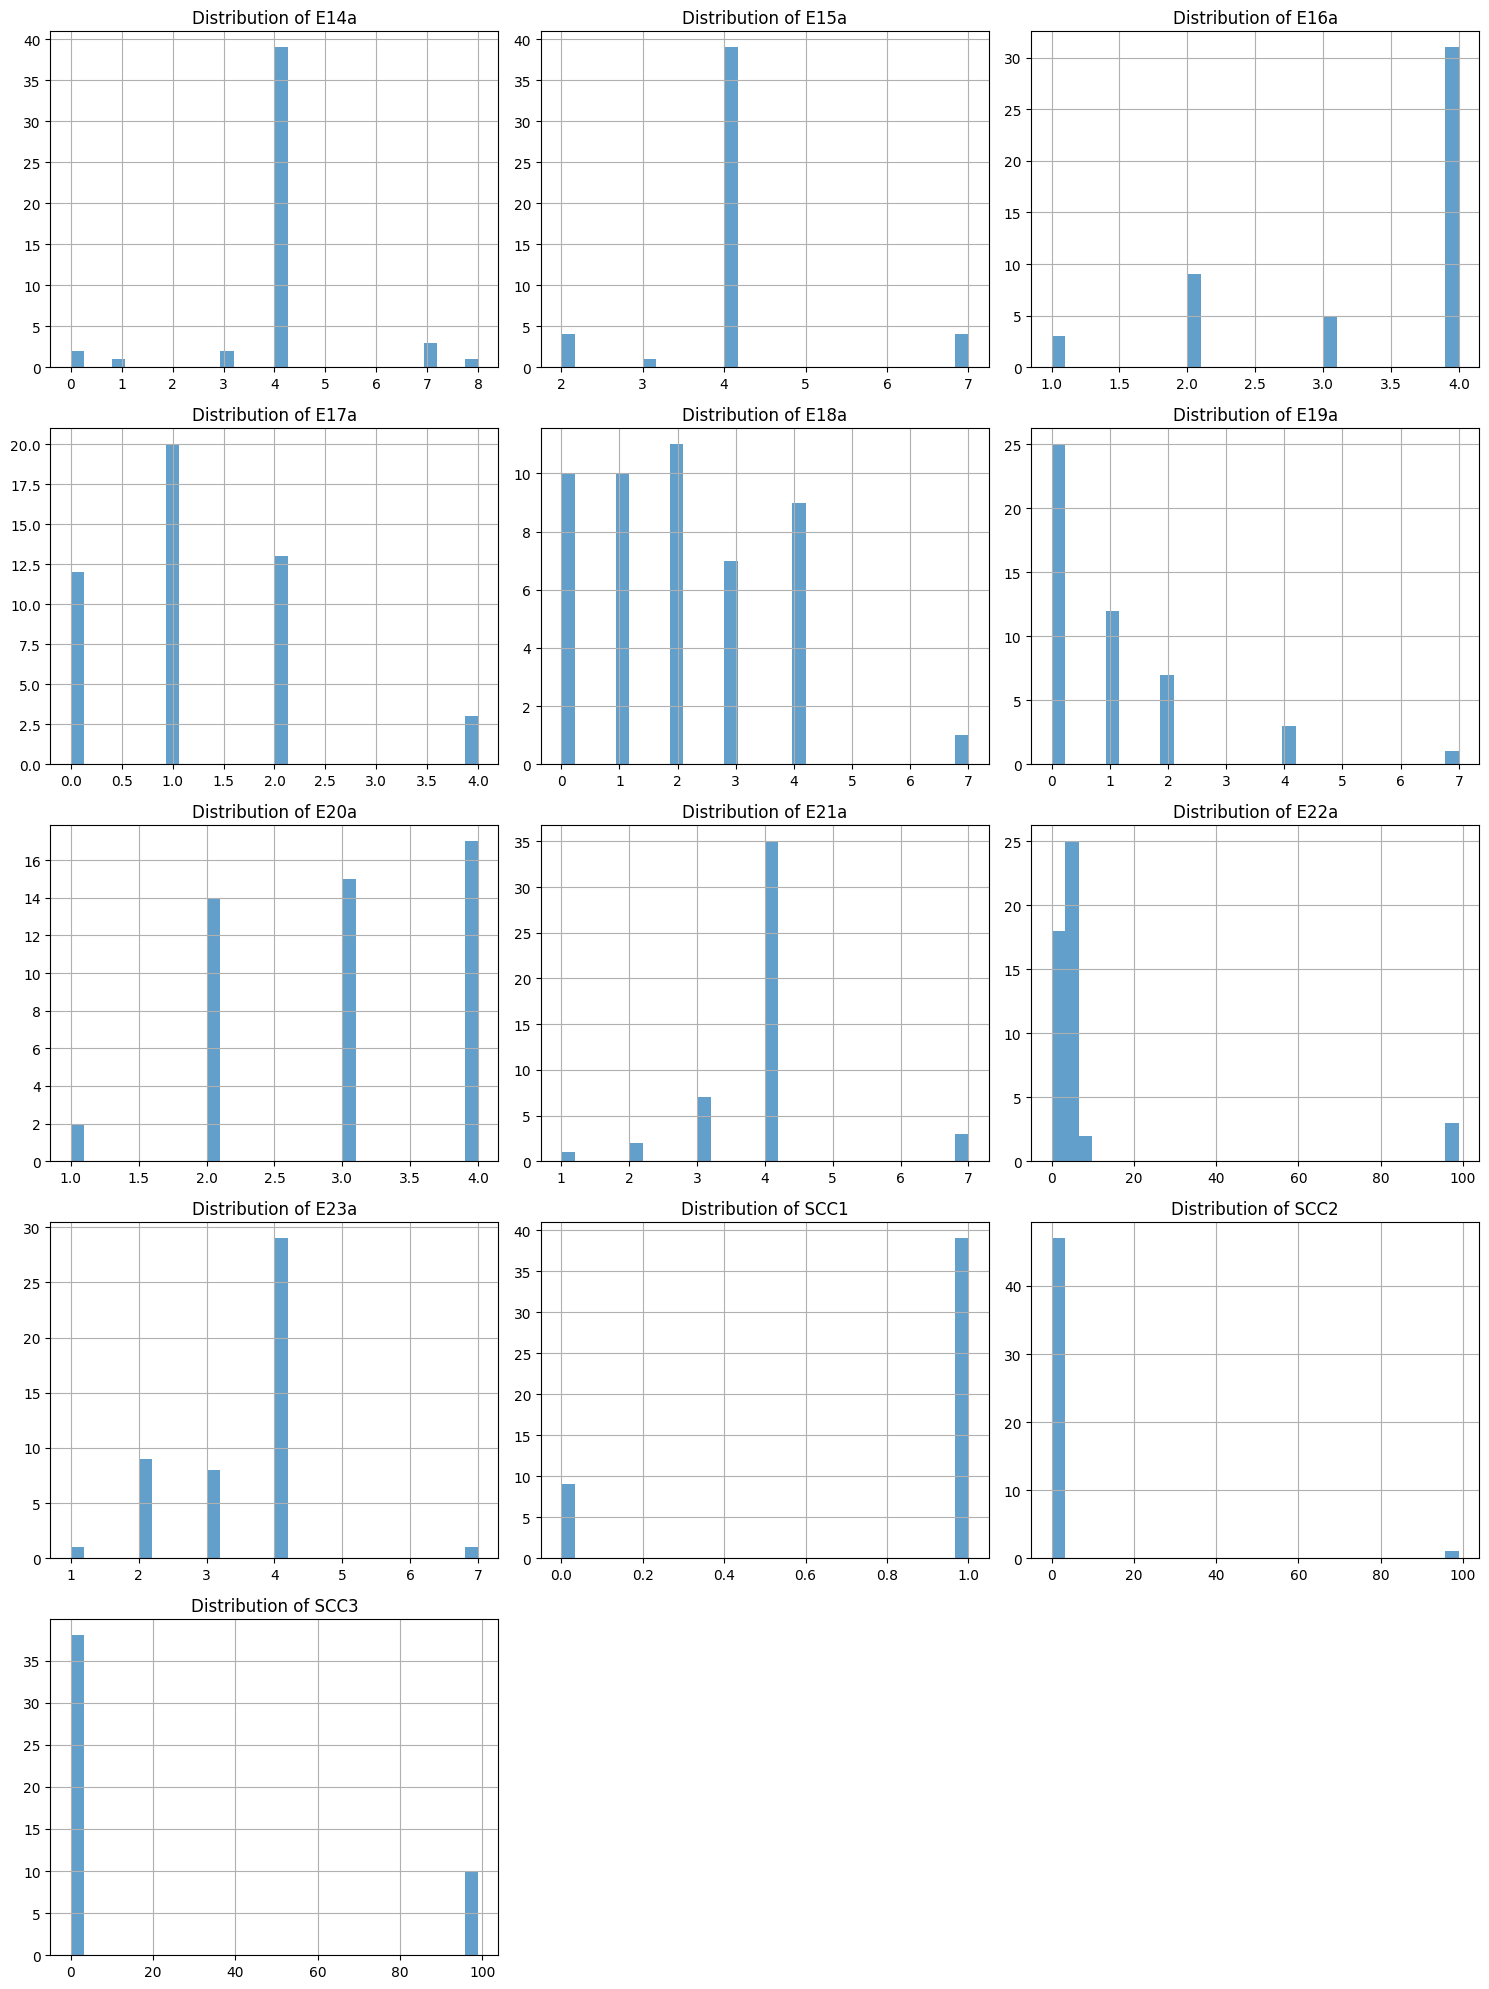

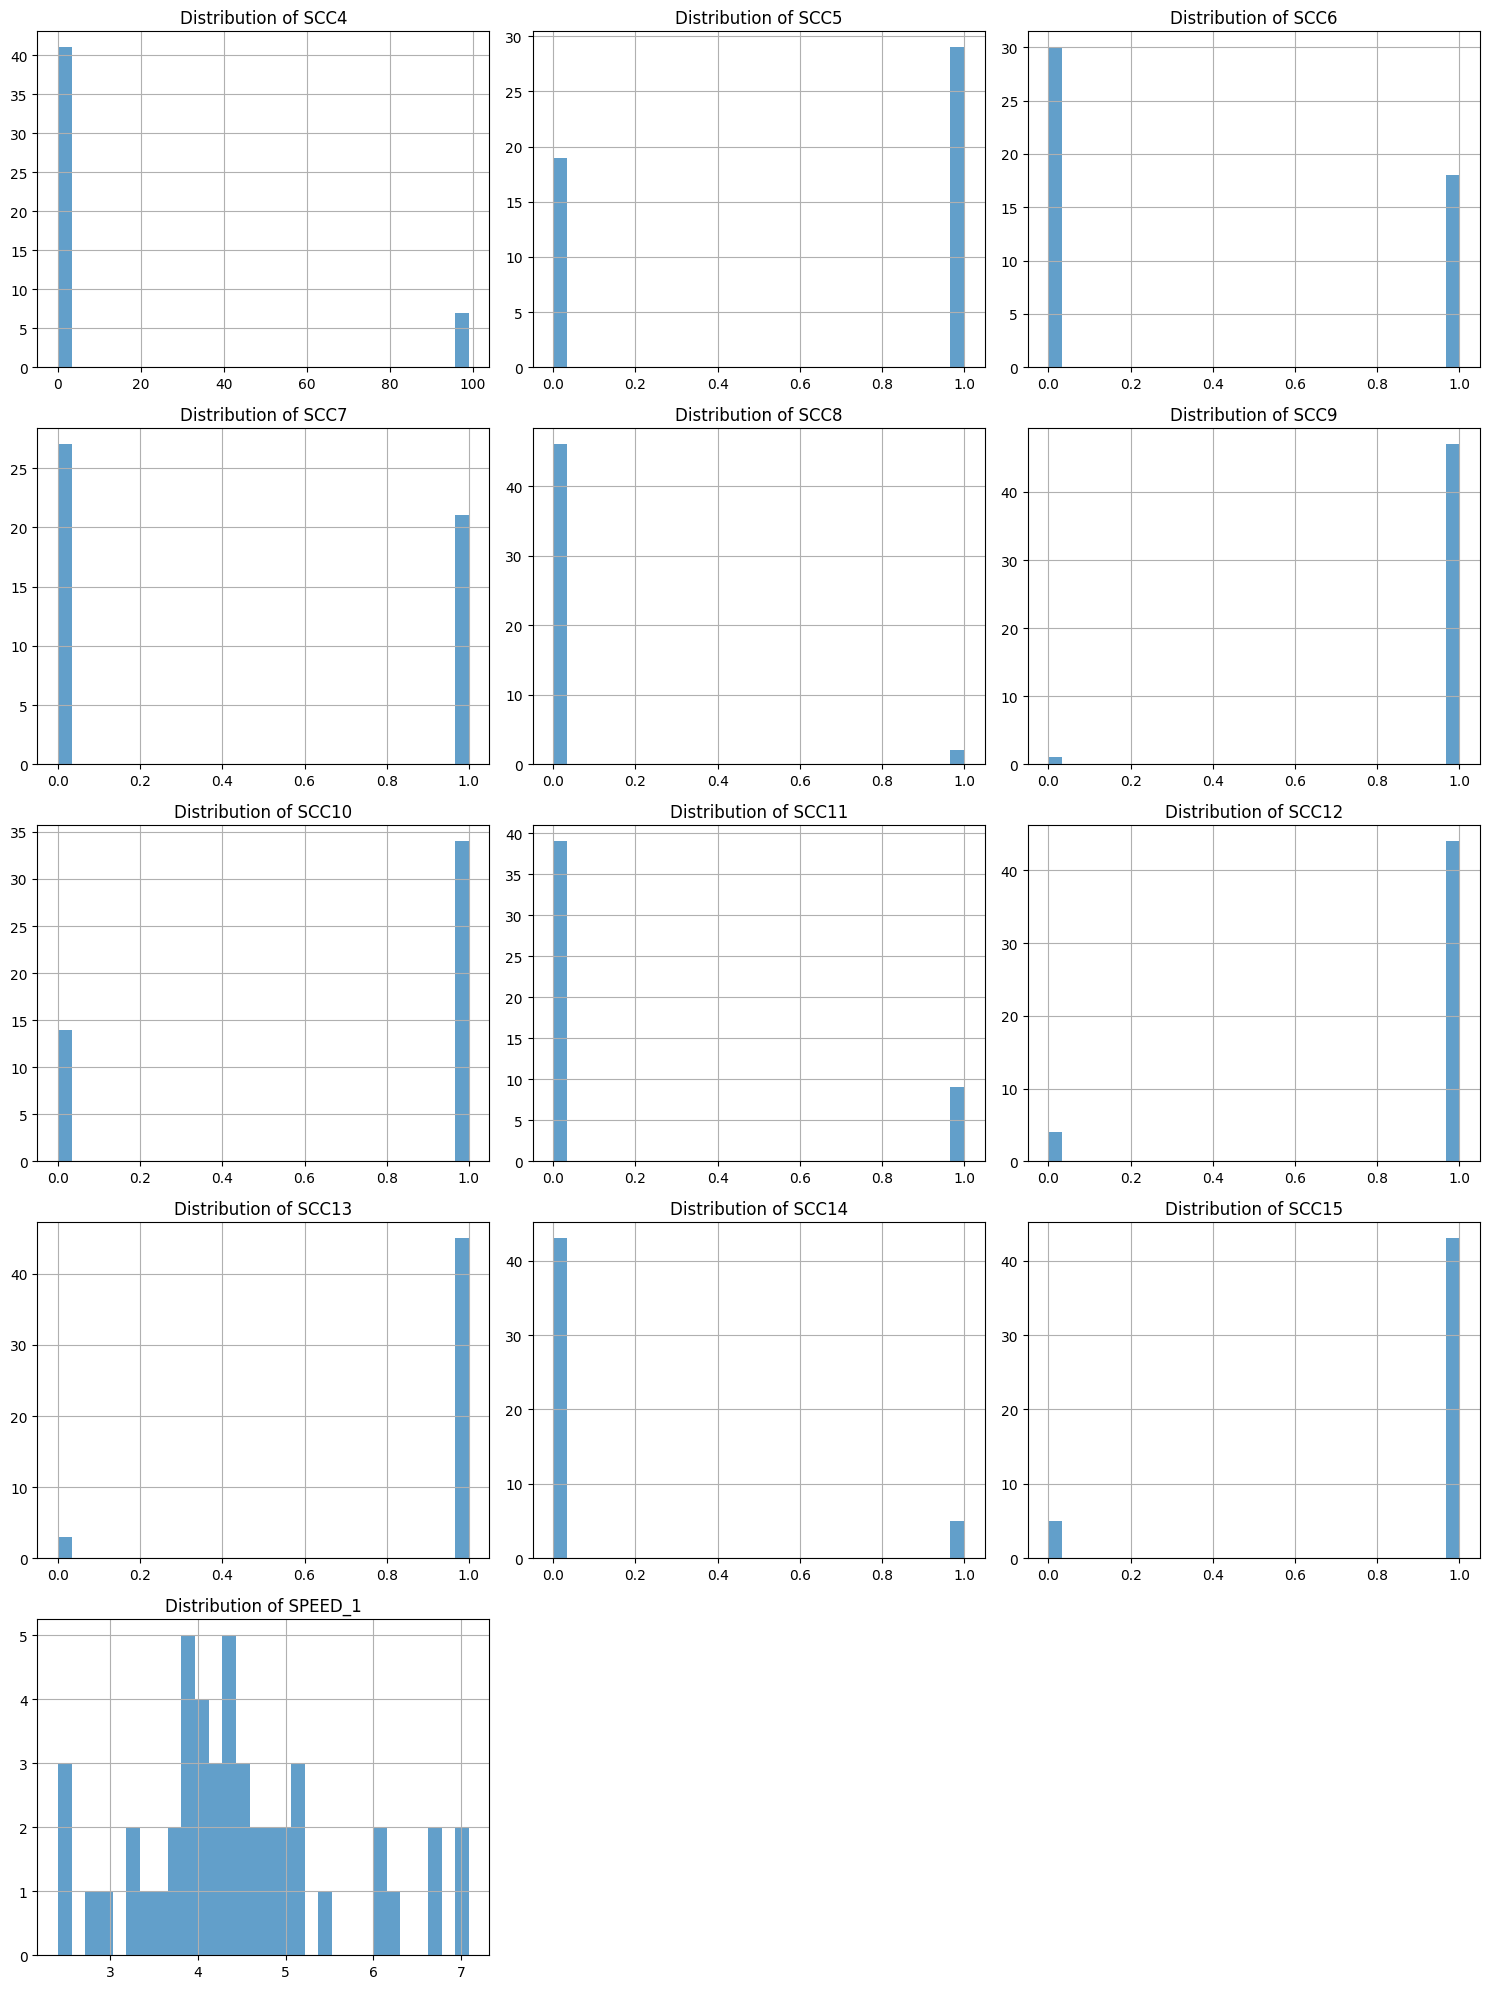

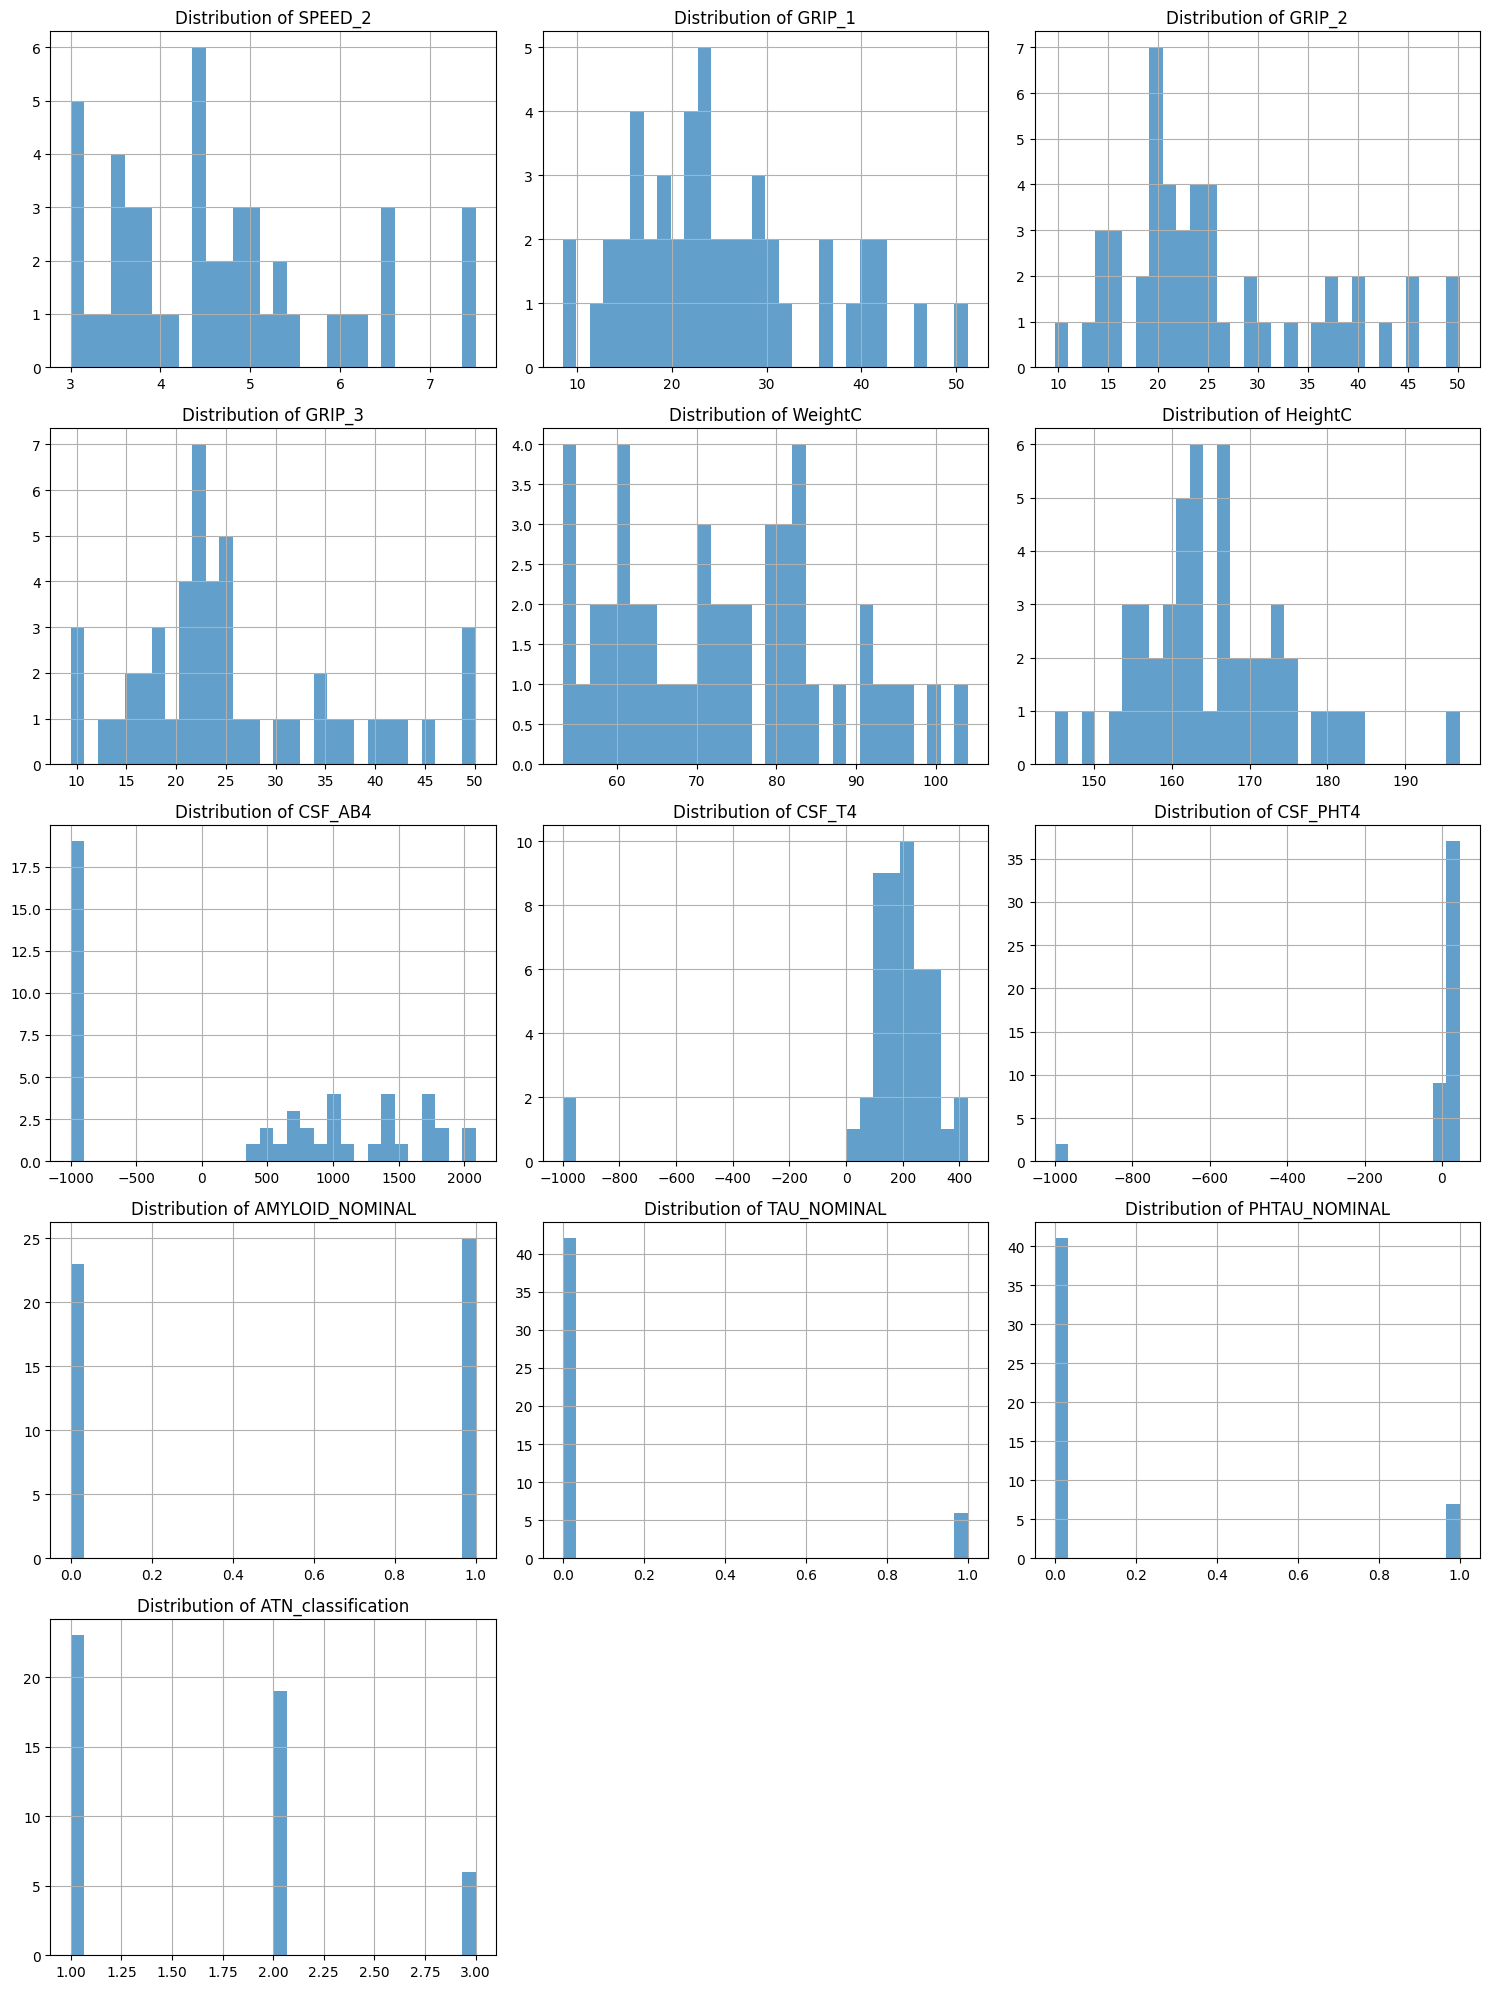

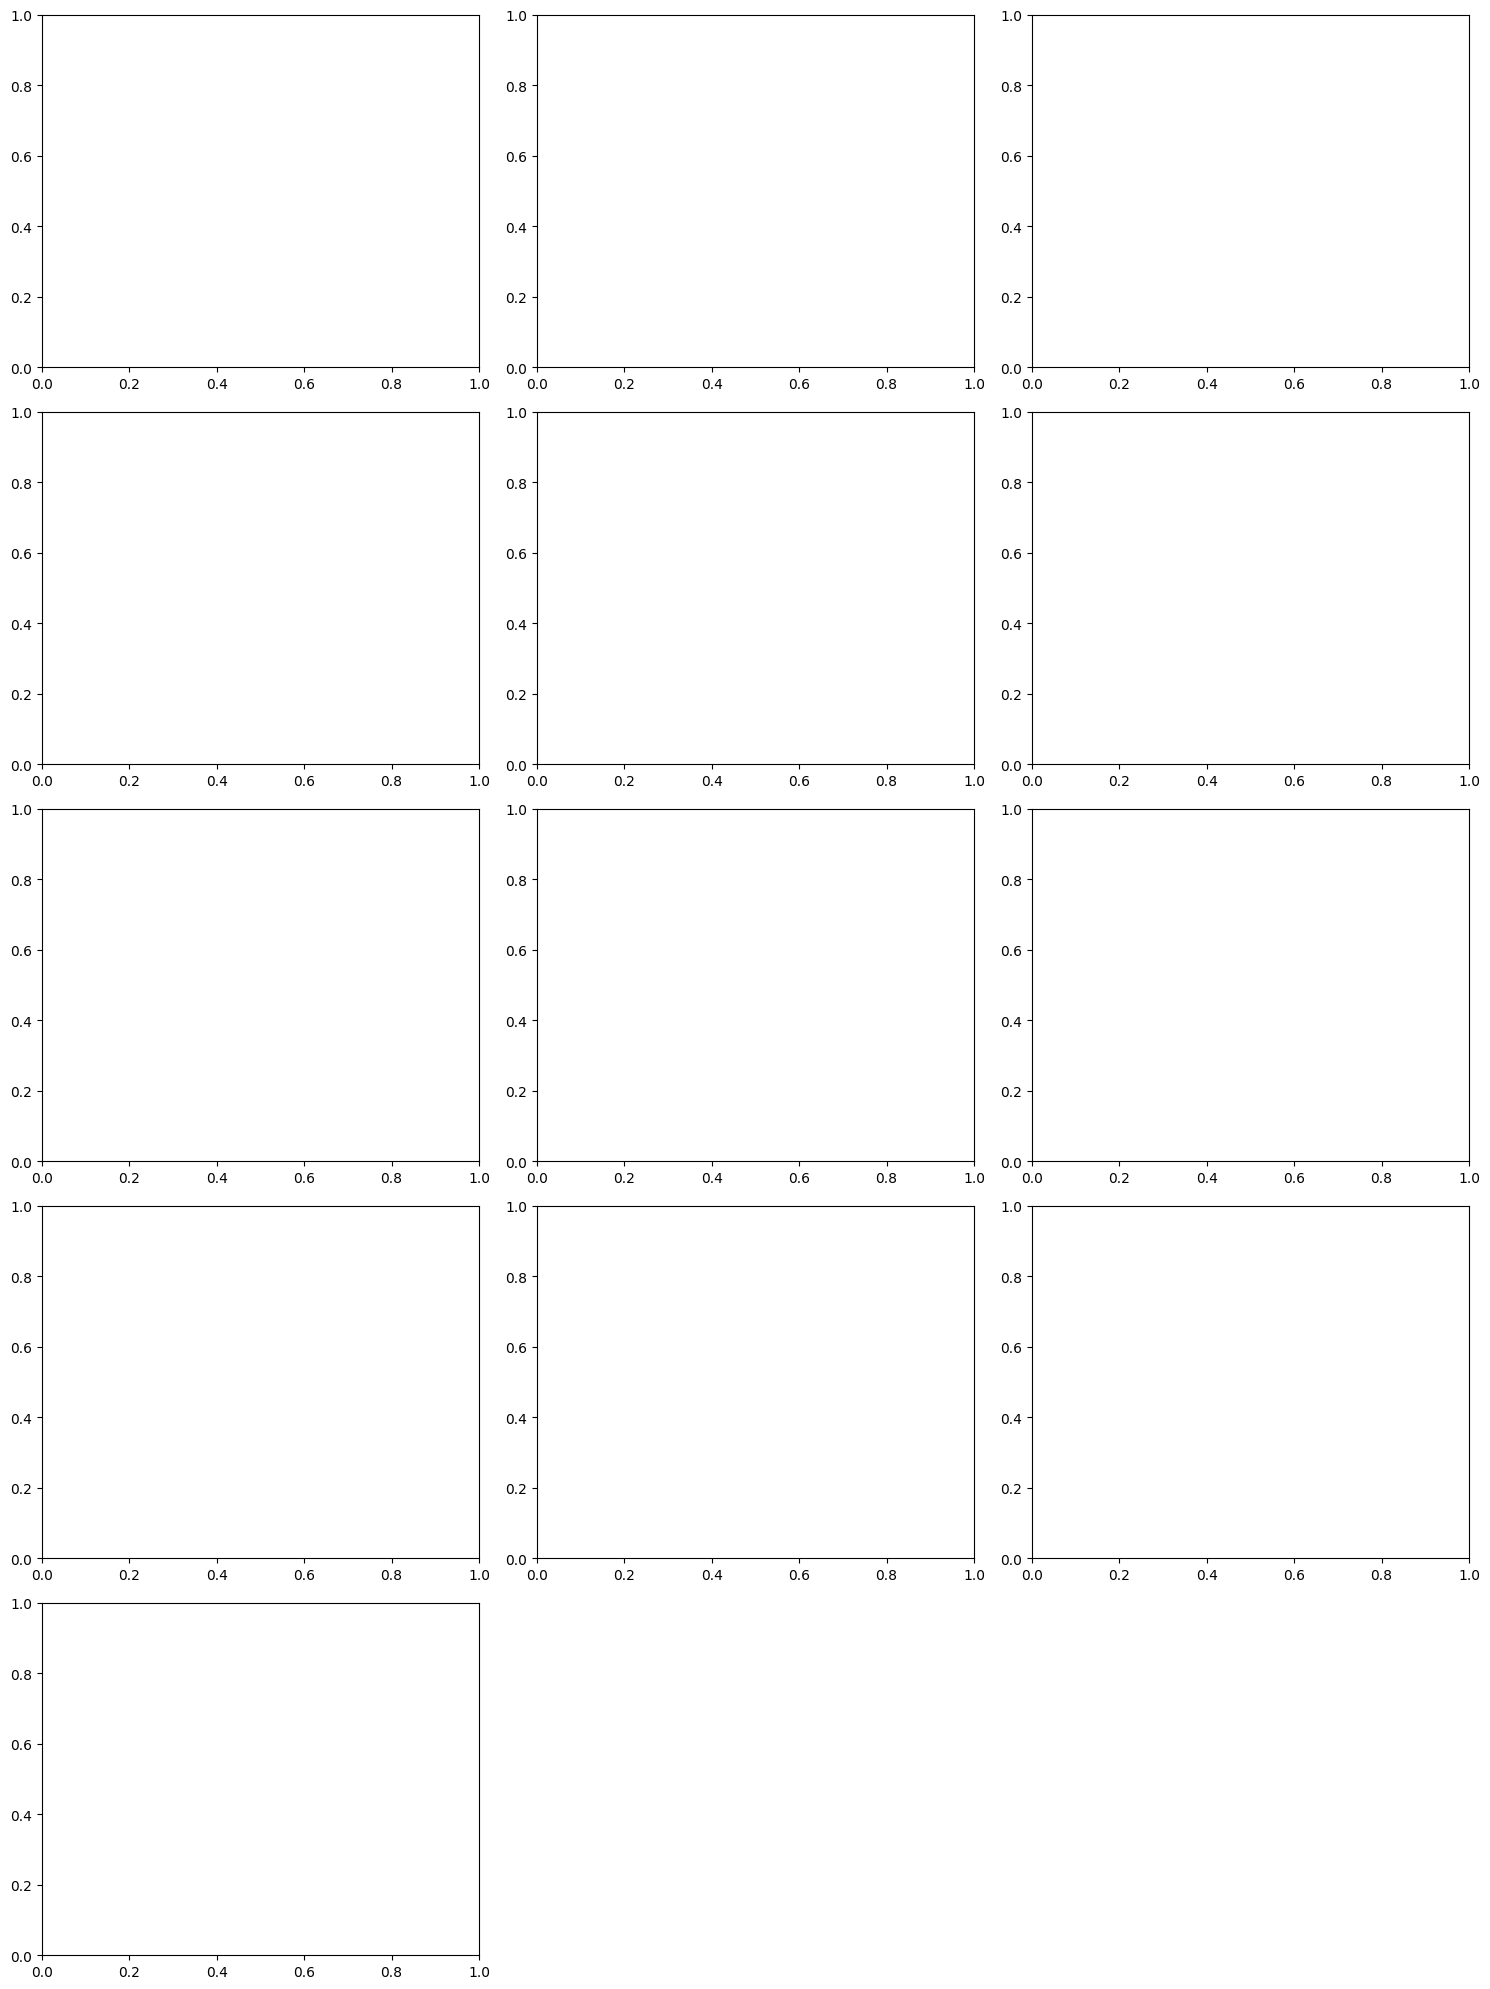

In [193]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = test_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(test_df.columns[start_idx:end_idx]):
        test_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

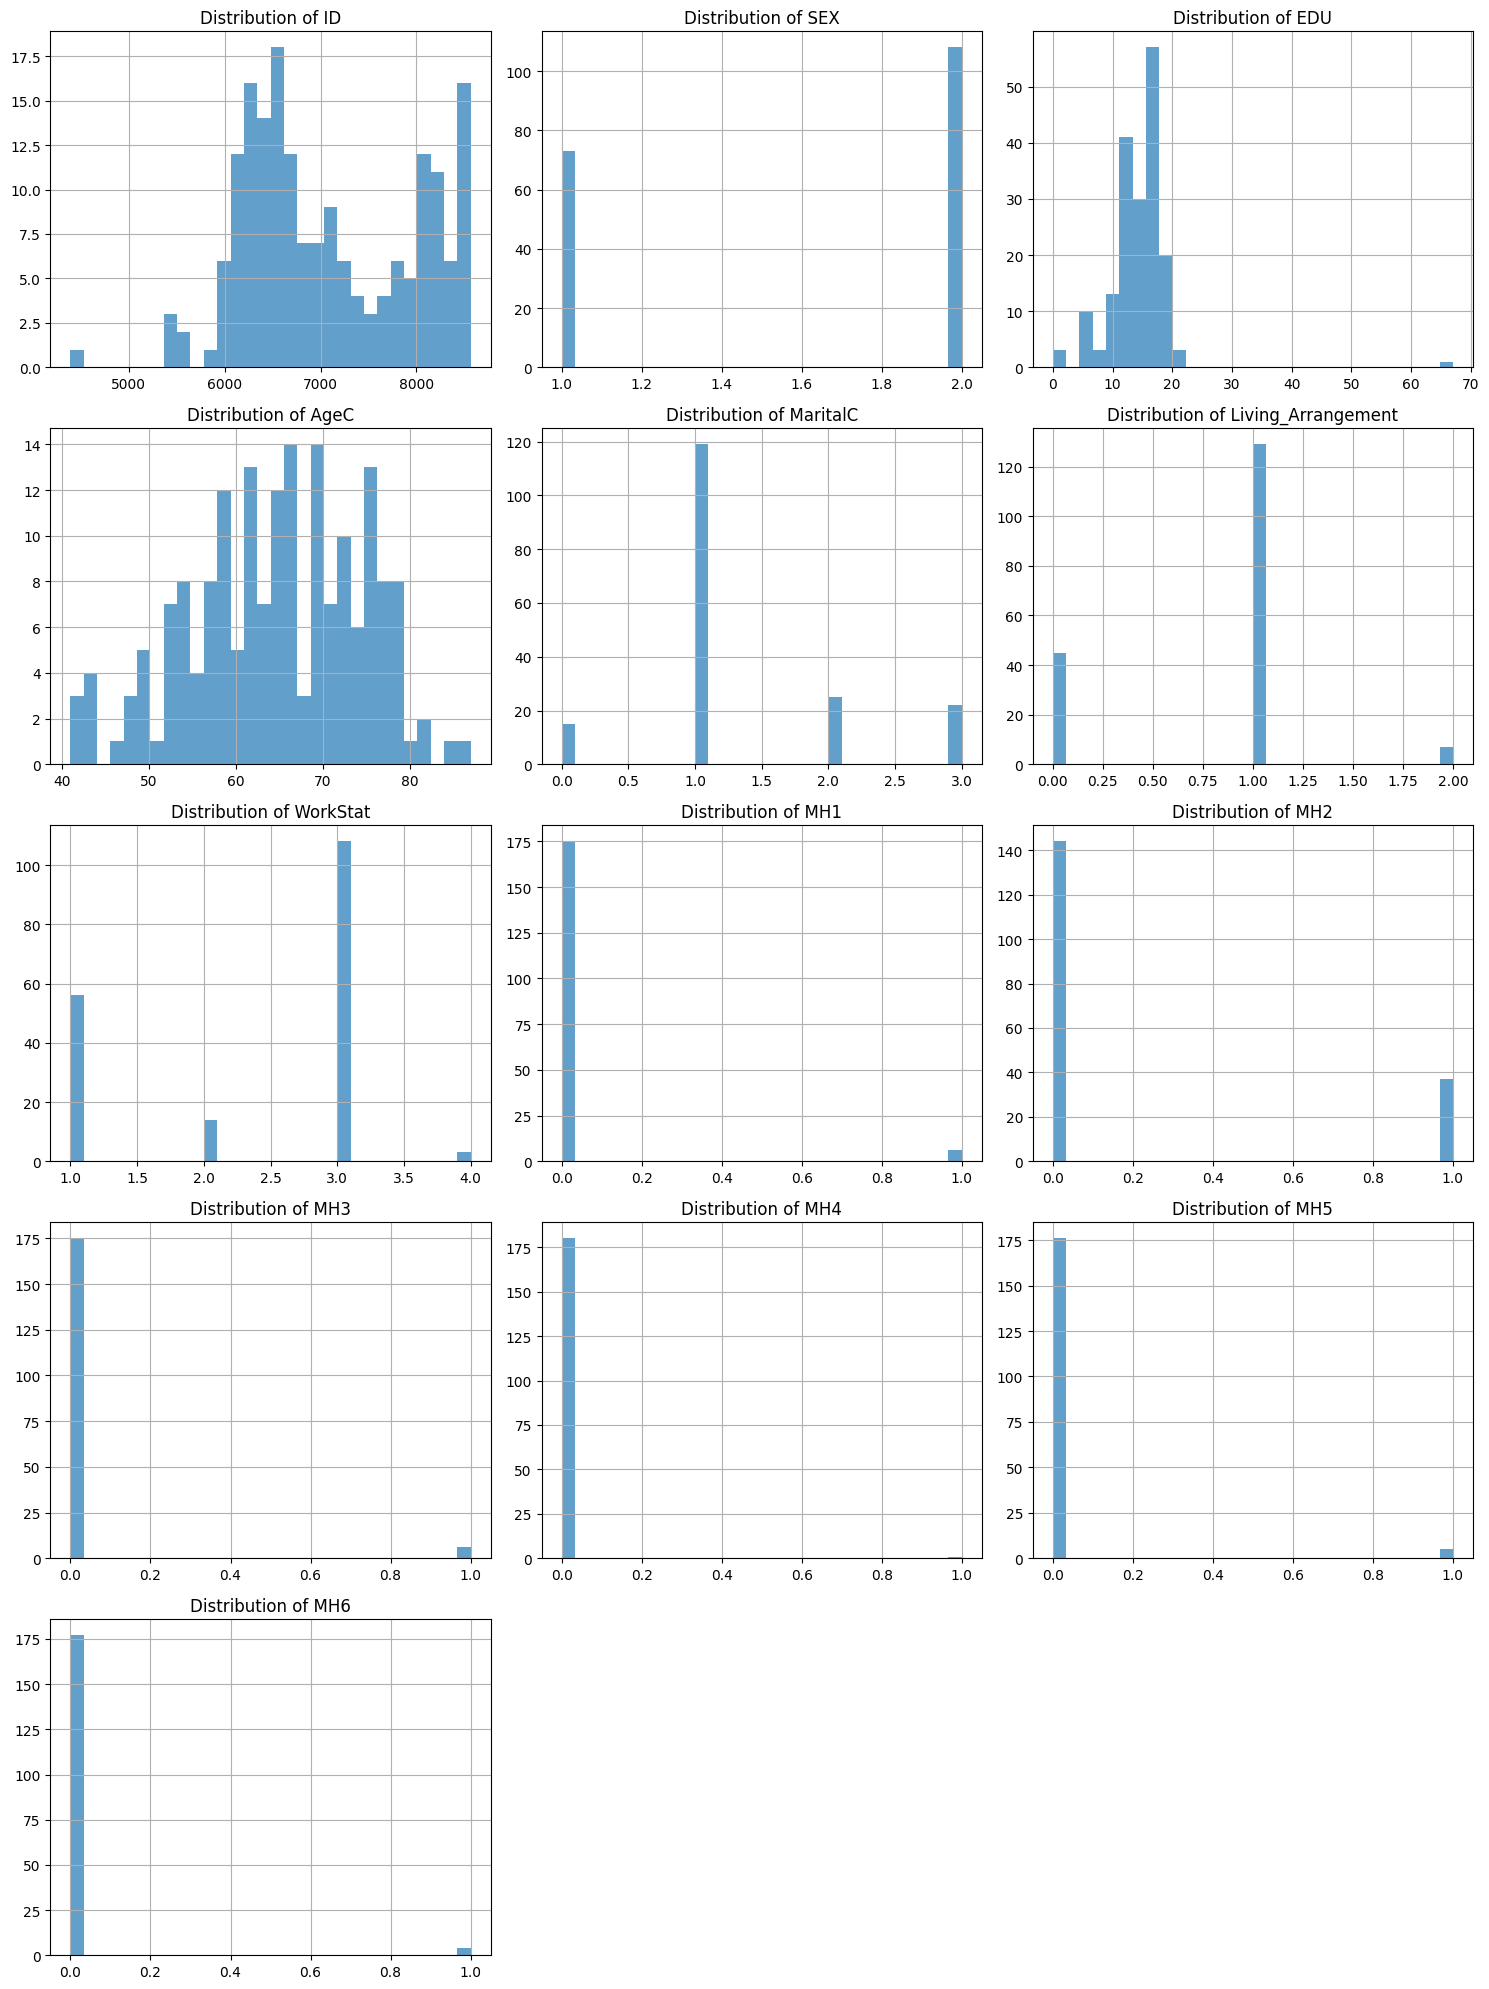

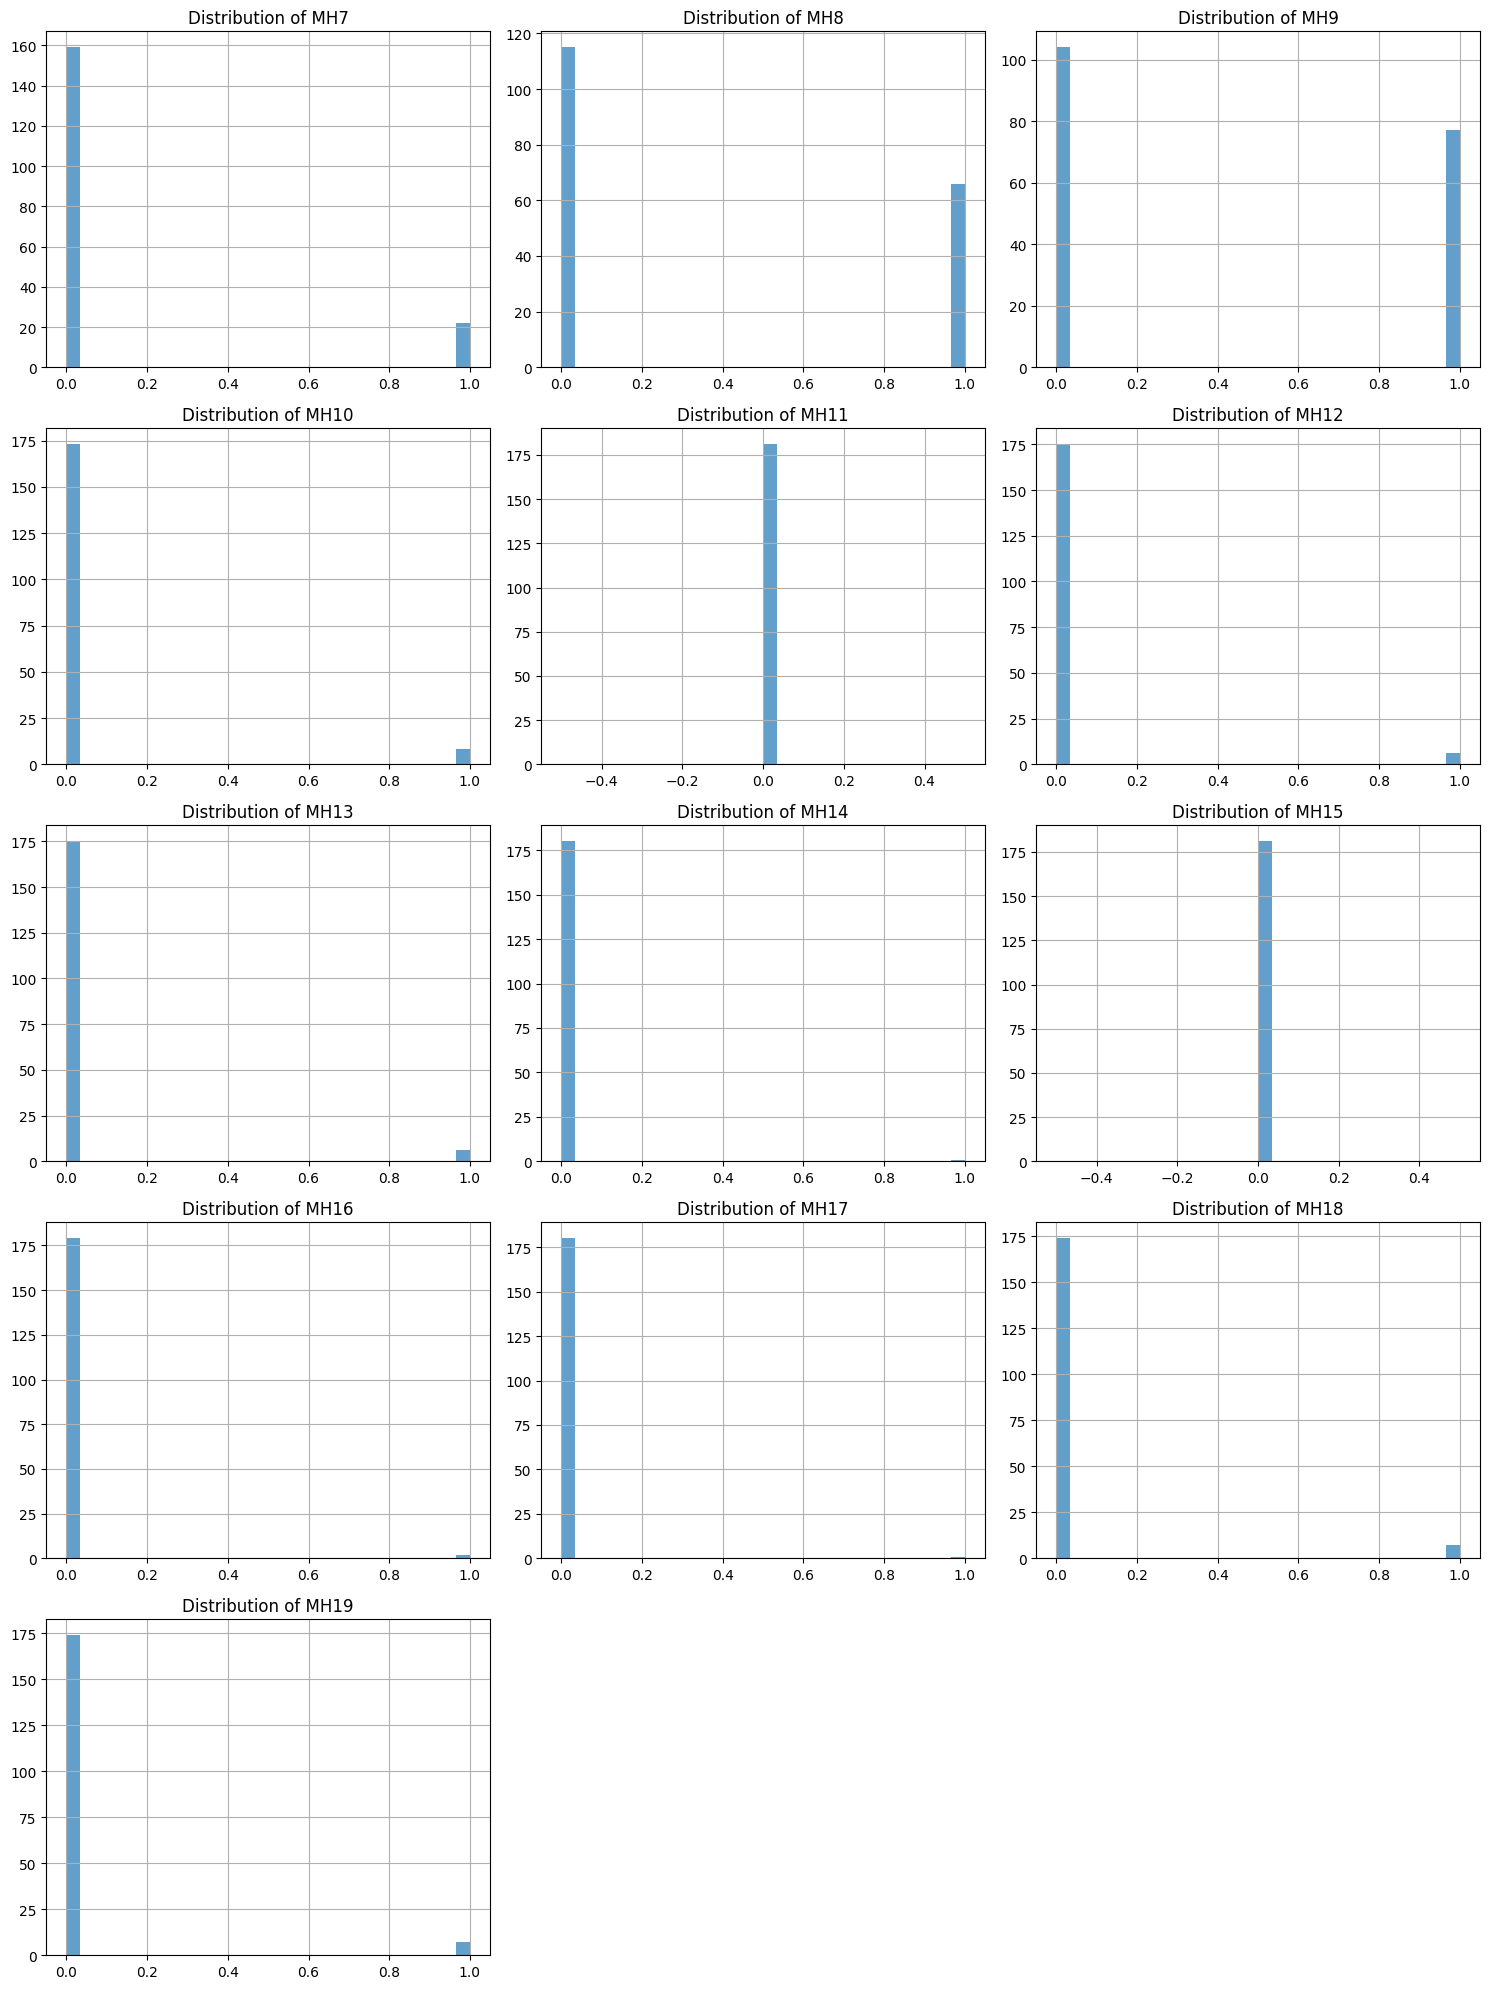

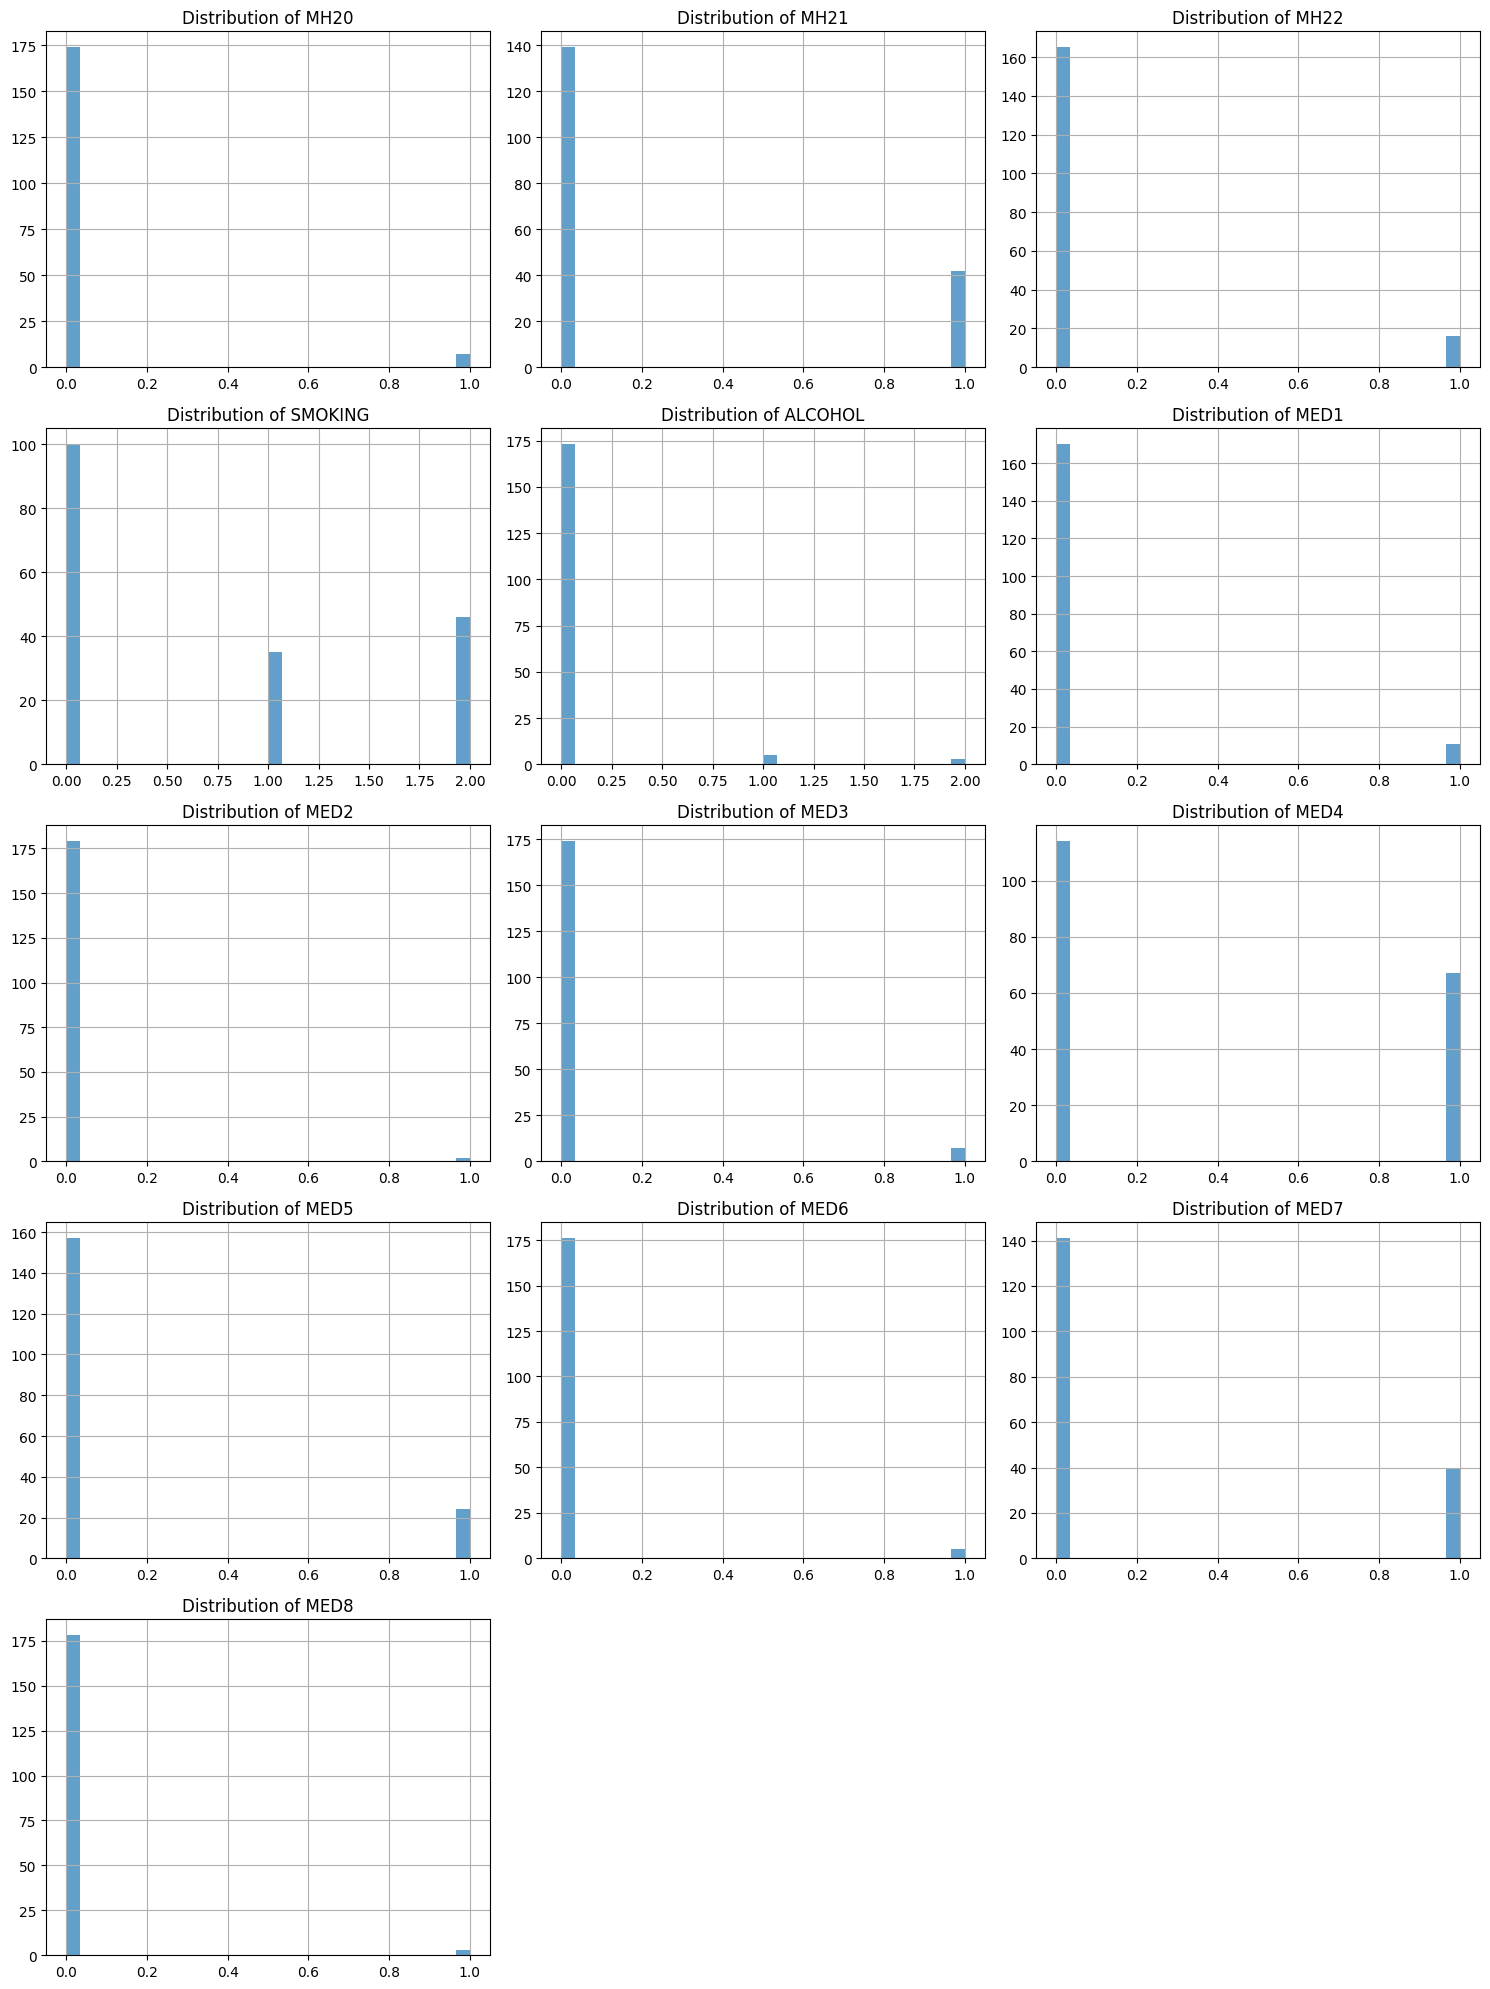

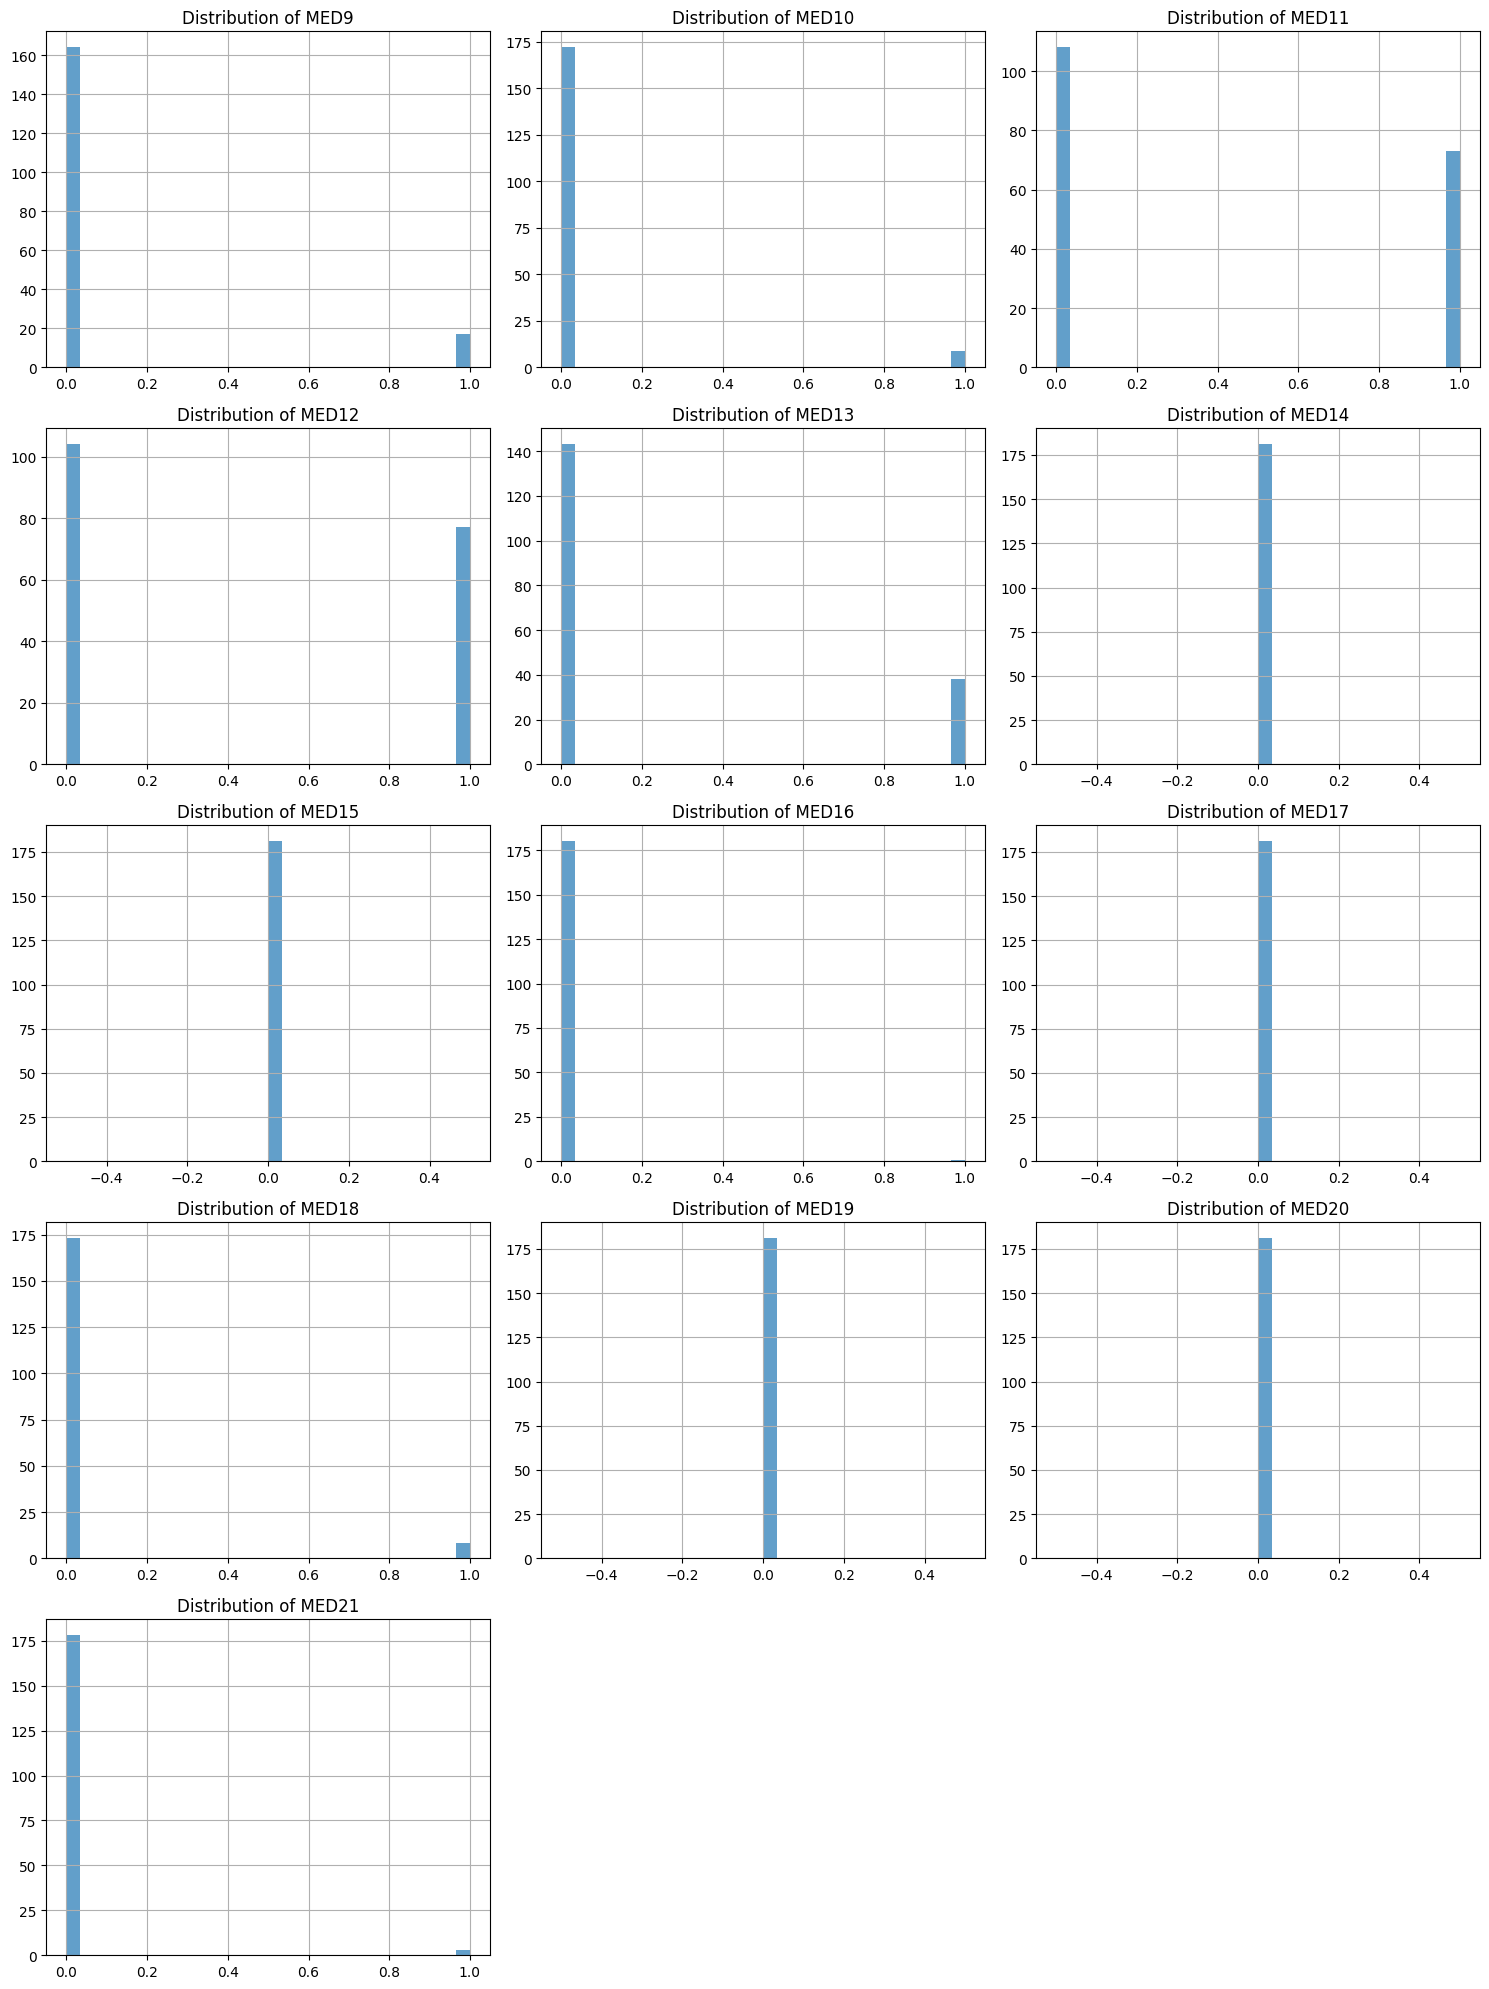

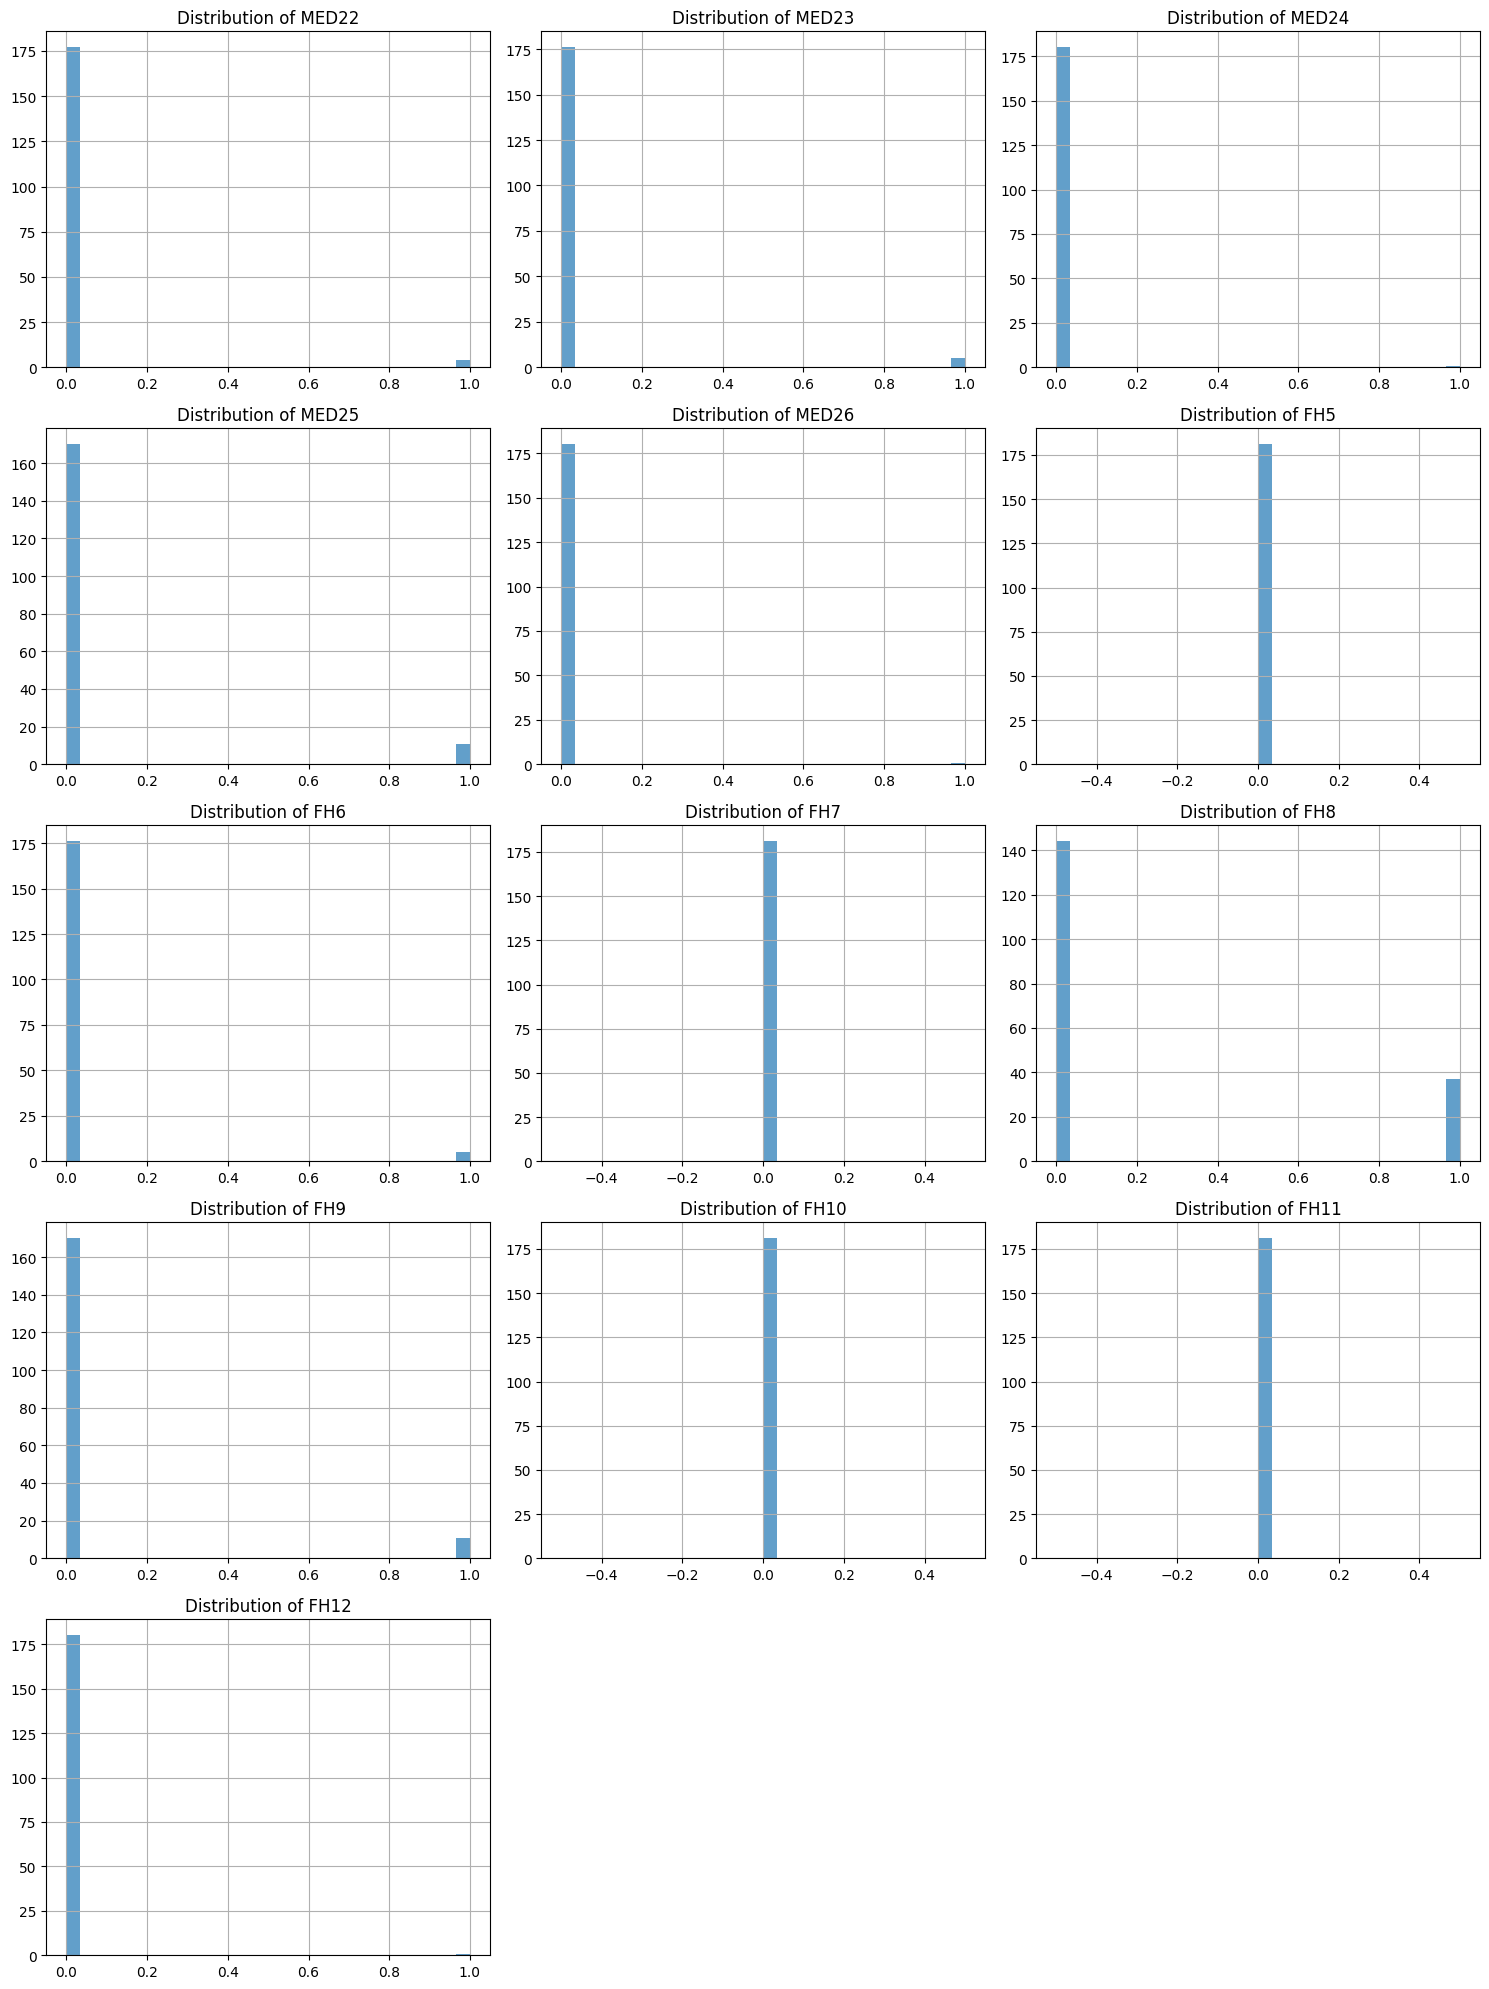

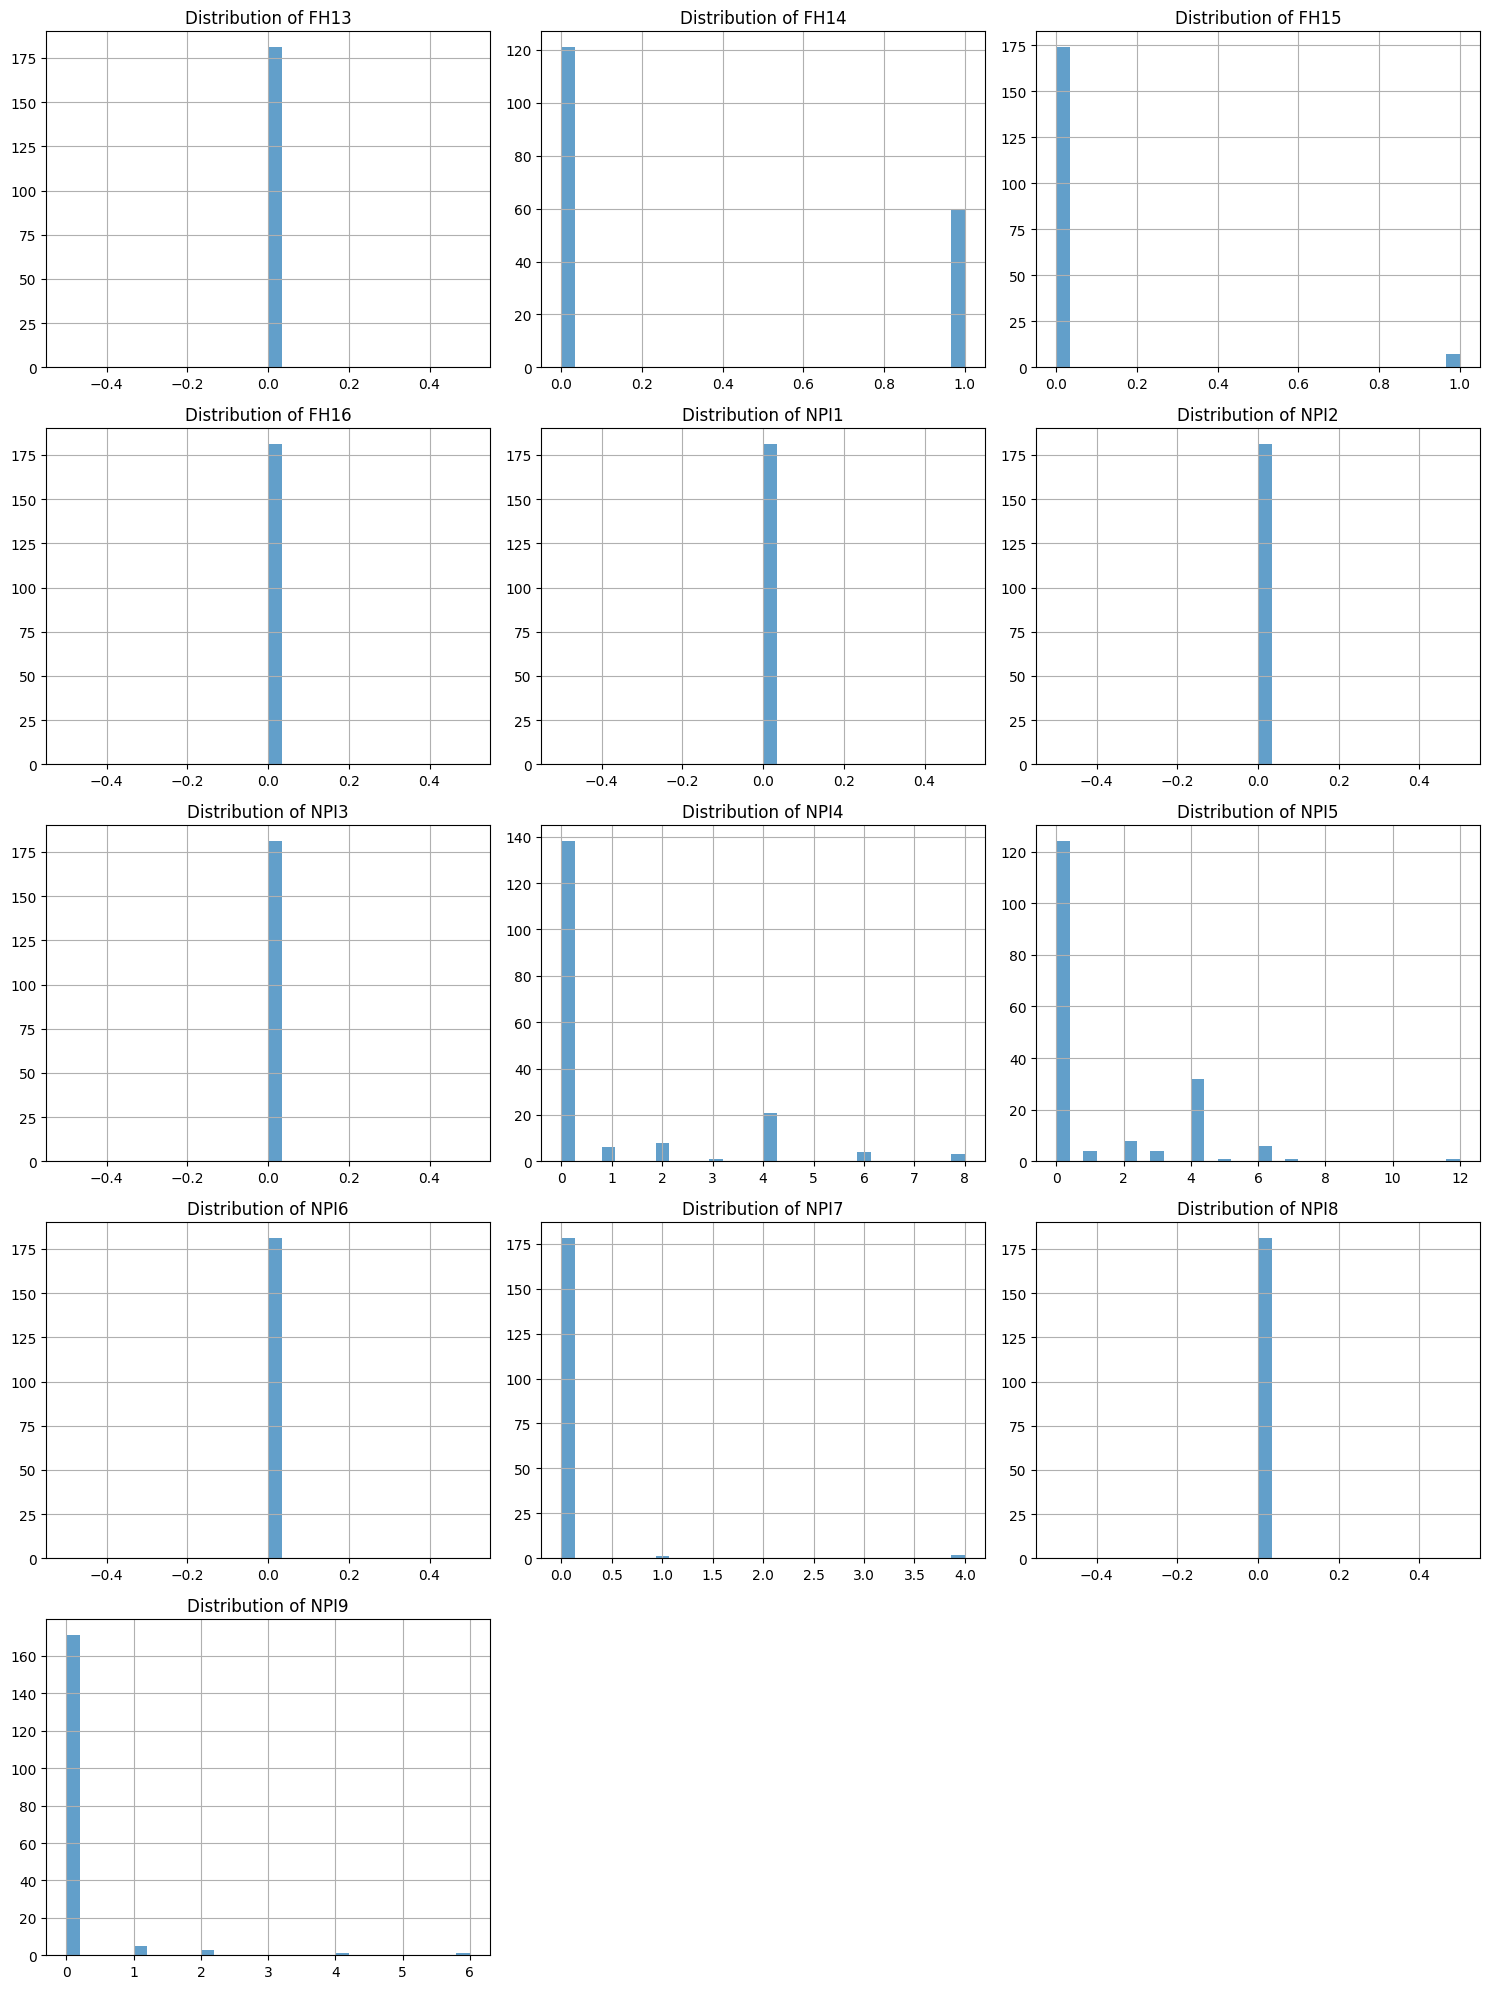

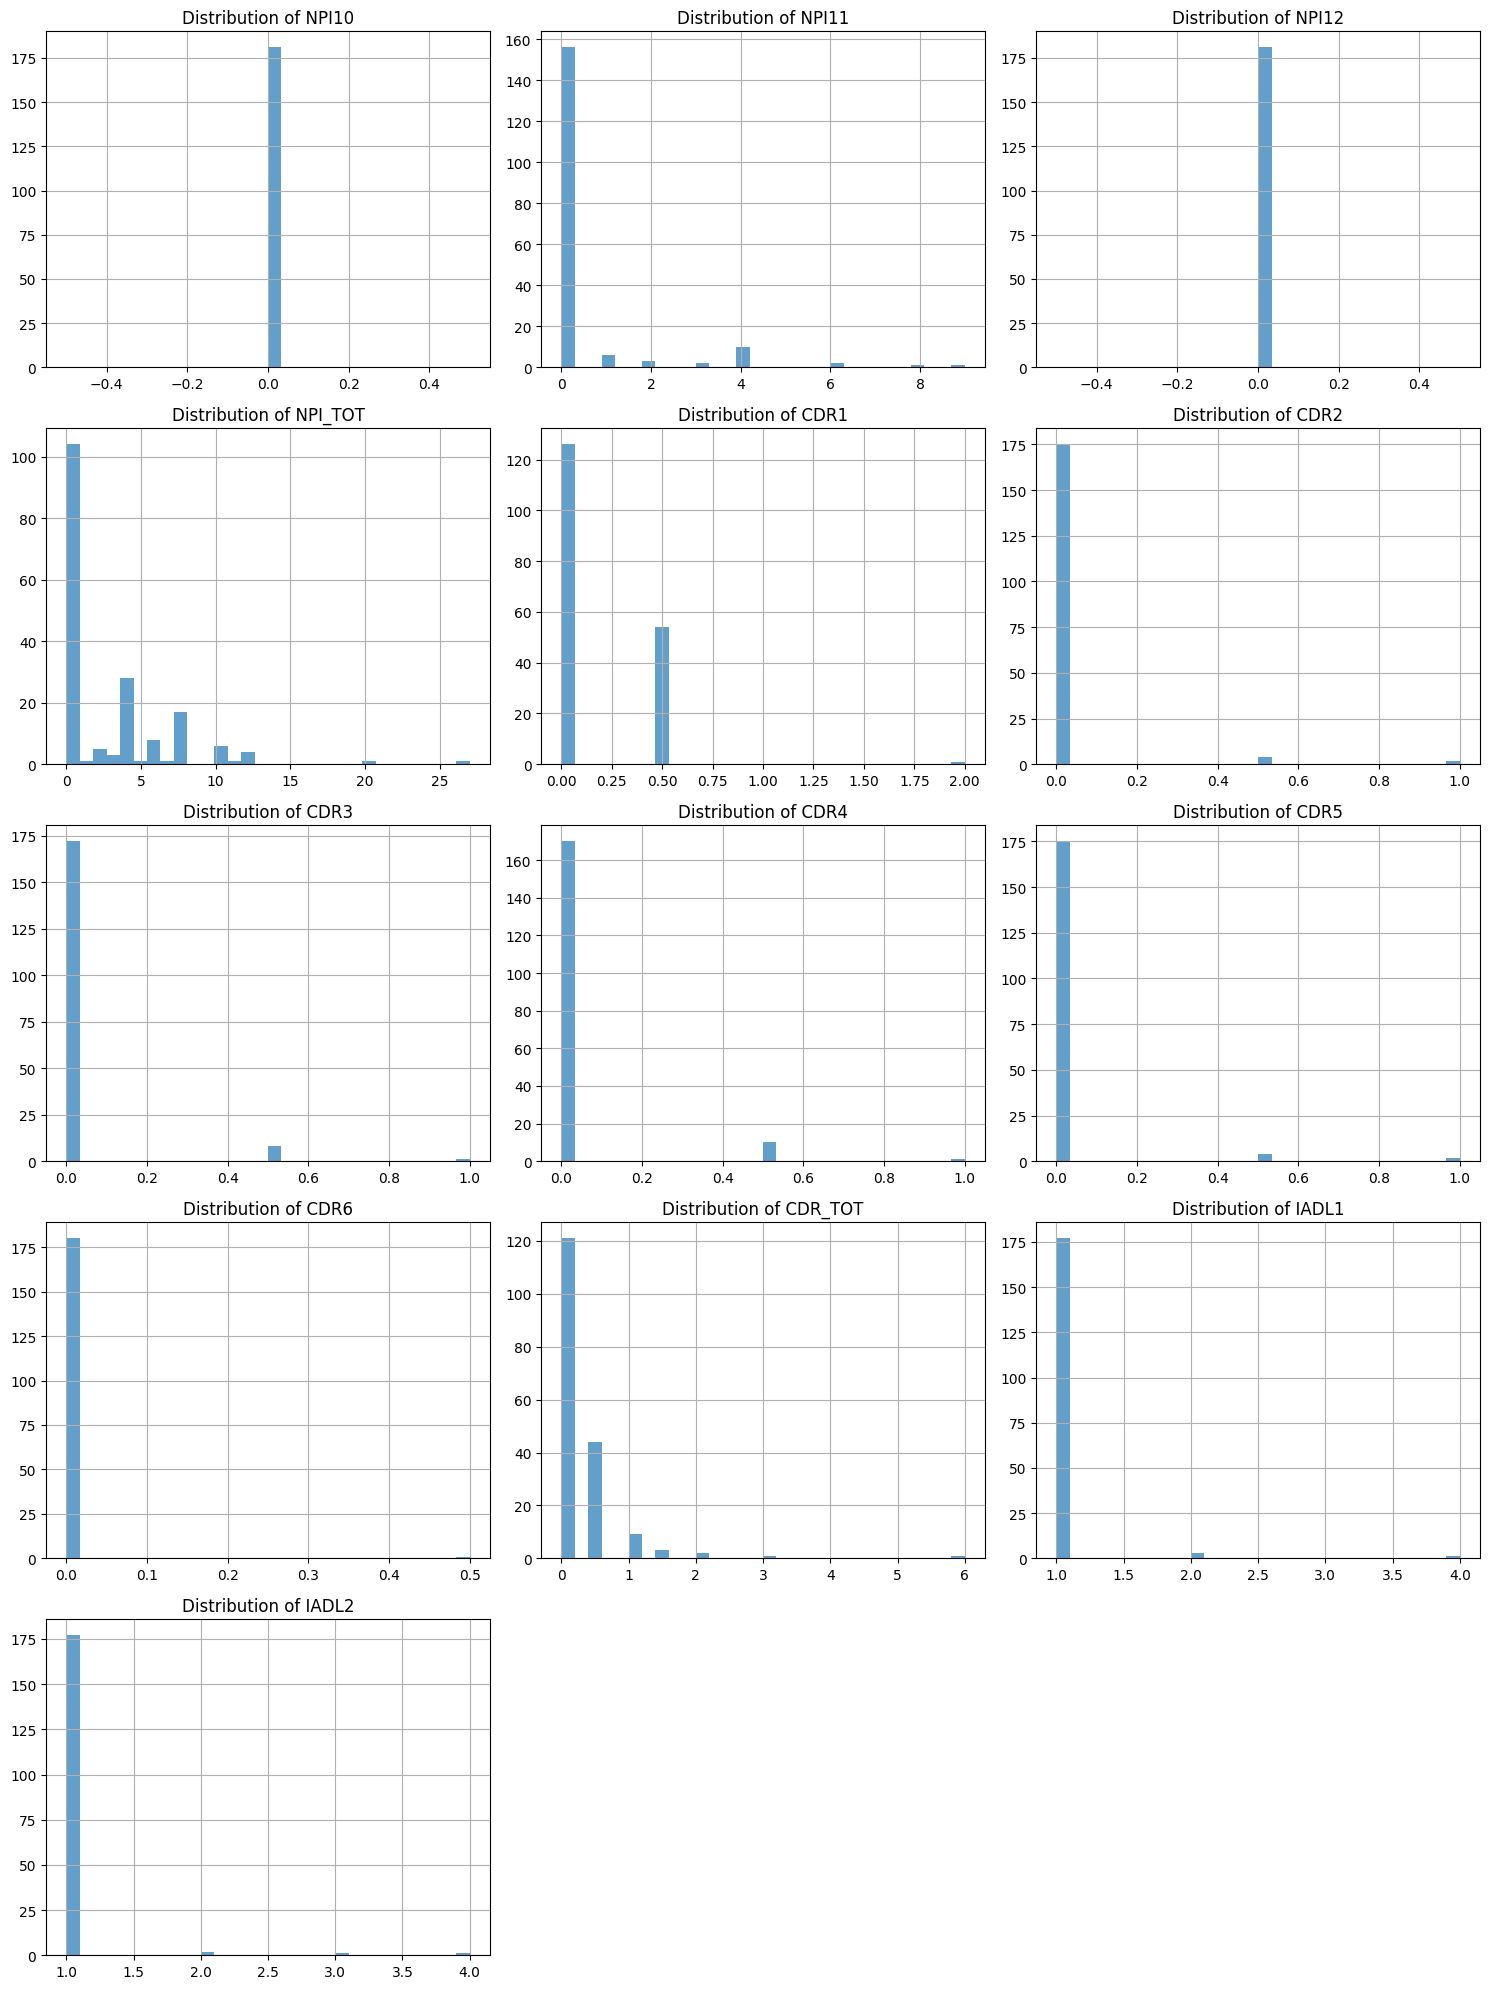

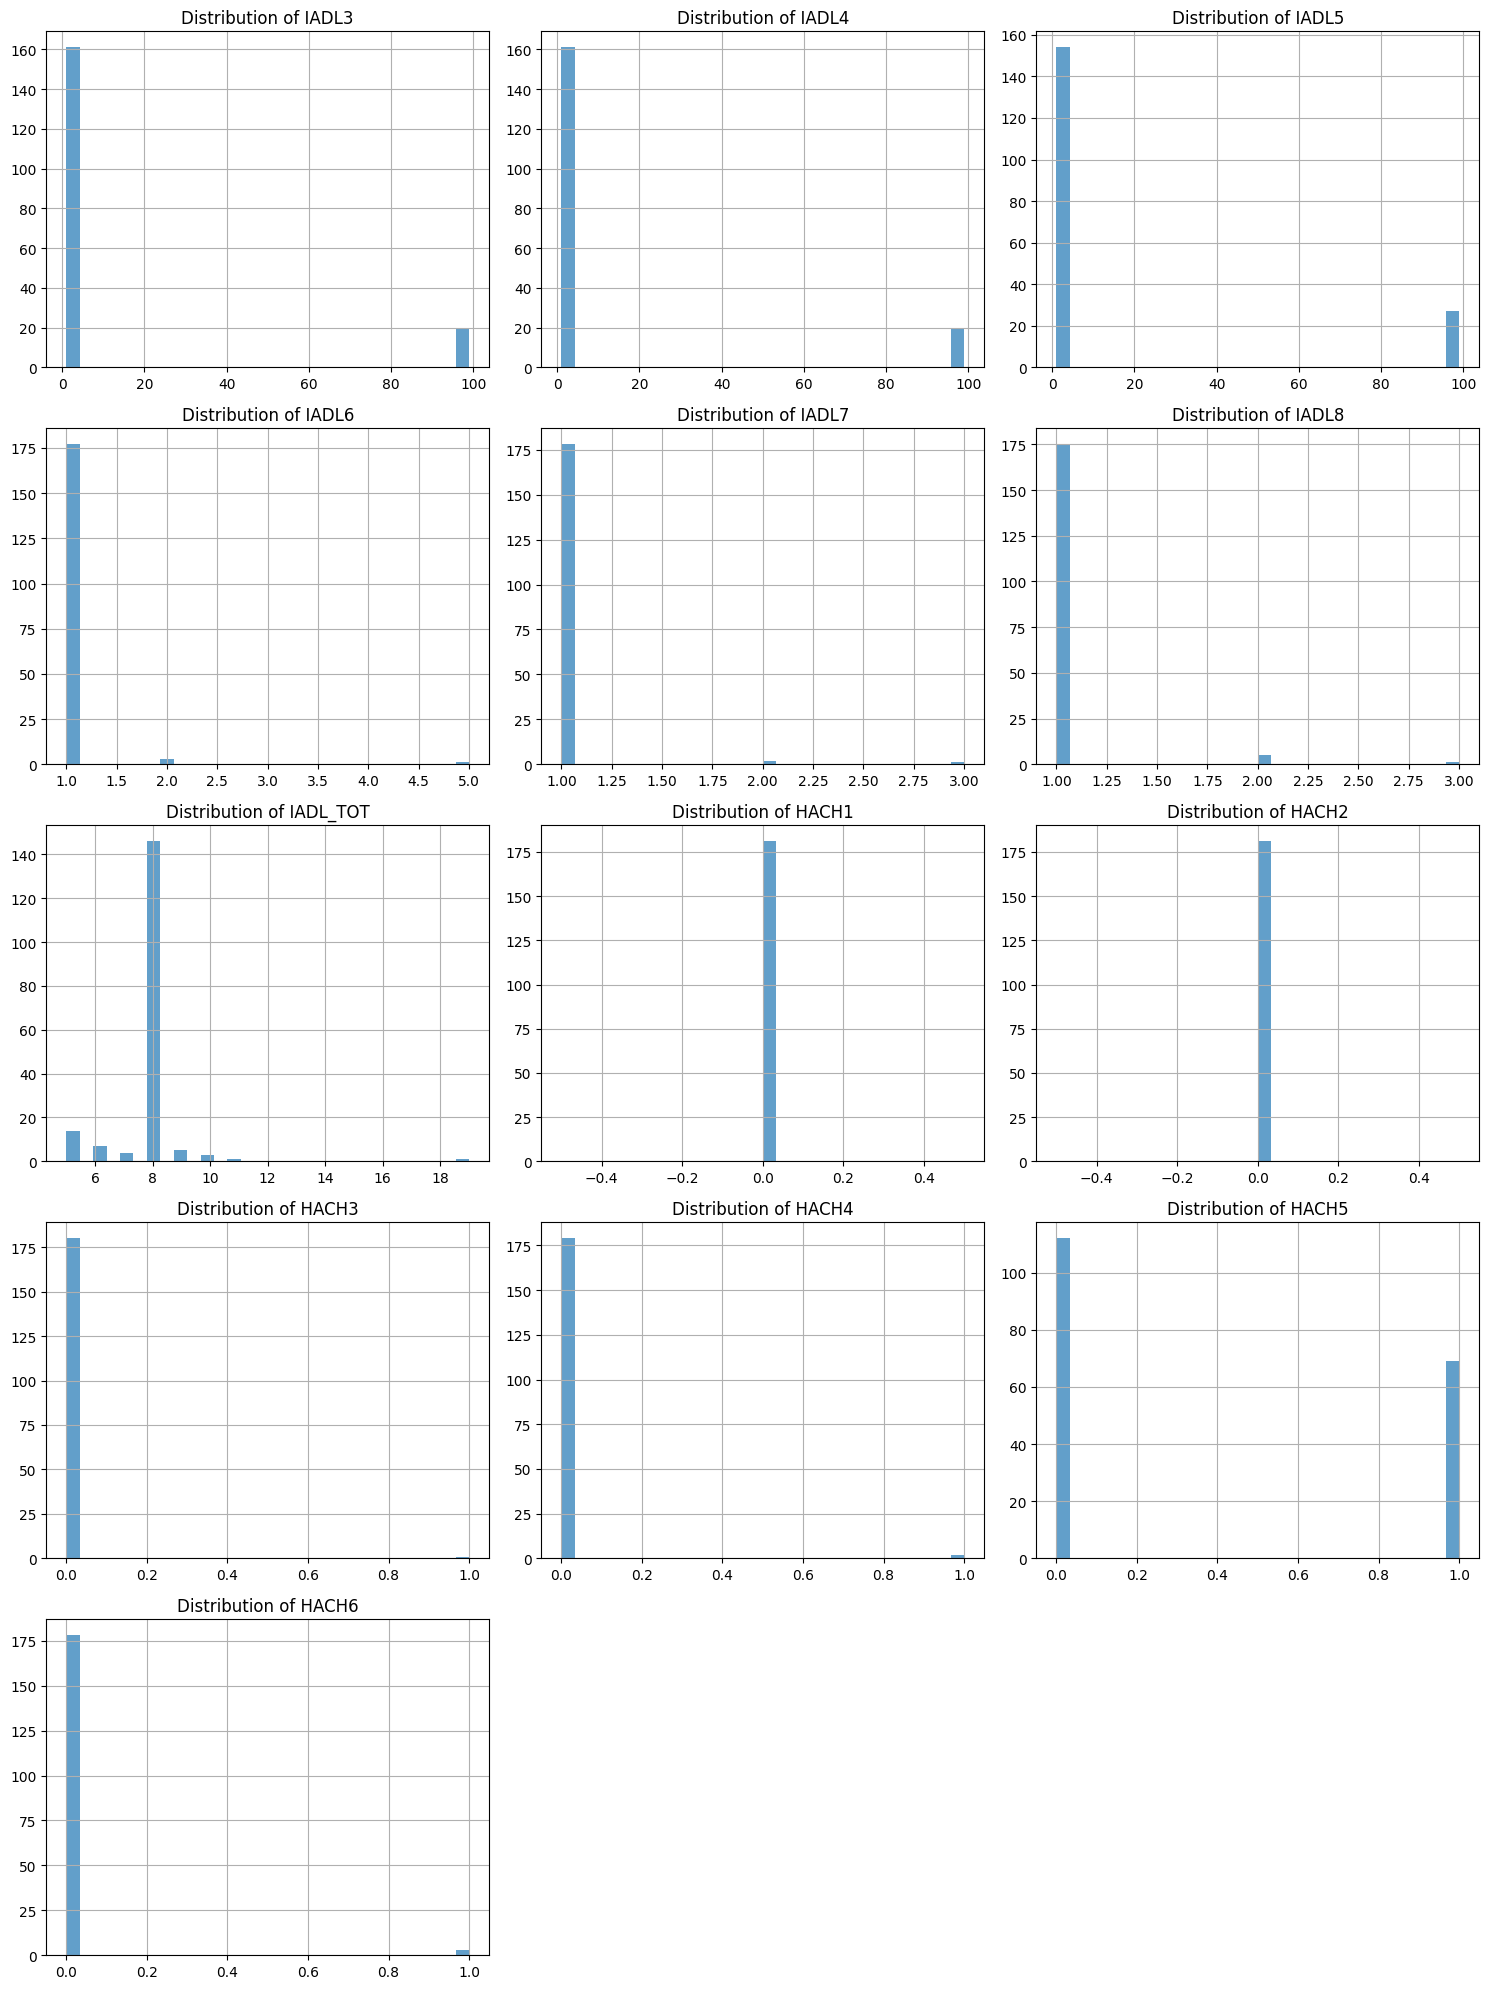

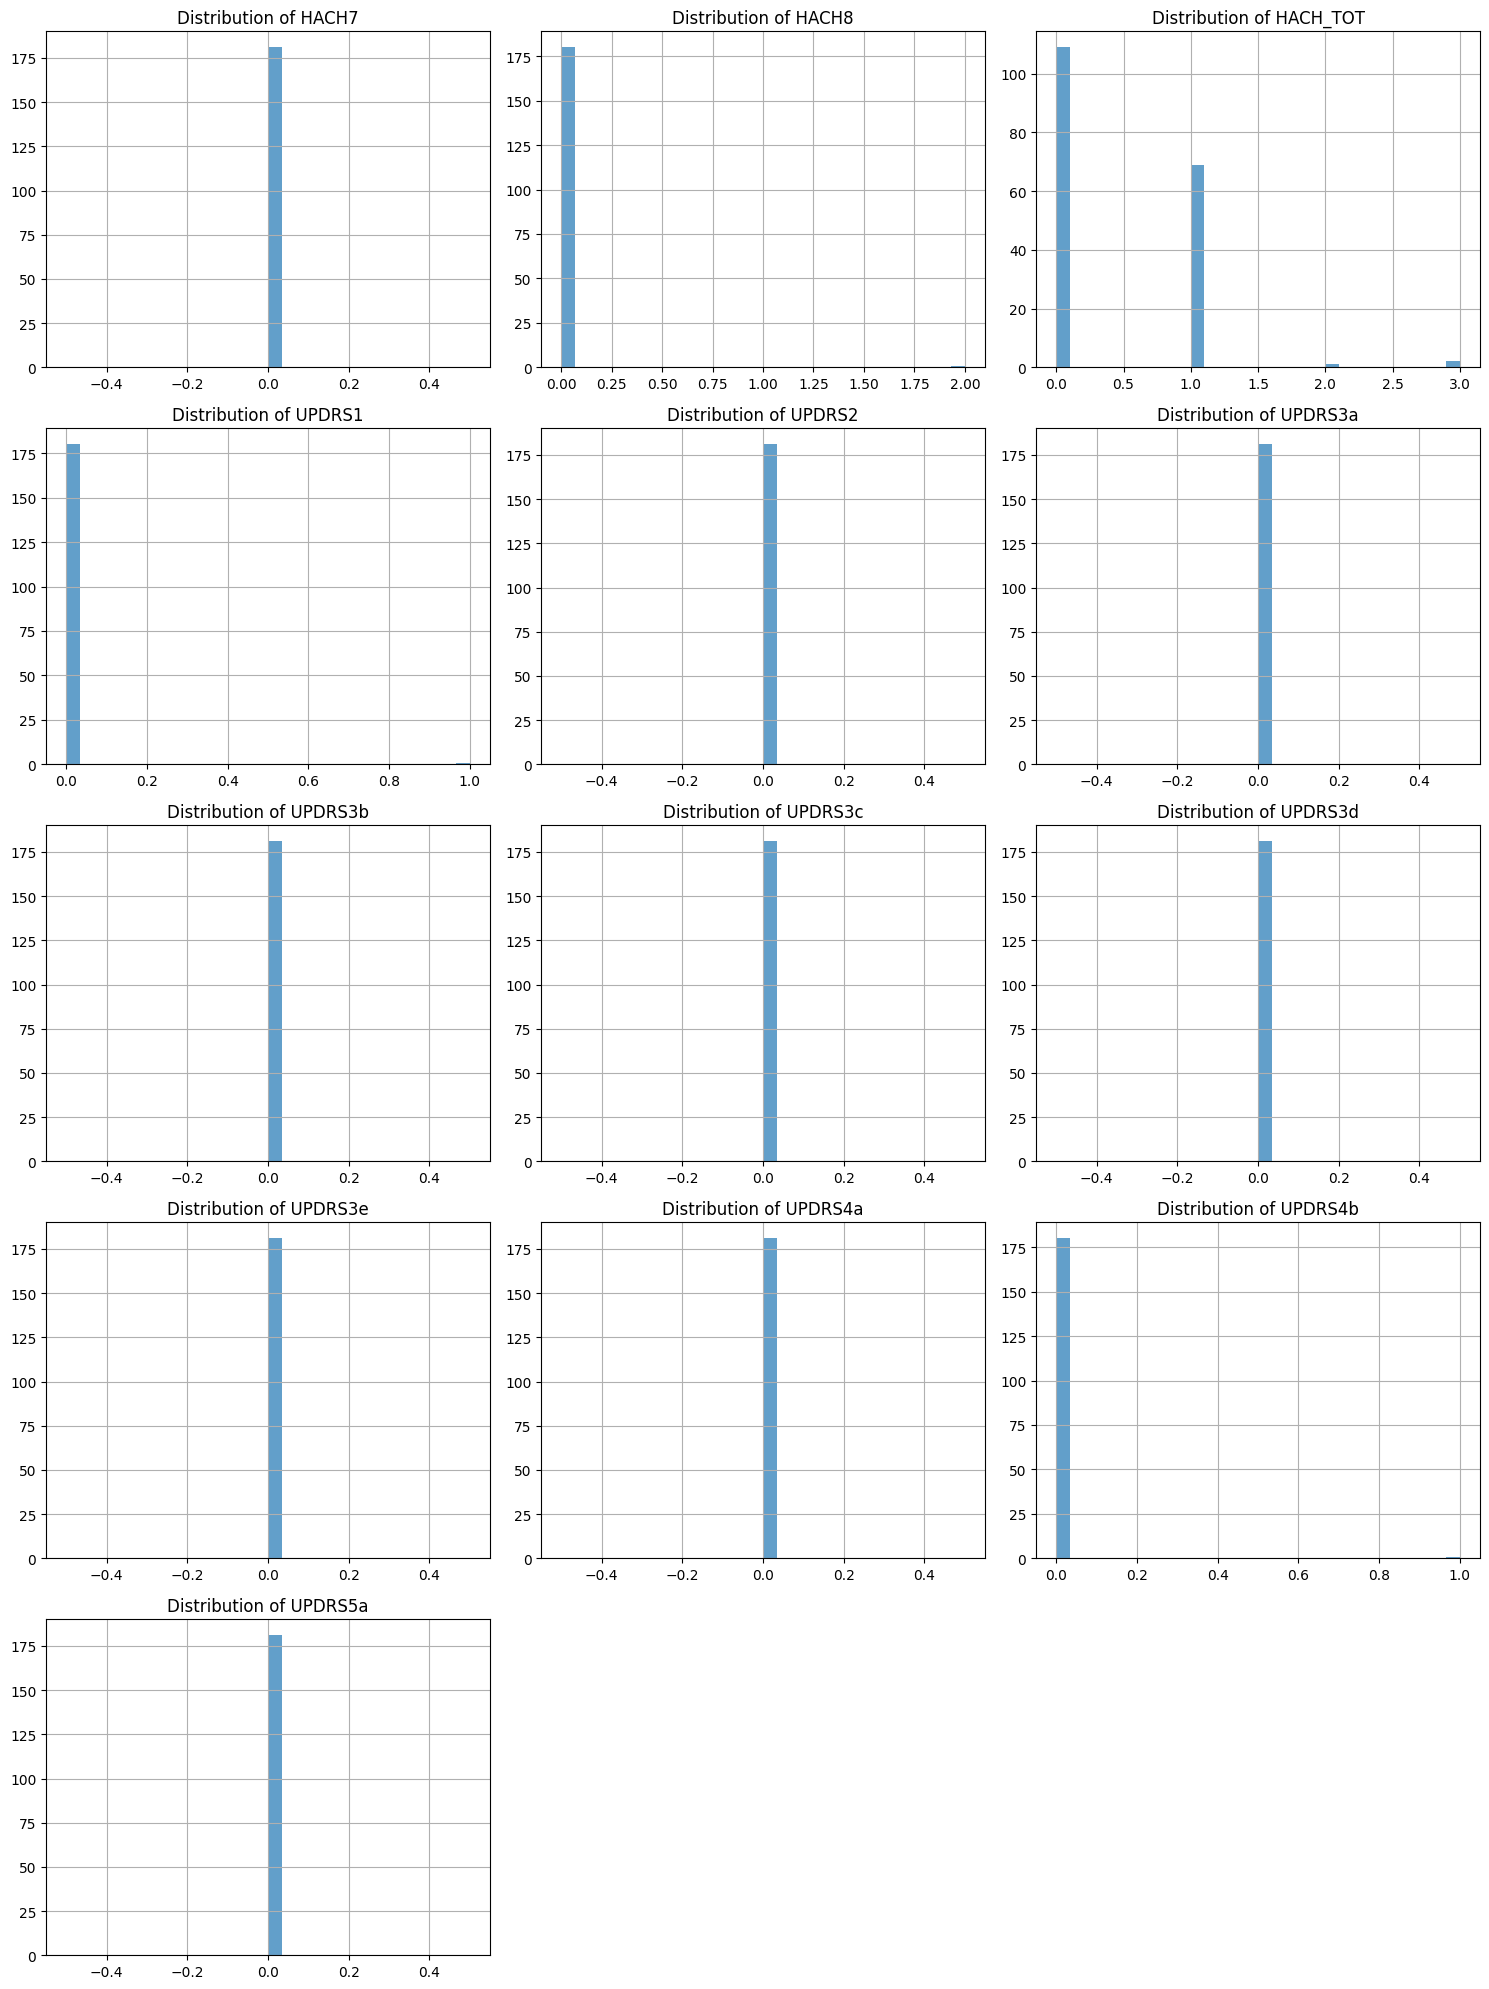

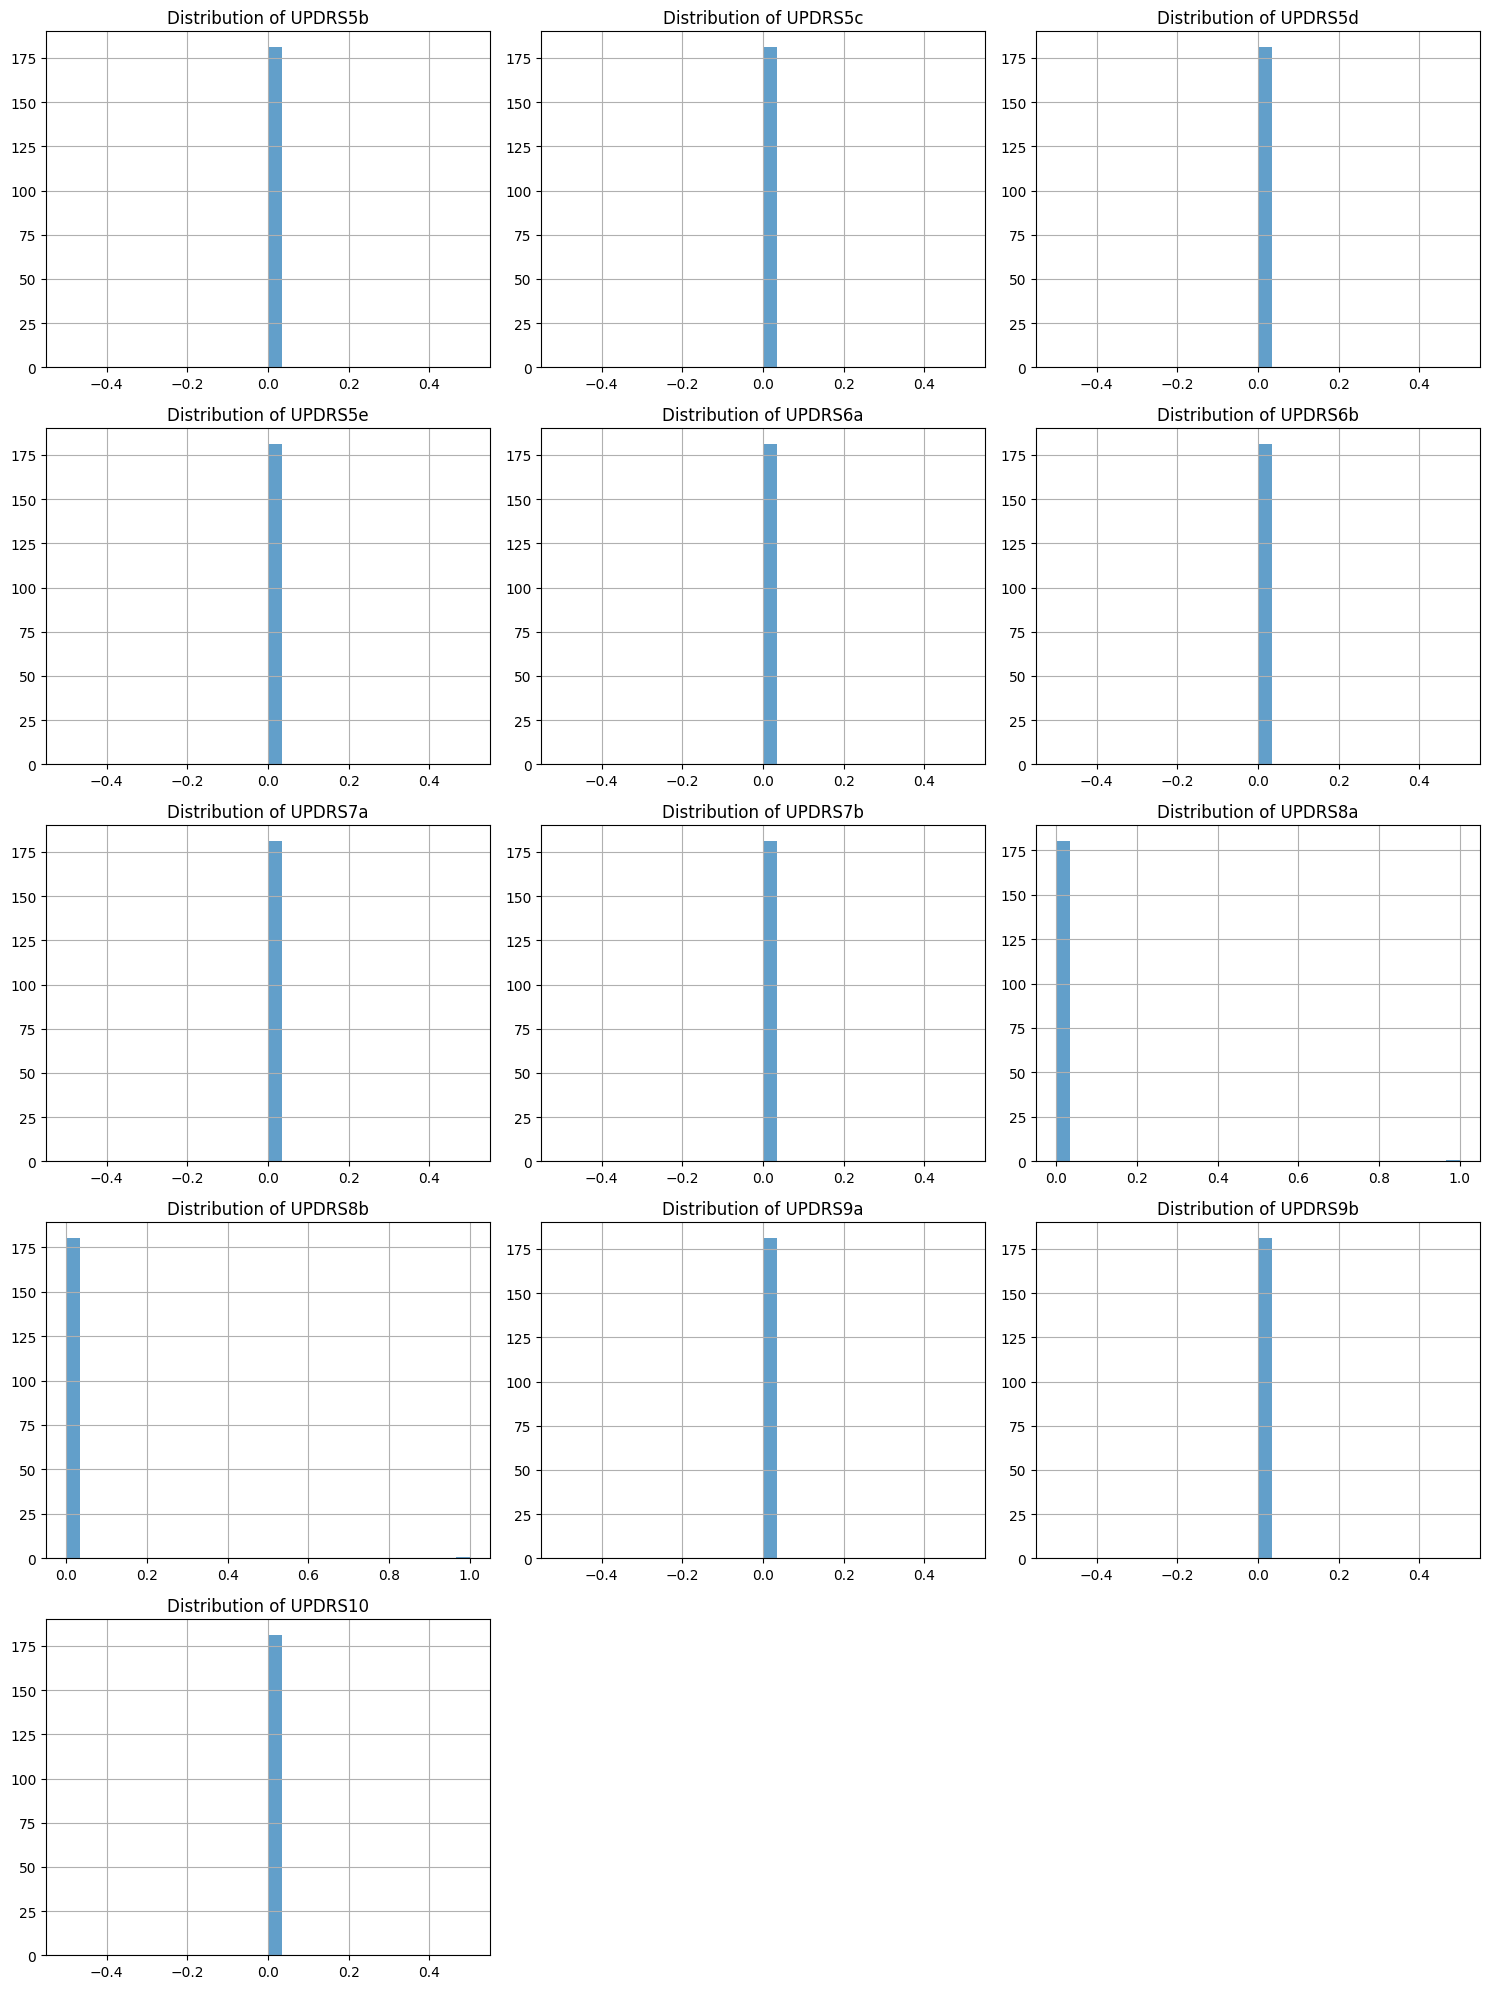

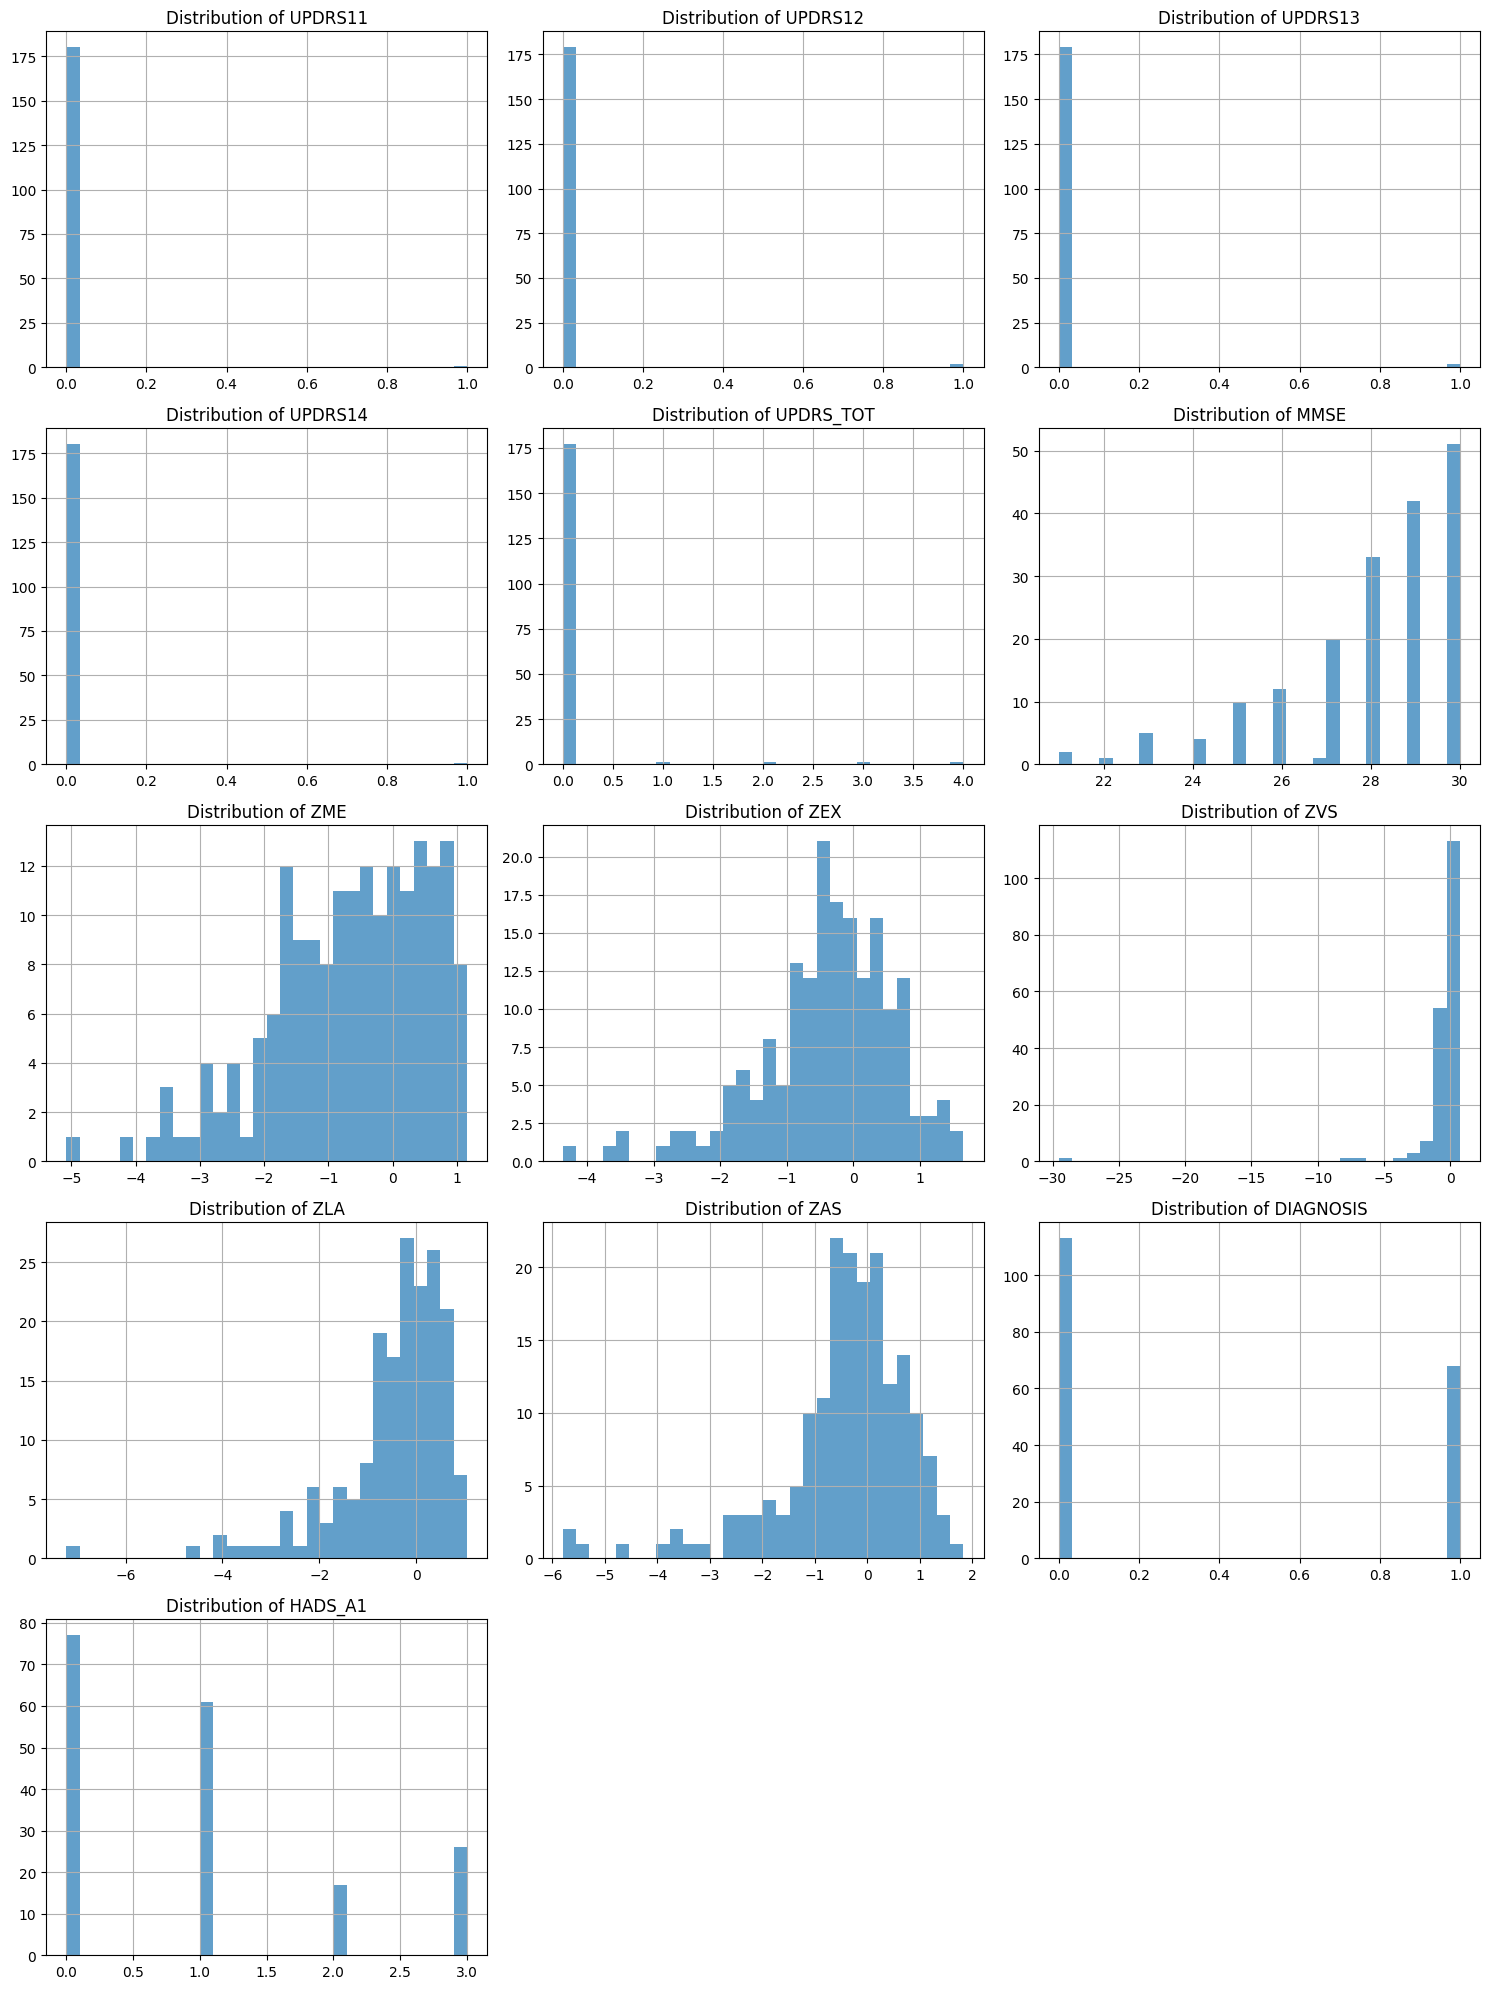

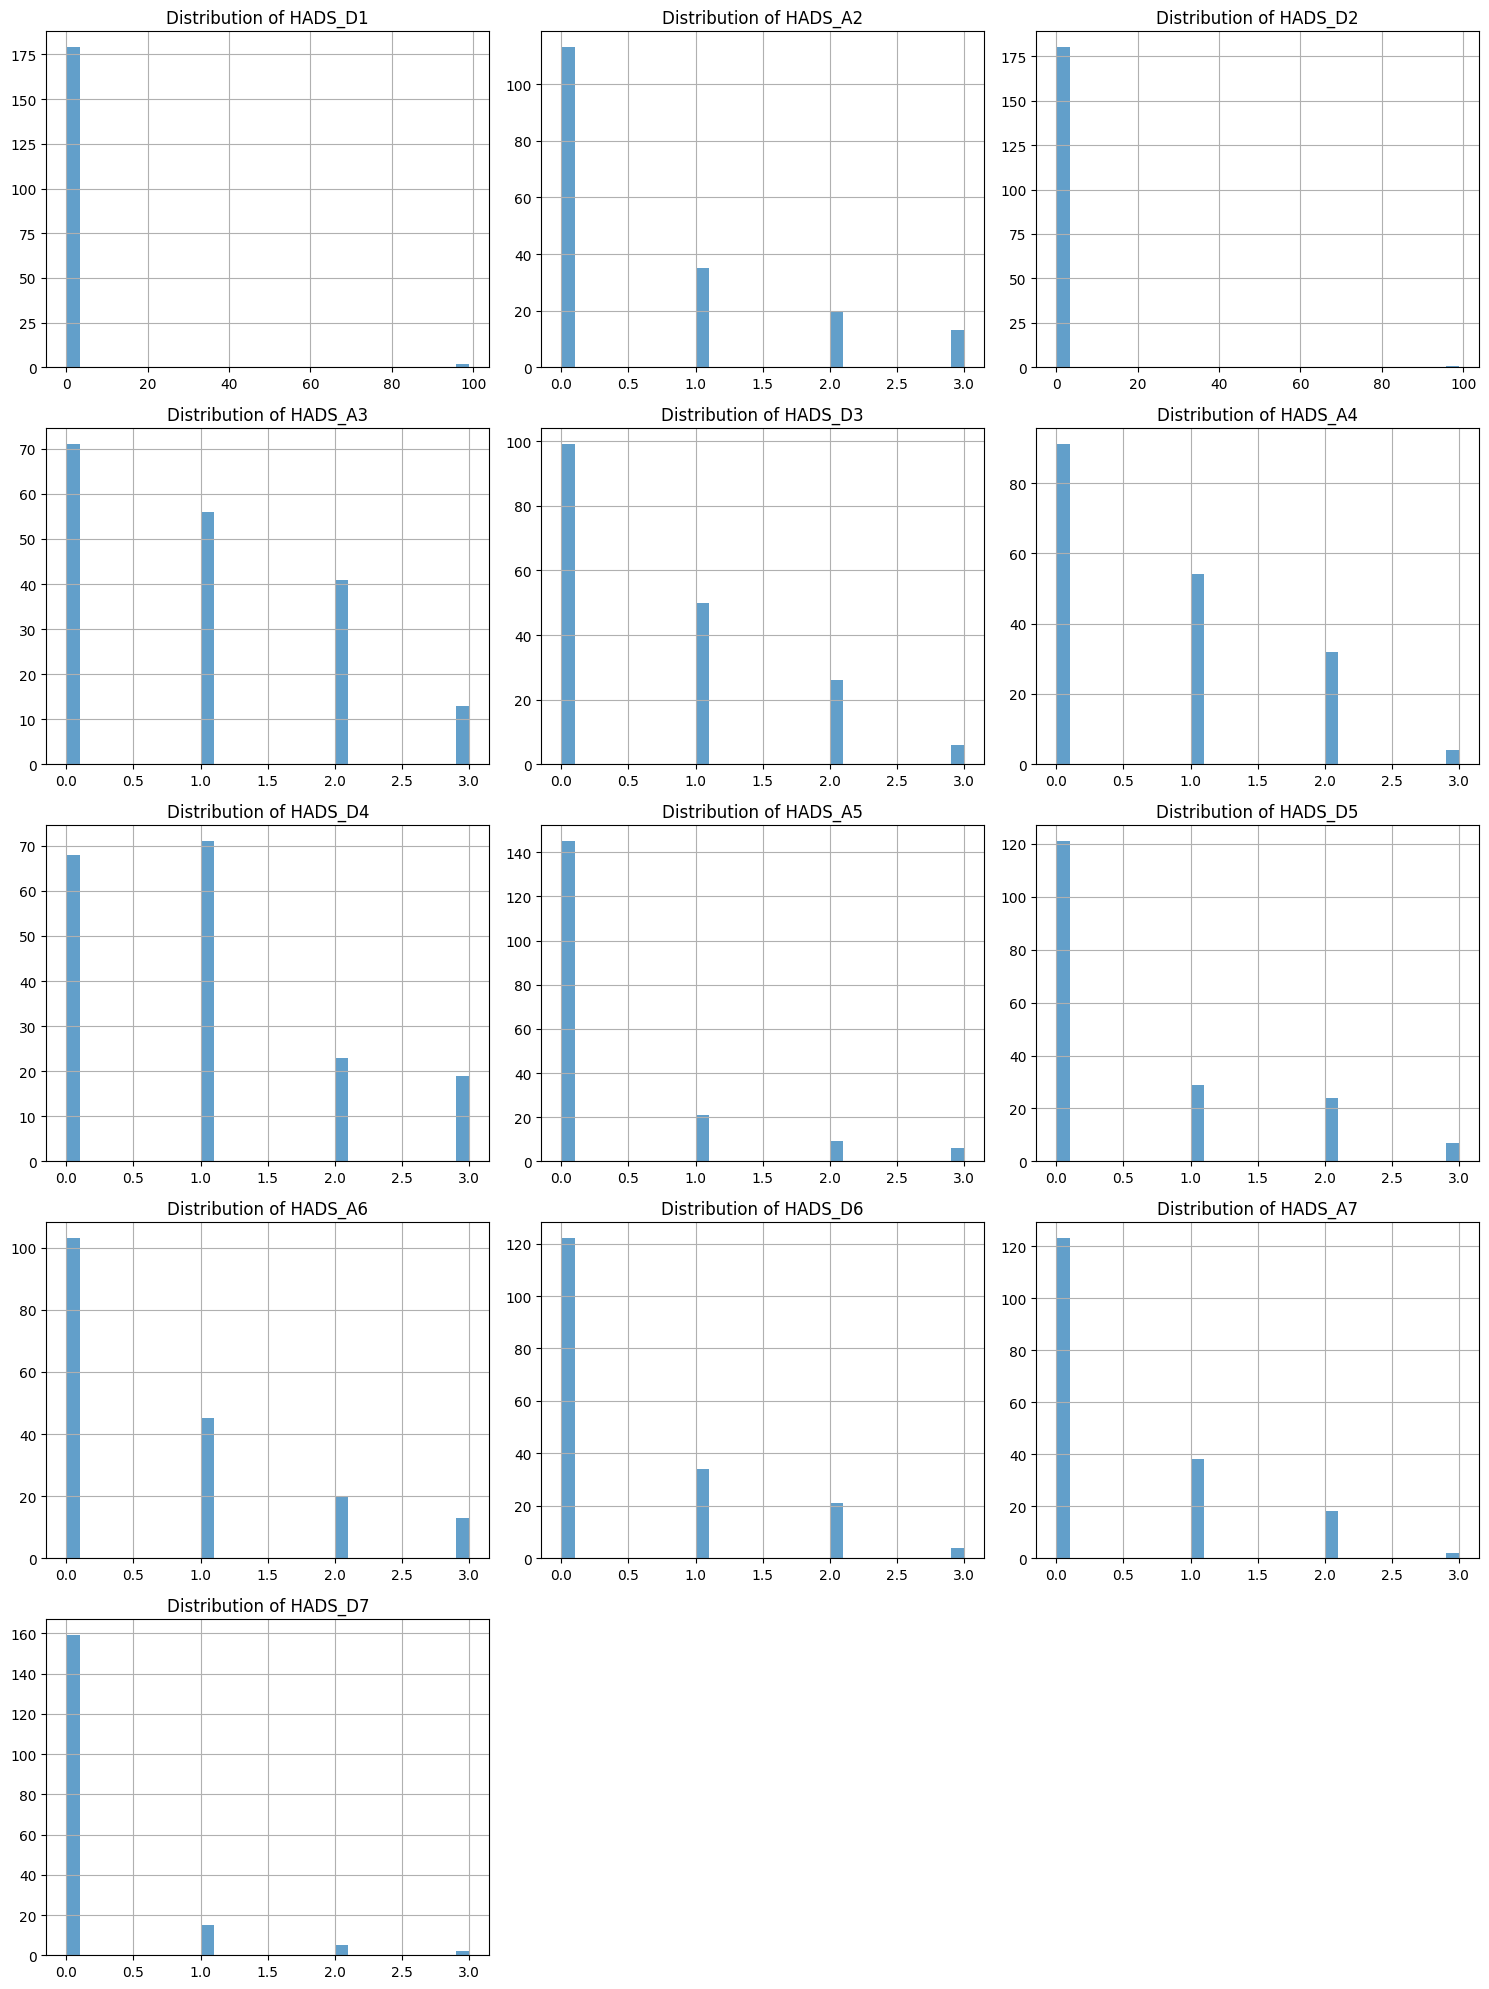

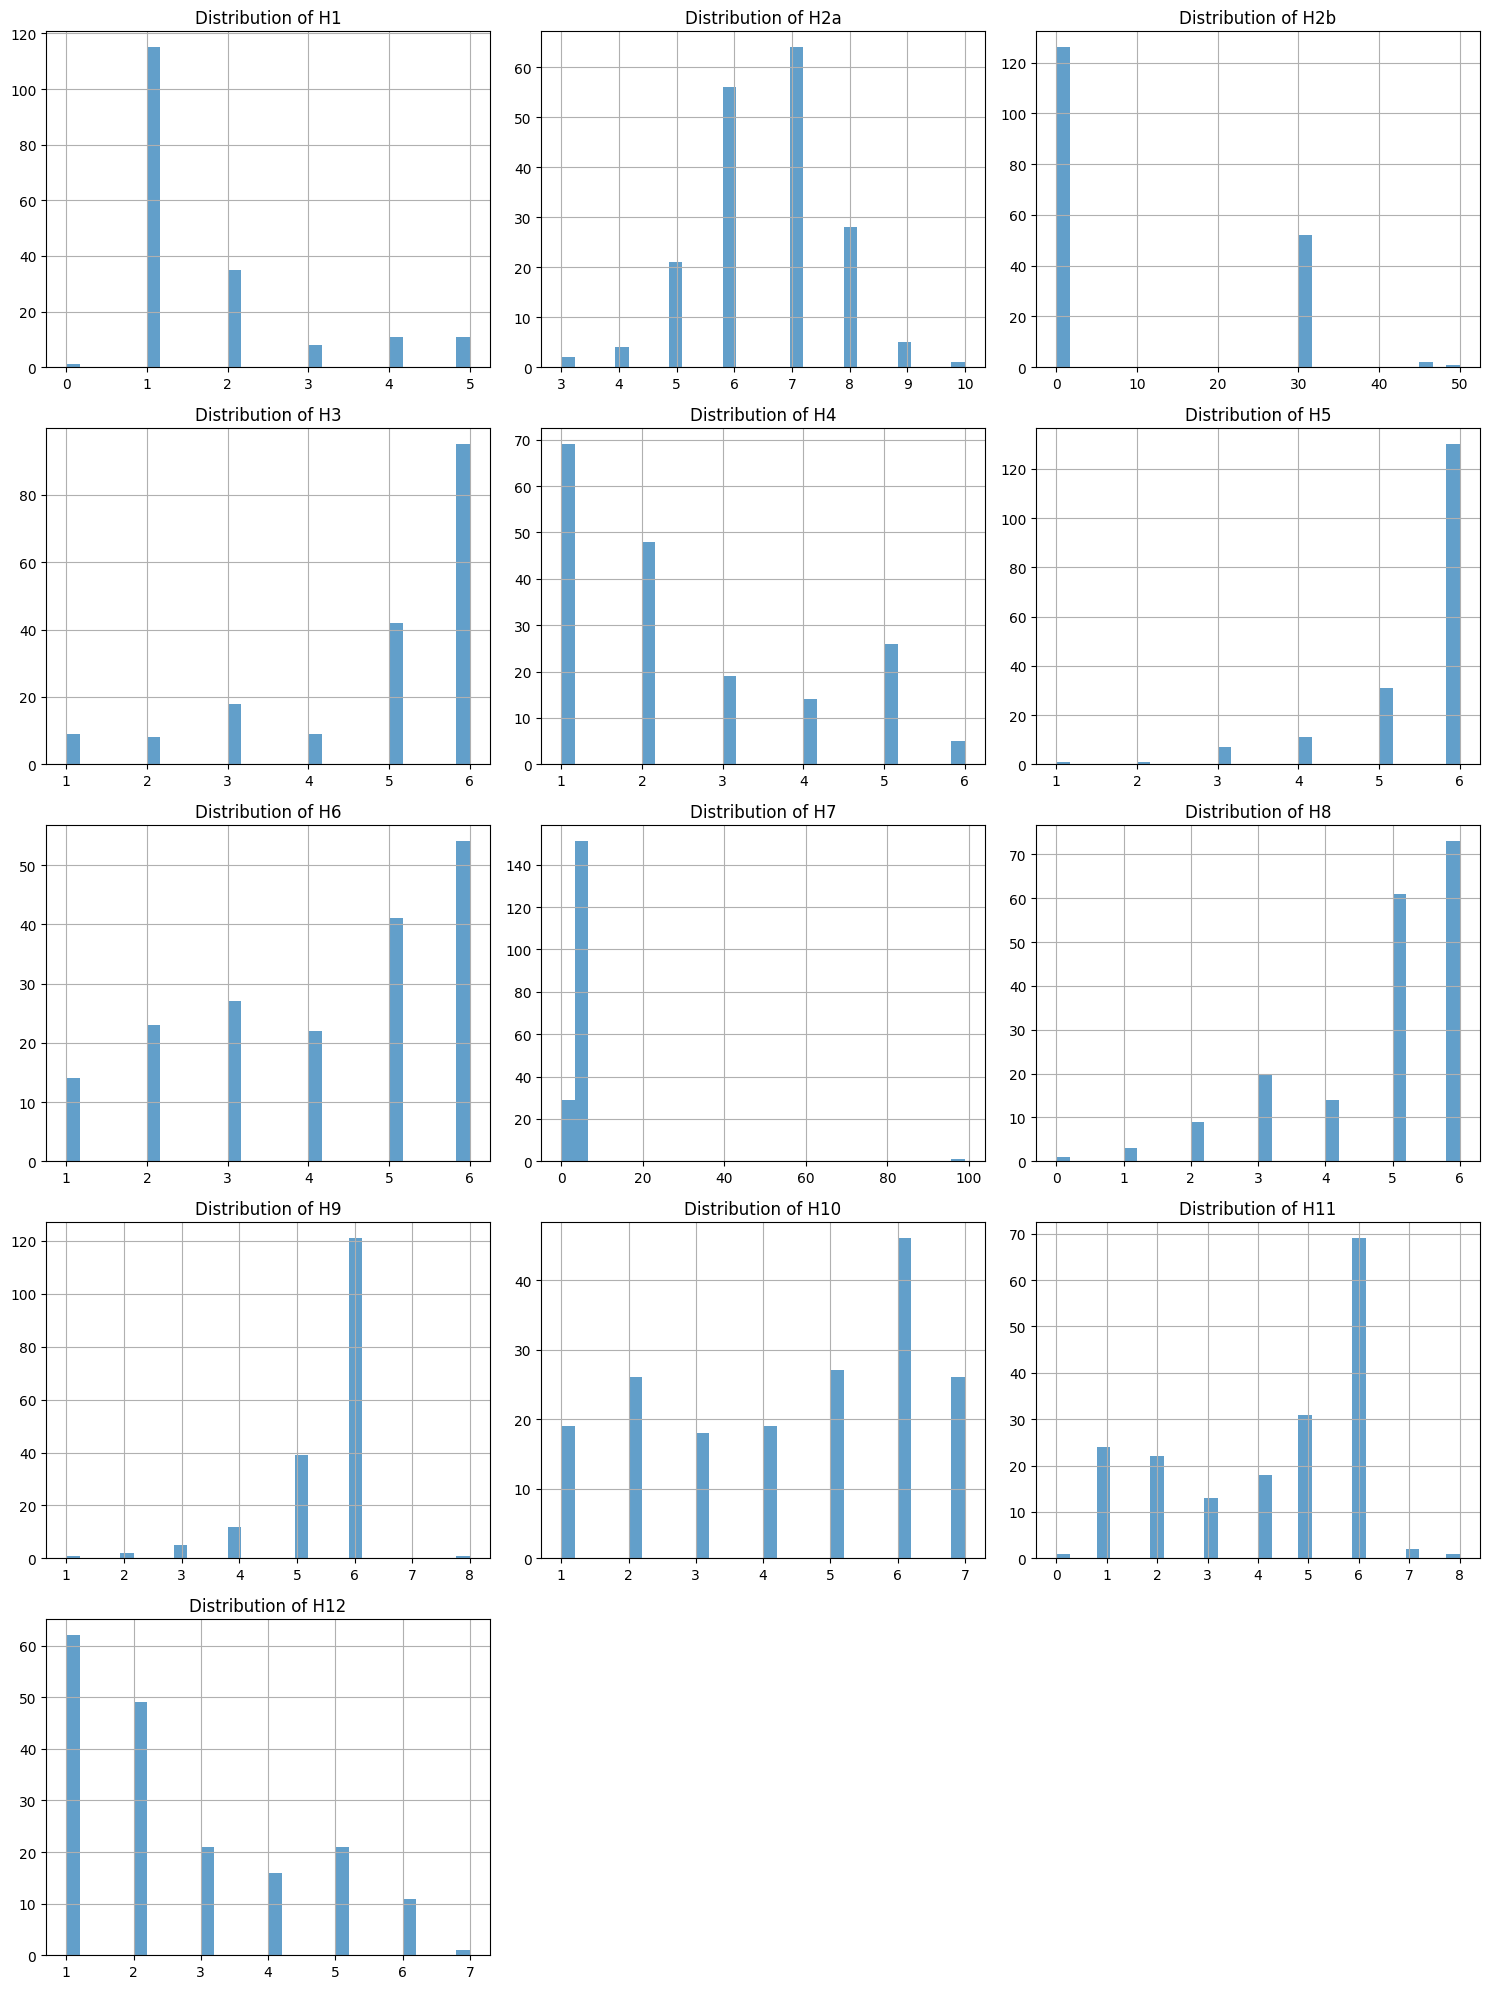

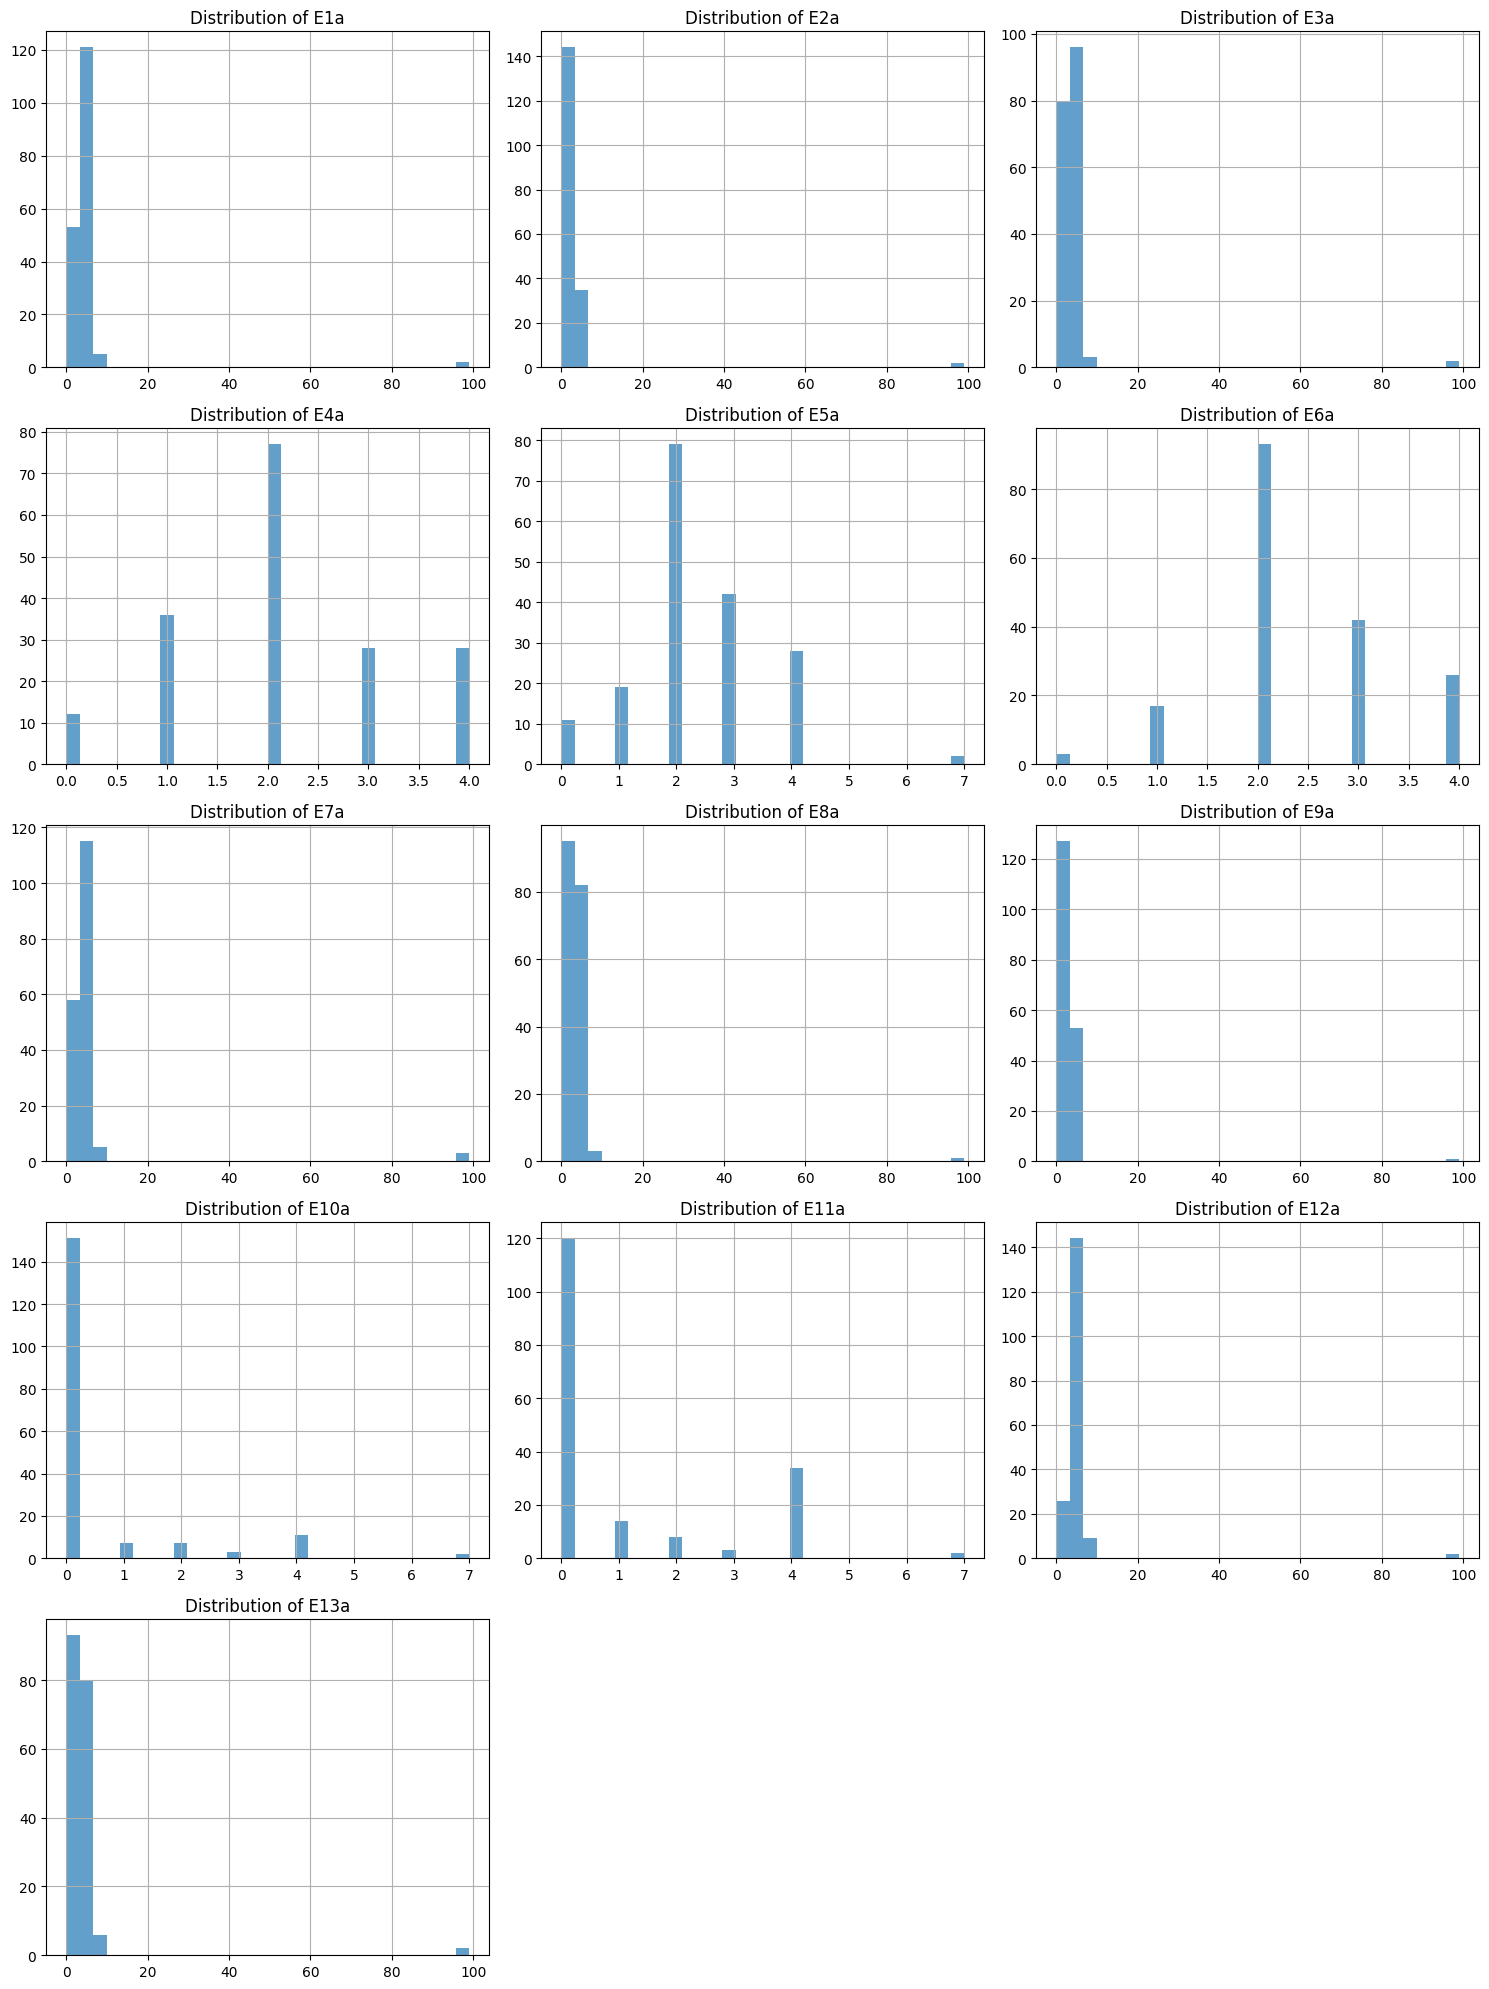

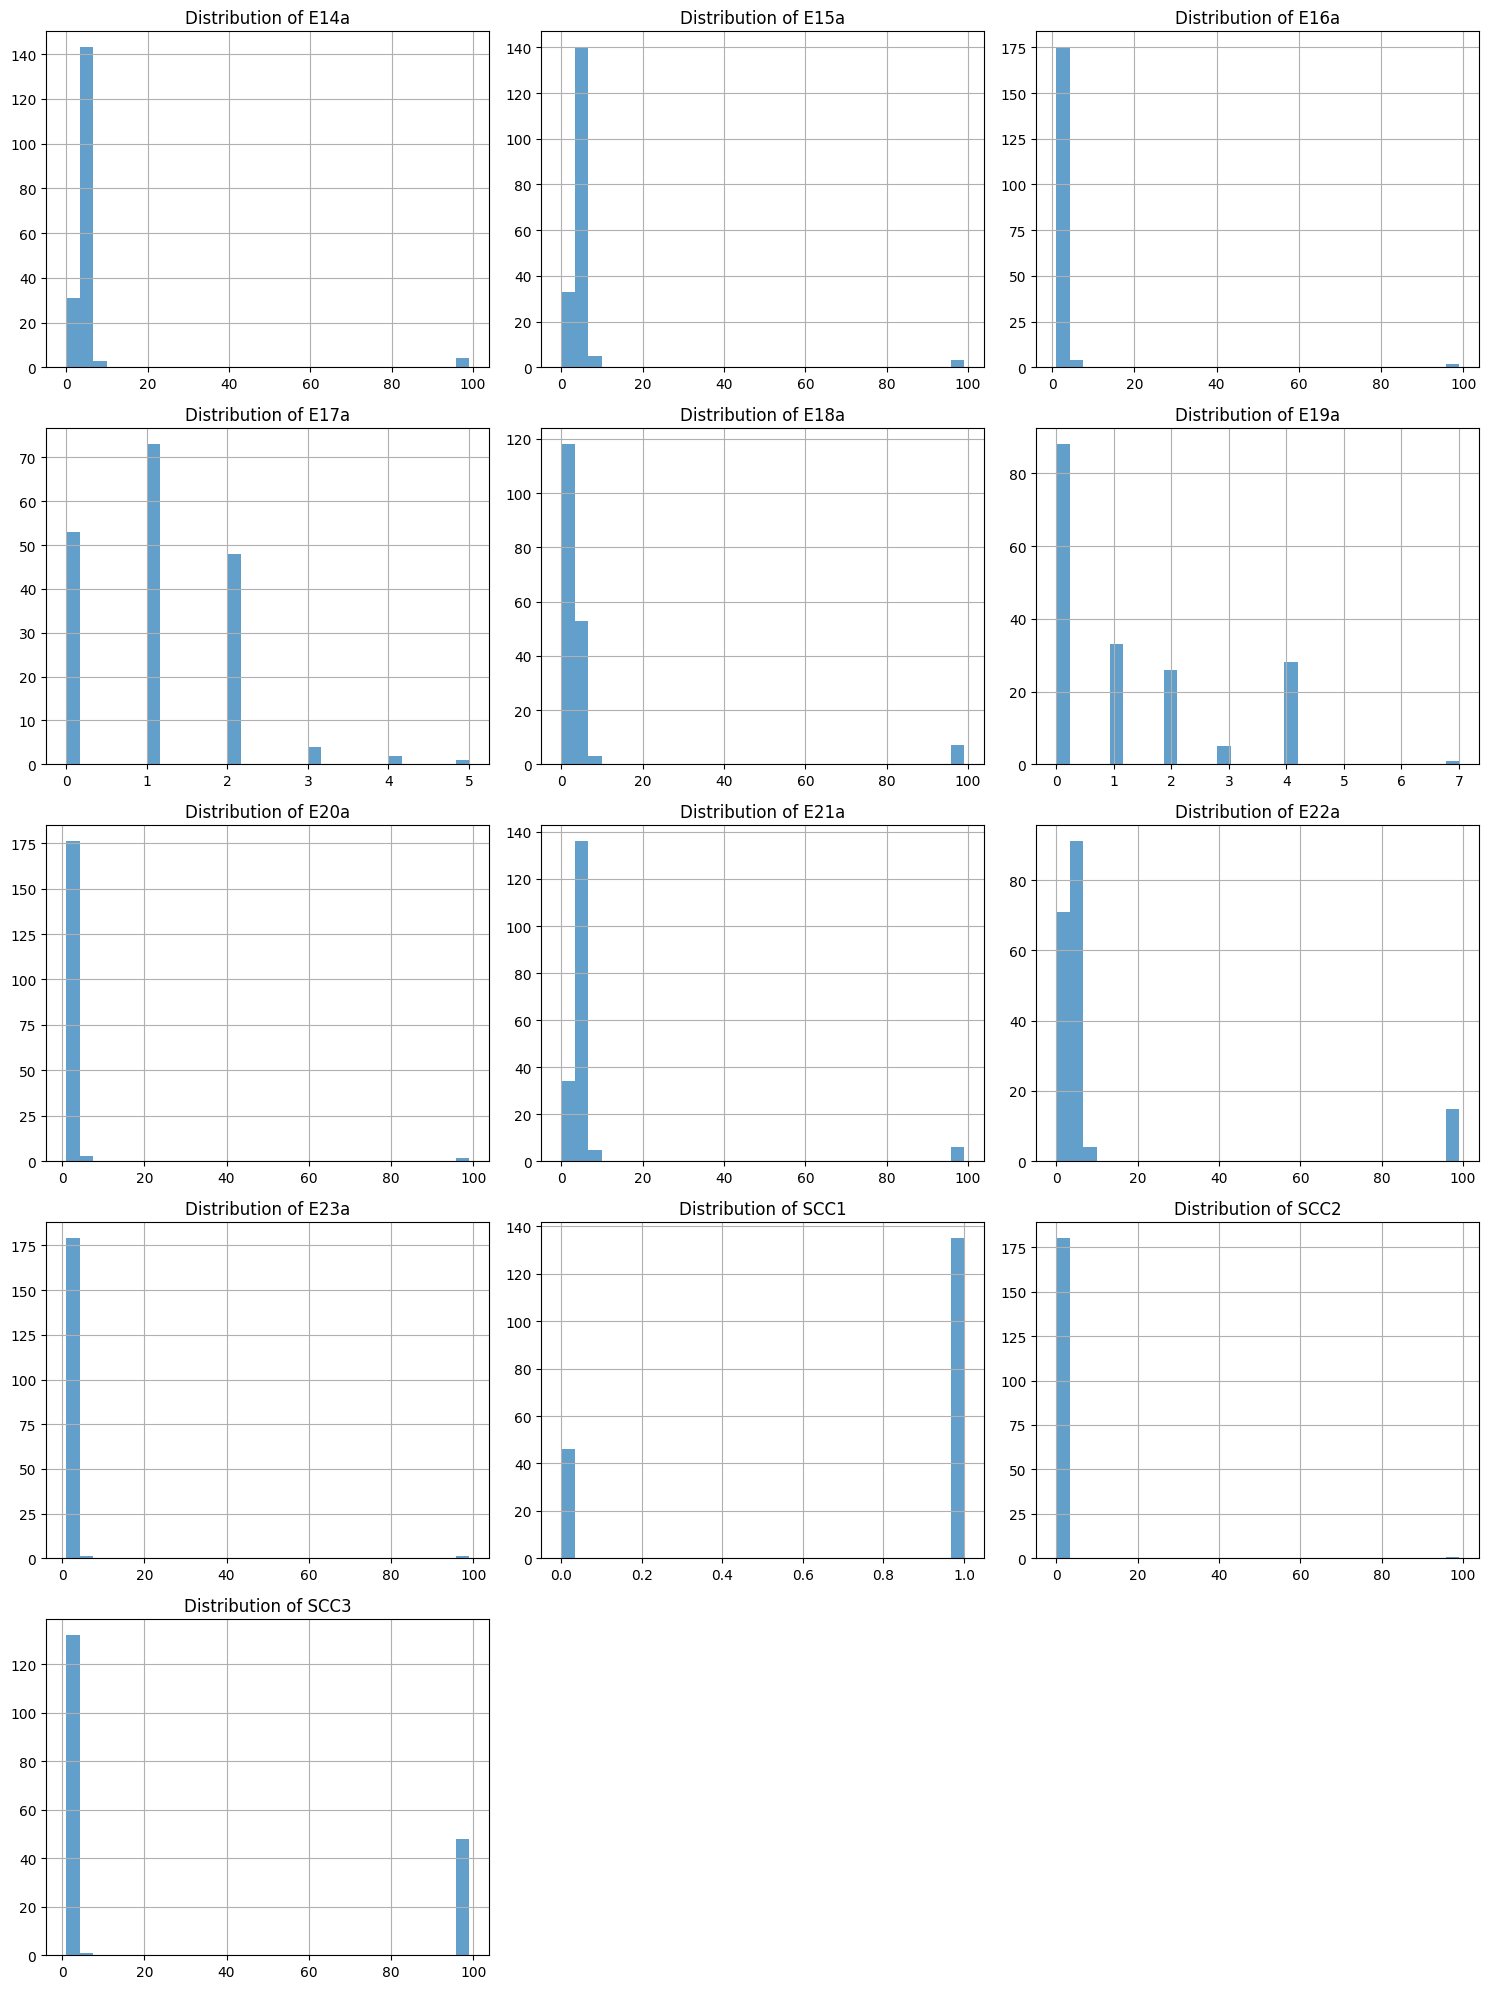

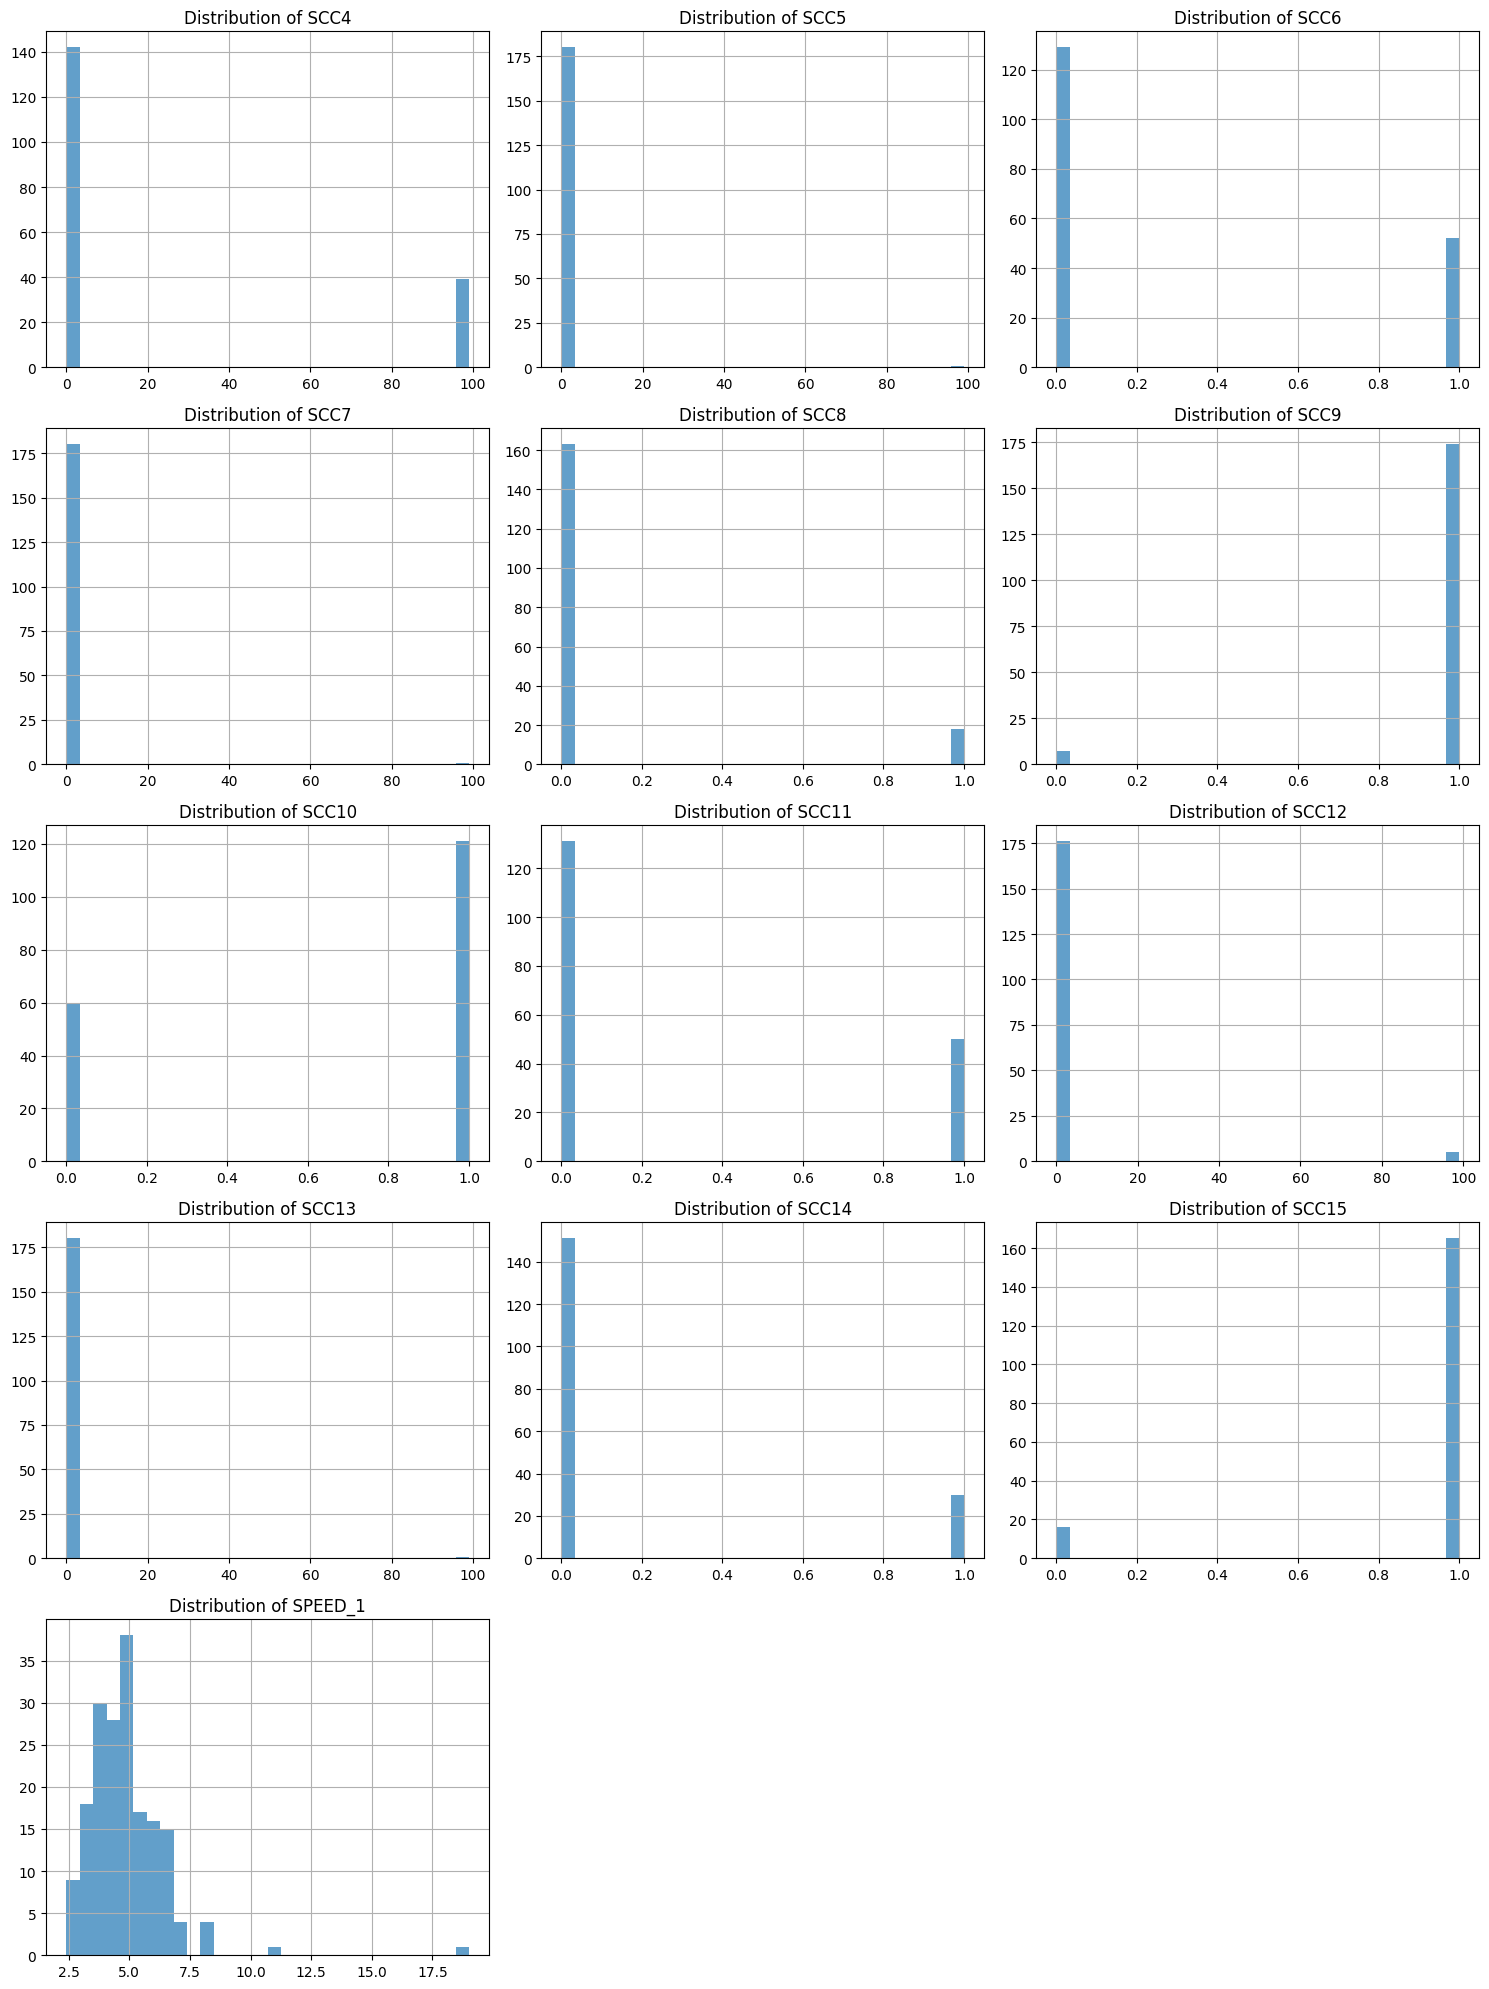

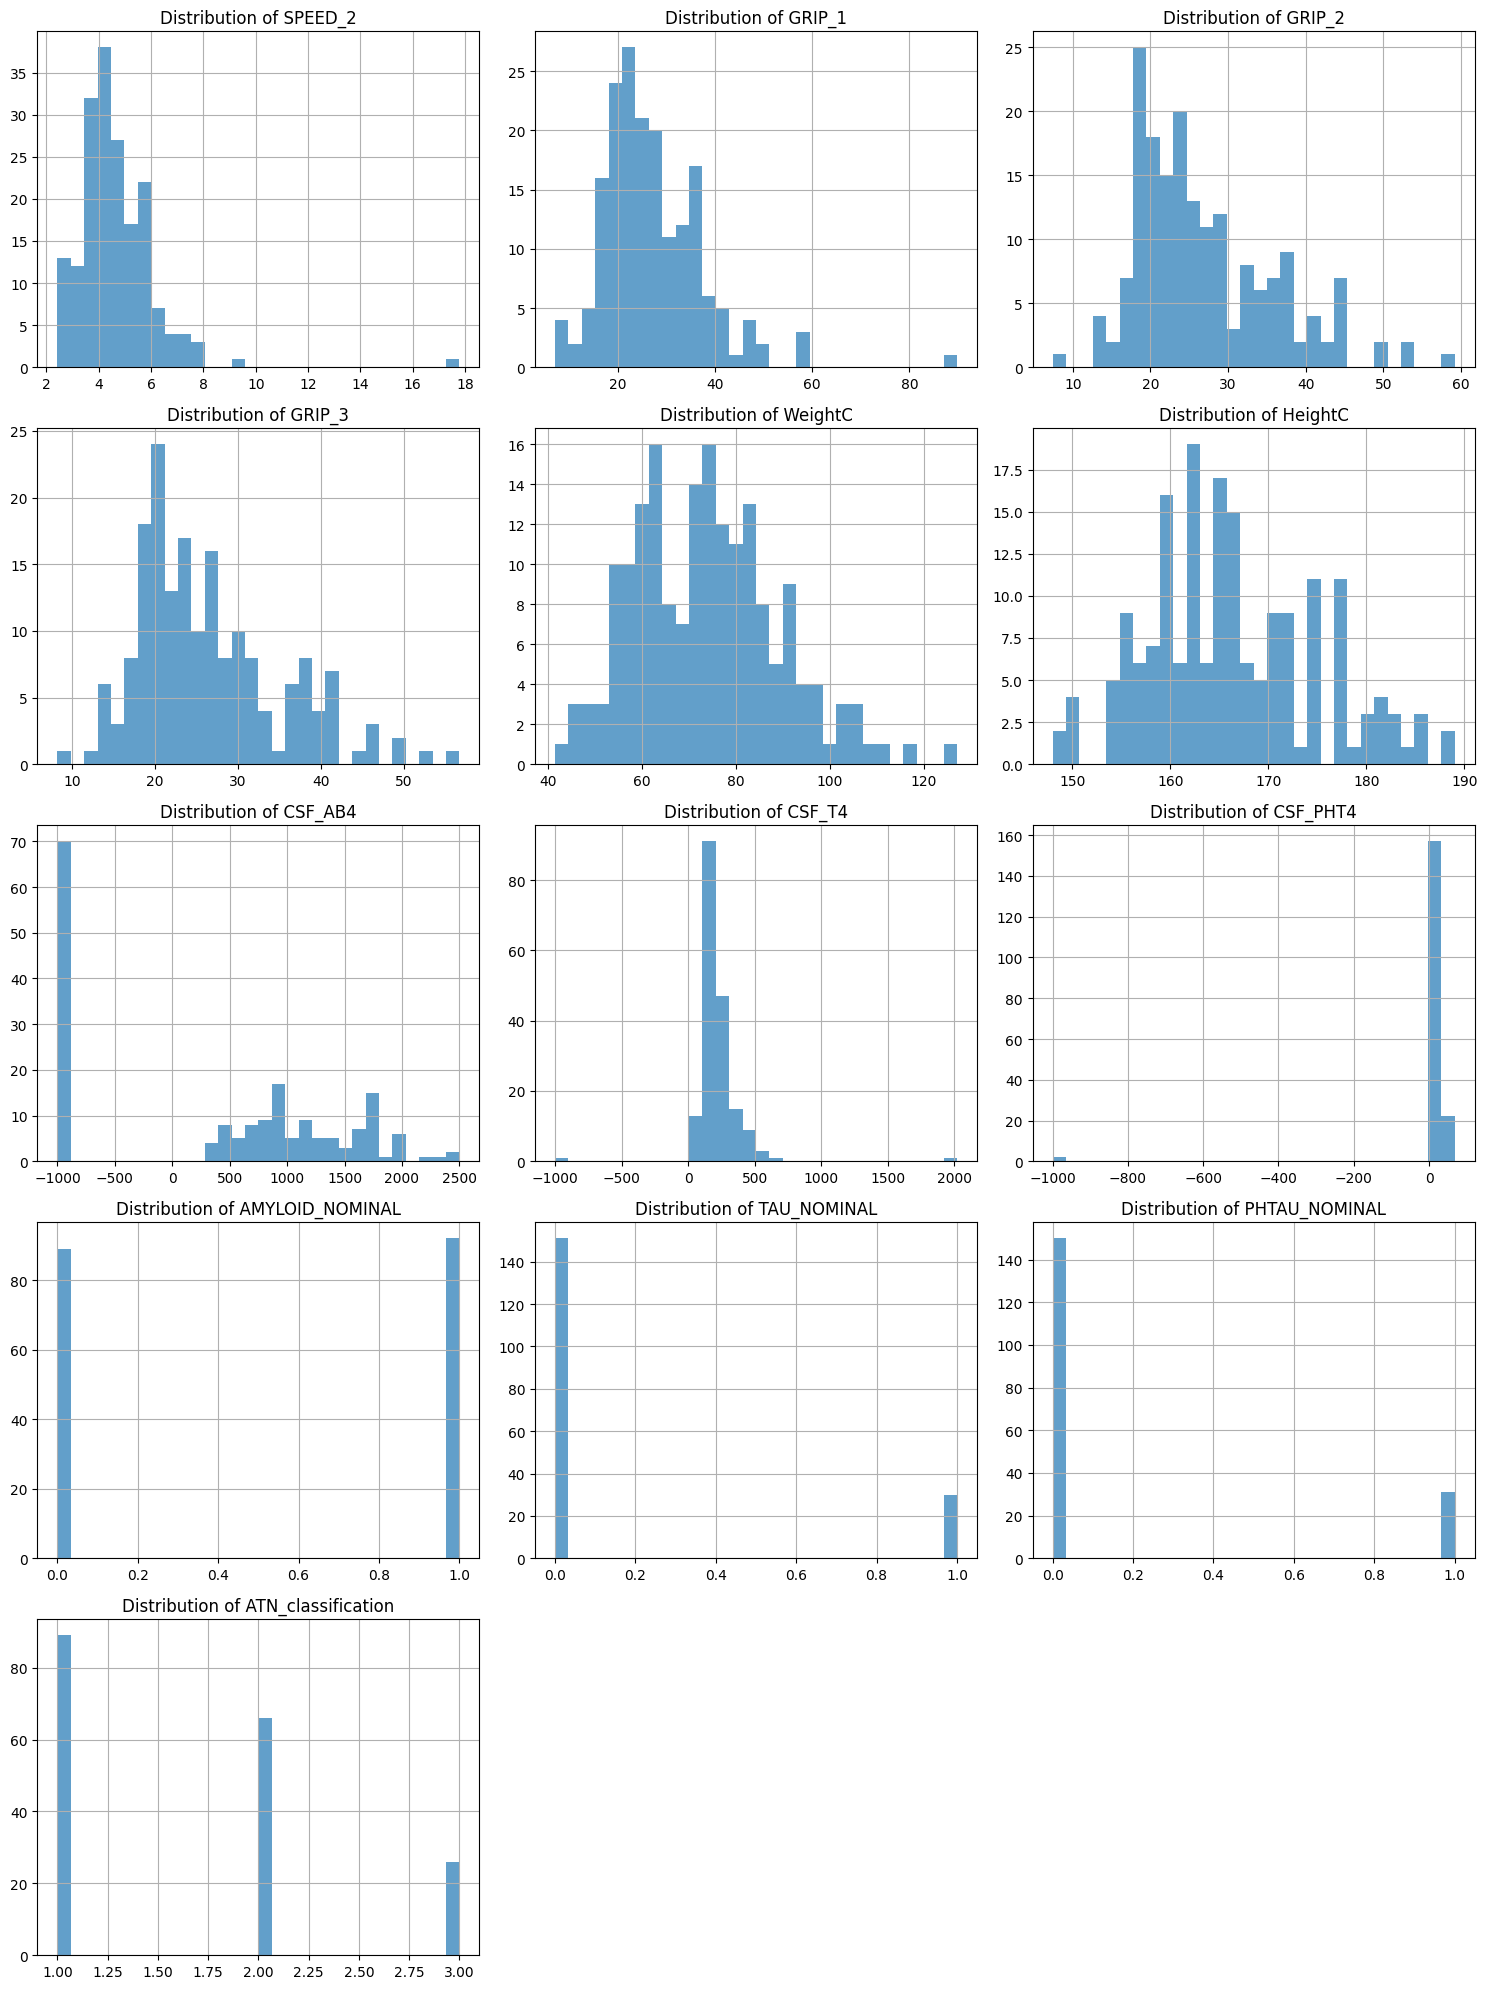

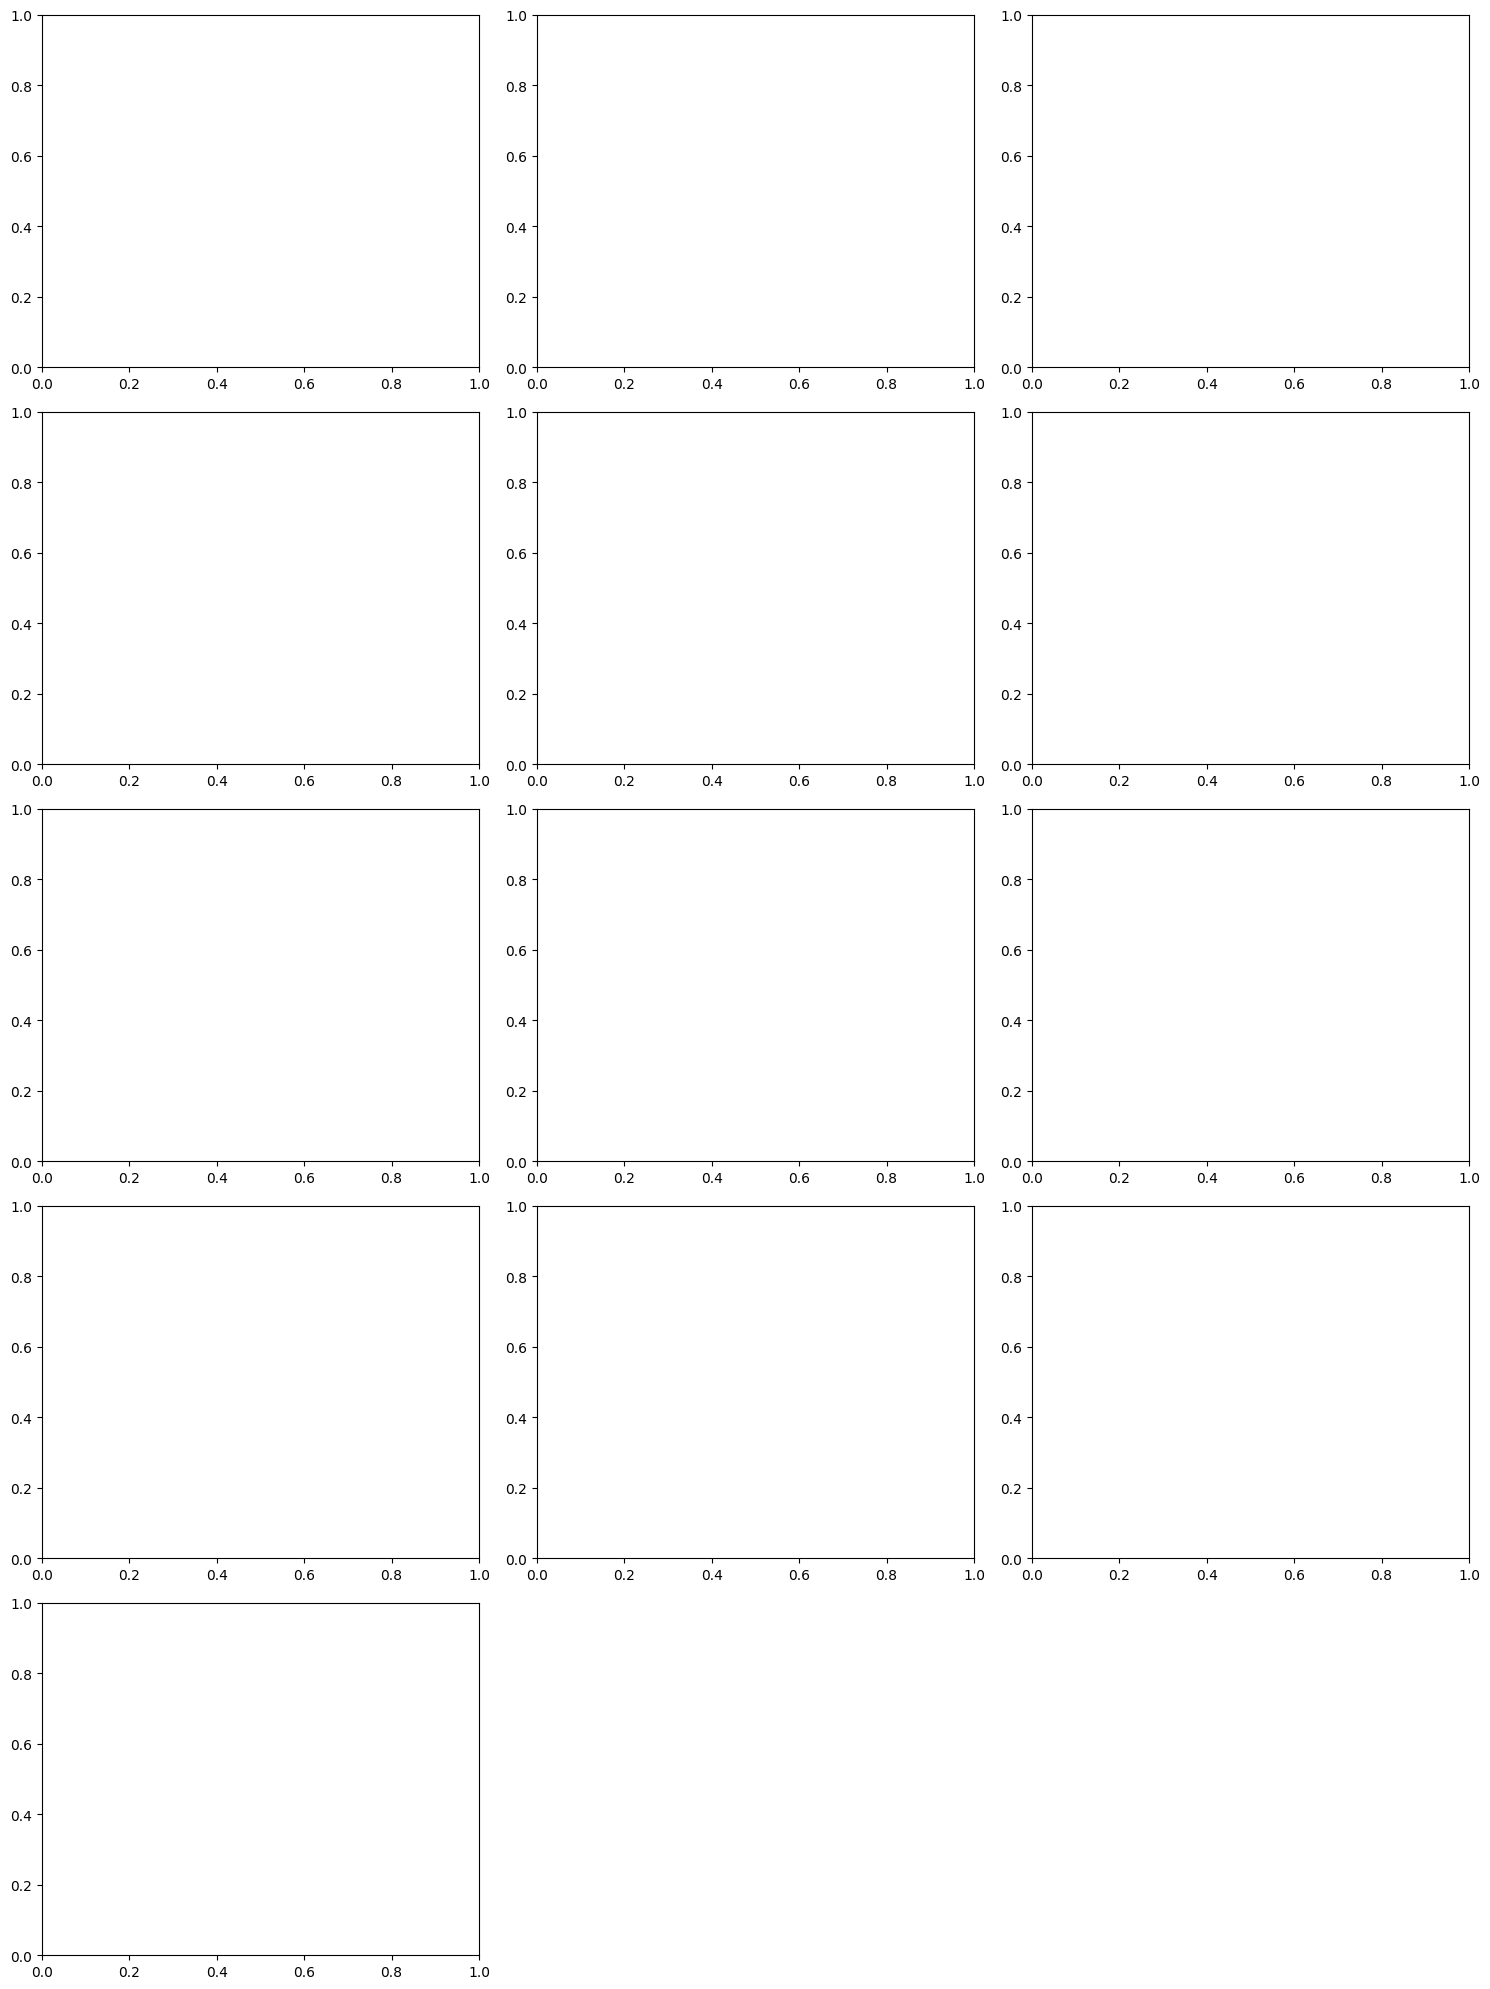

In [194]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = train_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(train_df.columns[start_idx:end_idx]):
        train_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [195]:
from scipy.stats import ks_2samp

# Loop through all numerical columns to compare distributions using KS test
for column in train_df.columns:
    if train_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = train_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = train_df[column][train_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.17569786535303777, p-value=0.9606726349437795
KS test for Living_Arrangement: stat=0.11001642036124795, p-value=0.9999351880224029
KS test for WorkStat: stat=0.6342857142857142, p-value=0.00873801925070937
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data for column: MH19
Not enough data for

In [196]:
from scipy.stats import ks_2samp

# Loop through all numerical columns to compare distributions using KS test
for column in test_df.columns:
    if test_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = test_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = test_df[column][test_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.2553191489361702, p-value=1.0
KS test for Living_Arrangement: stat=0.08888888888888889, p-value=1.0
KS test for WorkStat: stat=0.21739130434782608, p-value=1.0
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data for column: MH19
Not enough data for column: MH20
Not enough data for column: MH21

In [197]:
# Save train_df_copy and test_df_copy to csv
train_df_copy.to_csv('../data/train_df_NON_imputed_1stvisit.csv', index=False)
test_df_copy.to_csv('../data/test_df_NON_imputed_1stvisit.csv', index=False)